# Compare topography cross different components (CISM, CLM, CAM)

Author: Ziqi Yin

Last modified: 2024 Dec 29

Table of contents:
* [Maps of ice sheet surface elevation differences in CISM](#first-bullet)
* [Maps of ice sheet surface elevation differences in CAM](#second-bullet)
* [Differences between CAM and CISM elevations](#third-bullet)

In [1]:
import numpy as np
import numpy.ma as ma
import xarray as xr
from statistics import mode
import pandas as pd
from scipy import signal
from scipy import interpolate
from scipy import stats
import scipy.sparse as sps # For reading weight files

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.collections import PolyCollection
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.colors as colors
import cartopy
import cartopy.crs as ccrs
crs_np = ccrs.NorthPolarStereo(central_longitude=0)
crs_ll = ccrs.PlateCarree()
from cartopy.util import add_cyclic_point

home_dir = '/glade/work/ziqiyin/'
import sys  
sys.path.insert(0, home_dir)
sys.path.append(home_dir + 'function/')
from functions import *

# For unstructured grid
#from holoviews.operation.datashader import datashade, rasterize, regrid
import warnings
warnings.filterwarnings('ignore')

# For regridding
import os
import ESMF
import xesmf as xe

In [2]:
## Parameter
g = 9.80616 #[m/s2]

## 1. CISM topography <a class="anchor" id="first-bullet"></a>

### Get data

#### piControl

In [6]:
# BG7
BG7_thk_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_thk_yearly.nc')['thk']
BG7_topg_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_topg_yearly.nc')['topg']
BG7_ice_sheet_mask_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_ice_sheet_mask_yearly.nc')['ice_sheet_mask']

# F09
F09_piControl_thk_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_thk_piControl_yearly.nc')['thk']
F09_piControl_topg_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_topg_piControl_yearly.nc')['topg']
F09_piControl_ice_sheet_mask_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_ice_sheet_mask_piControl_yearly.nc')['ice_sheet_mask']
#F09_piControl_smb_4km_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_smb_piControl_yearly.nc')['smb']
#F09_piControl_velnorm_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_velnorm_piControl_yearly.nc')['velnorm'][:,0,:,:]

# ARCTIC
ARCTIC_piControl_p4_smb_4km_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_smb_piControl_p4_yearly.nc')['smb']
cism_x1 = ARCTIC_piControl_p4_smb_4km_yearly.x1
cism_y1 = ARCTIC_piControl_p4_smb_4km_yearly.y1
ARCTIC_piControl_p4_thk_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_thk_piControl_p4_yearly.nc')['thk']
ARCTIC_piControl_p4_velnorm_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_velnorm_piControl_p4_yearly.nc')['velnorm'][:,0,:,:]
cism_x0 = ARCTIC_piControl_p4_velnorm_yearly.x0
cism_y0 = ARCTIC_piControl_p4_velnorm_yearly.y0
ARCTIC_piControl_p4_ice_sheet_mask_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_ice_sheet_mask_piControl_p4_yearly.nc')['ice_sheet_mask']
ARCTIC_piControl_p4_topg_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_topg_piControl_p4_yearly.nc')['topg']

#### 1pctCO2

In [7]:
# F09M
F09M_1pctCO2_thk_yearly = xr.open_dataset('/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001/glc/proc/tseries/year_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.cism.h.thk.0001-0161.nc')['thk'][1:141]
F09M_1pctCO2_topg_yearly = xr.open_dataset('/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001/glc/proc/tseries/year_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.cism.h.topg.0001-0161.nc')['topg'][1:141]
F09M_1pctCO2_ice_sheet_mask_yearly = xr.open_dataset('/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001/glc/proc/tseries/year_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.cism.h.ice_sheet_mask.0001-0161.nc')['ice_sheet_mask'][1:141]

# F09
F09_1pctCO2_thk_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_thk_1pctCO2_yearly.nc')['thk']
F09_1pctCO2_topg_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_topg_1pctCO2_yearly.nc')['topg']
F09_1pctCO2_ice_sheet_mask_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_ice_sheet_mask_1pctCO2_yearly.nc')['ice_sheet_mask']

# ARCTIC
ARCTIC_1pctCO2_smb_4km_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_smb_1pctCO2_yearly.nc')['smb']
ARCTIC_1pctCO2_thk_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_thk_1pctCO2_yearly.nc')['thk']
ARCTIC_1pctCO2_velnorm_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_velnorm_1pctCO2_yearly.nc')['velnorm'][:,0,:,:]
ARCTIC_1pctCO2_ice_sheet_mask_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_ice_sheet_mask_1pctCO2_yearly.nc')['ice_sheet_mask']
ARCTIC_1pctCO2_topg_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_topg_1pctCO2_yearly.nc')['topg']

#### 4xext

In [8]:
# F09M
F09M_4xext_thk_yearly = xr.open_dataset('/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001/glc/proc/tseries/year_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001.cism.h.thk.0141-0351.nc')['thk'][1:]
F09M_4xext_topg_yearly = xr.open_dataset('/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001/glc/proc/tseries/year_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001.cism.h.topg.0141-0351.nc')['topg'][1:]
F09M_4xext_ice_sheet_mask_yearly = xr.open_dataset('/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001/glc/proc/tseries/year_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001.cism.h.ice_sheet_mask.0141-0351.nc')['ice_sheet_mask'][1:]

# F09
F09_4xext_thk_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_thk_4xext_yearly.nc')['thk']
F09_4xext_topg_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_topg_4xext_yearly.nc')['topg']
F09_4xext_ice_sheet_mask_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_ice_sheet_mask_4xext_yearly.nc')['ice_sheet_mask']

# ARCTIC
ARCTIC_4xext_smb_4km_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_smb_4xext_yearly.nc')['smb']
ARCTIC_4xext_thk_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_thk_4xext_yearly.nc')['thk']
ARCTIC_4xext_velnorm_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_velnorm_4xext_yearly.nc')['velnorm'][:,0,:,:]
ARCTIC_4xext_ice_sheet_mask_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_ice_sheet_mask_4xext_yearly.nc')['ice_sheet_mask']
ARCTIC_4xext_topg_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_topg_4xext_yearly.nc')['topg']

In [10]:
## Combine
# F09M
F09M_1pctCO2_4xext_thk_yearly = xr.concat([F09M_1pctCO2_thk_yearly, F09M_4xext_thk_yearly], dim='time')
F09M_1pctCO2_4xext_topg_yearly = xr.concat([F09M_1pctCO2_topg_yearly, F09M_4xext_topg_yearly], dim='time')
F09M_1pctCO2_4xext_ice_sheet_mask_yearly = xr.concat([F09M_1pctCO2_ice_sheet_mask_yearly, F09M_4xext_ice_sheet_mask_yearly], dim='time')

# F09
F09_1pctCO2_4xext_thk_yearly = xr.concat([F09_1pctCO2_thk_yearly, F09_4xext_thk_yearly], dim='time')
F09_1pctCO2_4xext_topg_yearly = xr.concat([F09_1pctCO2_topg_yearly, F09_4xext_topg_yearly], dim='time')
F09_1pctCO2_4xext_ice_sheet_mask_yearly = xr.concat([F09_1pctCO2_ice_sheet_mask_yearly, F09_4xext_ice_sheet_mask_yearly], dim='time')

# ARCTIC
ARCTIC_1pctCO2_4xext_smb_4km_yearly = xr.concat([ARCTIC_1pctCO2_smb_4km_yearly, ARCTIC_4xext_smb_4km_yearly], dim='time')
ARCTIC_1pctCO2_4xext_thk_yearly = xr.concat([ARCTIC_1pctCO2_thk_yearly, ARCTIC_4xext_thk_yearly], dim='time')
ARCTIC_1pctCO2_4xext_velnorm_yearly = xr.concat([ARCTIC_1pctCO2_velnorm_yearly, ARCTIC_4xext_velnorm_yearly], dim='time')
ARCTIC_1pctCO2_4xext_ice_sheet_mask_yearly = xr.concat([ARCTIC_1pctCO2_ice_sheet_mask_yearly, ARCTIC_4xext_ice_sheet_mask_yearly], dim='time')
ARCTIC_1pctCO2_4xext_topg_yearly = xr.concat([ARCTIC_1pctCO2_topg_yearly, ARCTIC_4xext_topg_yearly], dim='time')

### Calculate

In [19]:
# year 0
BG7_stopg_yr0 = BG7_topg_yearly[148] + BG7_thk_yearly[148]
F09_piControl_stopg_yr0 = F09_piControl_topg_yearly[-1] + F09_piControl_thk_yearly[-1]
ARCTIC_piControl_stopg_yr0 = ARCTIC_piControl_p4_topg_yearly[-1] + ARCTIC_piControl_p4_thk_yearly[-1]

# year 150
F09M_1pctCO2_4xext_stopg_yr150 = F09M_1pctCO2_4xext_topg_yearly[149] + F09M_1pctCO2_4xext_thk_yearly[149]
F09_1pctCO2_4xext_stopg_yr150 = F09_1pctCO2_4xext_topg_yearly[149] + F09_1pctCO2_4xext_thk_yearly[149]
ARCTIC_1pctCO2_4xext_stopg_yr150 = ARCTIC_1pctCO2_4xext_topg_yearly[149] + ARCTIC_1pctCO2_4xext_thk_yearly[149]

# year 250
F09M_1pctCO2_4xext_stopg_yr250 = F09M_1pctCO2_4xext_topg_yearly[249] + F09M_1pctCO2_4xext_thk_yearly[249]
F09_1pctCO2_4xext_stopg_yr250 = F09_1pctCO2_4xext_topg_yearly[249] + F09_1pctCO2_4xext_thk_yearly[249]
ARCTIC_1pctCO2_4xext_stopg_yr250 = ARCTIC_1pctCO2_4xext_topg_yearly[249] + ARCTIC_1pctCO2_4xext_thk_yearly[249]

# year 350
F09M_1pctCO2_4xext_stopg_yr350 = F09M_1pctCO2_4xext_topg_yearly[-1] + F09M_1pctCO2_4xext_thk_yearly[-1]
F09_1pctCO2_4xext_stopg_yr350 = F09_1pctCO2_4xext_topg_yearly[-1] + F09_1pctCO2_4xext_thk_yearly[-1]
ARCTIC_1pctCO2_4xext_stopg_yr350 = ARCTIC_1pctCO2_4xext_topg_yearly[-1] + ARCTIC_1pctCO2_4xext_thk_yearly[-1]

In [20]:
## Masked by ice_sheet_mask
# year 0
BG7_stopg_yr0_masked = BG7_ice_sheet_mask_yearly[148].where(BG7_ice_sheet_mask_yearly[148] > 0) * BG7_stopg_yr0
F09_piControl_stopg_yr0_masked = F09_piControl_ice_sheet_mask_yearly[-1].where(F09_piControl_ice_sheet_mask_yearly[-1] > 0) * F09_piControl_stopg_yr0
ARCTIC_piControl_stopg_yr0_masked = ARCTIC_piControl_p4_ice_sheet_mask_yearly[-1].where(ARCTIC_piControl_p4_ice_sheet_mask_yearly[-1] > 0) * ARCTIC_piControl_stopg_yr0

# year 150
F09M_1pctCO2_4xext_stopg_yr150_masked = F09M_1pctCO2_4xext_ice_sheet_mask_yearly[149].where(F09M_1pctCO2_4xext_ice_sheet_mask_yearly[149] > 0) * F09M_1pctCO2_4xext_stopg_yr150
F09_1pctCO2_4xext_stopg_yr150_masked = F09_1pctCO2_4xext_ice_sheet_mask_yearly[149].where(F09_1pctCO2_4xext_ice_sheet_mask_yearly[149] > 0) * F09_1pctCO2_4xext_stopg_yr150
ARCTIC_1pctCO2_4xext_stopg_yr150_masked = ARCTIC_1pctCO2_4xext_ice_sheet_mask_yearly[149].where(ARCTIC_1pctCO2_4xext_ice_sheet_mask_yearly[149] > 0) * ARCTIC_1pctCO2_4xext_stopg_yr150

# year 250
F09M_1pctCO2_4xext_stopg_yr250_masked = F09M_1pctCO2_4xext_ice_sheet_mask_yearly[249].where(F09M_1pctCO2_4xext_ice_sheet_mask_yearly[249] > 0) * F09M_1pctCO2_4xext_stopg_yr250
F09_1pctCO2_4xext_stopg_yr250_masked = F09_1pctCO2_4xext_ice_sheet_mask_yearly[249].where(F09_1pctCO2_4xext_ice_sheet_mask_yearly[249] > 0) * F09_1pctCO2_4xext_stopg_yr250
ARCTIC_1pctCO2_4xext_stopg_yr250_masked = ARCTIC_1pctCO2_4xext_ice_sheet_mask_yearly[249].where(ARCTIC_1pctCO2_4xext_ice_sheet_mask_yearly[249] > 0) * ARCTIC_1pctCO2_4xext_stopg_yr250

# year 350
F09M_1pctCO2_4xext_stopg_yr350_masked = F09M_1pctCO2_4xext_ice_sheet_mask_yearly[-1].where(F09M_1pctCO2_4xext_ice_sheet_mask_yearly[-1] > 0) * F09M_1pctCO2_4xext_stopg_yr350
F09_1pctCO2_4xext_stopg_yr350_masked = F09_1pctCO2_4xext_ice_sheet_mask_yearly[-1].where(F09_1pctCO2_4xext_ice_sheet_mask_yearly[-1] > 0) * F09_1pctCO2_4xext_stopg_yr350
ARCTIC_1pctCO2_4xext_stopg_yr350_masked = ARCTIC_1pctCO2_4xext_ice_sheet_mask_yearly[-1].where(ARCTIC_1pctCO2_4xext_ice_sheet_mask_yearly[-1] > 0) * ARCTIC_1pctCO2_4xext_stopg_yr350

In [21]:
## Difference
# year 0
ARCTICF09M_piControl_stopg_yr0_masked = ARCTIC_piControl_stopg_yr0_masked - BG7_stopg_yr0_masked
ARCTICF09_piControl_stopg_yr0_masked = ARCTIC_piControl_stopg_yr0_masked - F09_piControl_stopg_yr0_masked

# year 150
ARCTICF09M_1pctCO2_4xext_stopg_yr150_masked = ARCTIC_1pctCO2_4xext_stopg_yr150_masked - F09M_1pctCO2_4xext_stopg_yr150_masked
ARCTICF09_1pctCO2_4xext_stopg_yr150_masked = ARCTIC_1pctCO2_4xext_stopg_yr150_masked - F09_1pctCO2_4xext_stopg_yr150_masked

# year 250
ARCTICF09M_1pctCO2_4xext_stopg_yr250_masked = ARCTIC_1pctCO2_4xext_stopg_yr250_masked - F09M_1pctCO2_4xext_stopg_yr250_masked
ARCTICF09_1pctCO2_4xext_stopg_yr250_masked = ARCTIC_1pctCO2_4xext_stopg_yr250_masked - F09_1pctCO2_4xext_stopg_yr250_masked

# year 350
ARCTICF09M_1pctCO2_4xext_stopg_yr350_masked = ARCTIC_1pctCO2_4xext_stopg_yr350_masked - F09M_1pctCO2_4xext_stopg_yr350_masked
ARCTICF09_1pctCO2_4xext_stopg_yr350_masked = ARCTIC_1pctCO2_4xext_stopg_yr350_masked - F09_1pctCO2_4xext_stopg_yr350_masked

### Plot

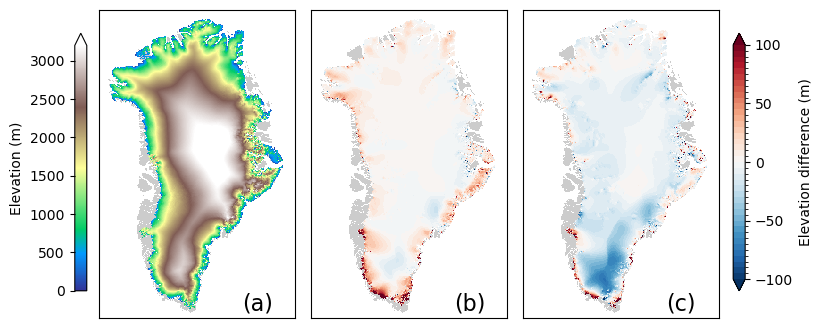

In [19]:
# year 0
fig = plt.figure(figsize = (8,4))
gs=GridSpec(1,3)
plt.rcParams['axes.titlepad'] =14

size_label = 10
size_title = 16

cmap1 = plt.cm.terrain

cmap2 = plt.cm.RdBu_r
bounds2 = np.arange(-100.,100.1,5.)
bounds2min = [-1000]
bounds2max = [1000]
norm2 = mpl.colors.BoundaryNorm(bounds2, cmap2.N, extend='both')
ticks2 = np.arange(-100.,100.1,50.)

#--------------------------------------------- ----------------------------------------------------
ax1 = plt.subplot(gs[0])
im1 = ax1.pcolormesh(cism_x1, cism_y1, ARCTIC_piControl_p4_topg_yearly[-1].where(ARCTIC_piControl_p4_topg_yearly[-1]>0).where(ARCTIC_piControl_p4_topg_yearly[-1]<0, other=1), cmap='Pastel2_r')
im1 = ax1.pcolormesh(cism_x1, cism_y1, ARCTIC_piControl_stopg_yr0_masked, cmap=cmap1, vmin=0, vmax=3200)
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax1.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax1.text(500000, -3330000, '(a)', fontsize=size_title)

# colorbar
cbar_ax1 = fig.add_axes([0.095, 0.178, 0.015, 0.644])
cb1 = fig.colorbar(im1, cax=cbar_ax1, orientation='vertical', extend='max')
cb1.set_label(label='Elevation (m)', size=size_label)
cb1.ax.tick_params(labelsize=size_label)
cb1.ax.yaxis.set_ticks_position('left')
cb1.ax.yaxis.set_label_position('left')

ax2 = plt.subplot(gs[1])
im2 = ax2.pcolormesh(cism_x1, cism_y1, ARCTIC_piControl_p4_topg_yearly[-1].where(ARCTIC_piControl_p4_topg_yearly[-1]>0).where(ARCTIC_piControl_p4_topg_yearly[-1]<0, other=1), cmap='Pastel2_r')
im2 = ax2.pcolormesh(cism_x1, cism_y1, ARCTICF09M_piControl_stopg_yr0_masked, cmap=cmap2, norm=norm2)
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax2.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax2.text(500000, -3330000, '(b)', fontsize=size_title)

ax3 = plt.subplot(gs[2])
#im3 = ax3.contourf(cism_x1, cism_y1, F09_piControl_topg_yearly[-1].where(F09_piControl_topg_yearly[-1]>0).where(F09_piControl_topg_yearly[-1]<0, other=1), cmap='gray_r')
im3 = ax3.pcolormesh(cism_x1, cism_y1, ARCTIC_piControl_p4_topg_yearly[-1].where(ARCTIC_piControl_p4_topg_yearly[-1]>0).where(ARCTIC_piControl_p4_topg_yearly[-1]<0, other=1), cmap='Pastel2_r')
im3 = ax3.pcolormesh(cism_x1, cism_y1, ARCTICF09_piControl_stopg_yr0_masked, cmap=cmap2, norm=norm2)
ax3.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax3.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax3.text(500000, -3330000, '(c)', fontsize=size_title)

# colorbar
cbar_ax3 = fig.add_axes([0.918, 0.178, 0.015, 0.644])
cb3 = fig.colorbar(im3, cax=cbar_ax3, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb3.set_label(label='Elevation difference (m)', size=size_label)
cb3.ax.tick_params(labelsize=size_label)

plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.08,
                    hspace=0.03)

#plt.savefig(home_dir+'dynamic_GrIS/github/plot/Map_elev_elev_diff_PI.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

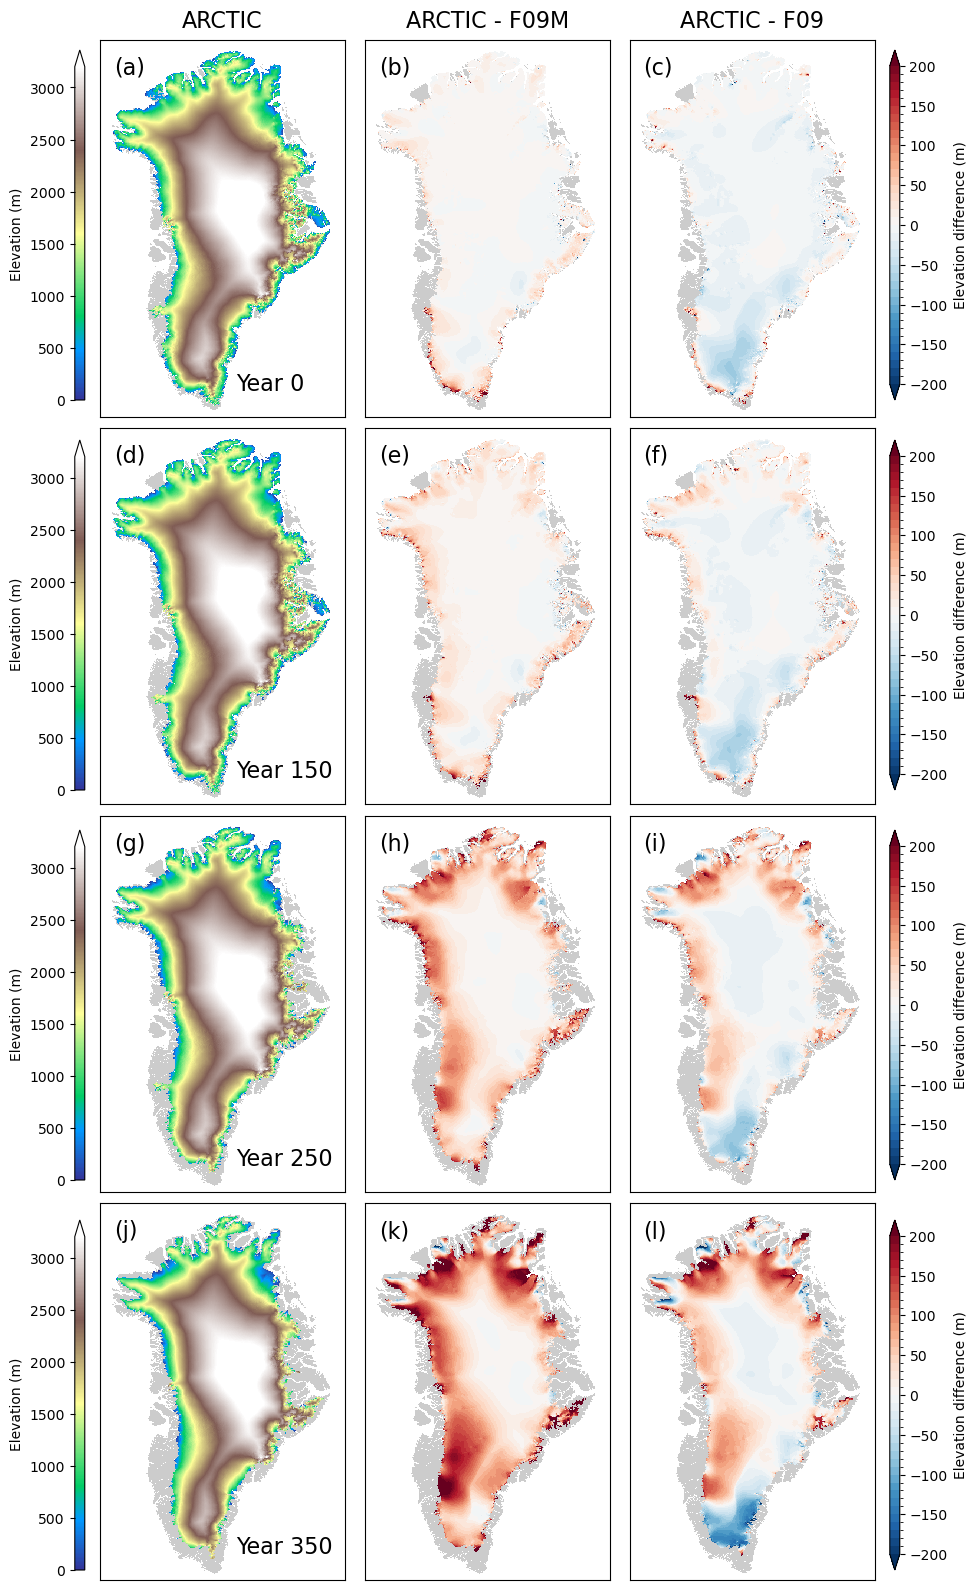

In [55]:
# year 0, 150, 250, and 350
fig = plt.figure(figsize = (10,20))
gs=GridSpec(4,3)
plt.rcParams['axes.titlepad'] =14

size_label = 10
size_title = 16

cmap1 = plt.cm.terrain

cmap2 = plt.cm.RdBu_r
bounds2 = np.arange(-200.,200.1,10.)
bounds2min = [-1000]
bounds2max = [1000]
norm2 = mpl.colors.BoundaryNorm(bounds2, cmap2.N, extend='both')
ticks2 = np.arange(-200.,200.1,50.)

#--------------------------------------------- year 0 ----------------------------------------------------
ax1 = plt.subplot(gs[0])
im1 = ax1.pcolormesh(cism_x1, cism_y1, ARCTIC_piControl_p4_topg_yearly[-1].where(ARCTIC_piControl_p4_topg_yearly[-1]>0).where(ARCTIC_piControl_p4_topg_yearly[-1]<0, other=1), cmap='Pastel2_r')
im1 = ax1.pcolormesh(cism_x1, cism_y1, ARCTIC_piControl_stopg_yr0_masked, cmap=cmap1, vmin=0, vmax=3200)
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax1.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax1.set_title('ARCTIC', pad=9, fontsize=size_title)#, fontweight='bold')
ax1.text(-620000, -840000, '(a)', fontsize=size_title)
ax1.text(210000, -3200000, 'Year 0', fontsize=size_title)

# colorbar
cbar_ax1 = fig.add_axes([0.1, 0.7, 0.01, 0.175])
cb1 = fig.colorbar(im1, cax=cbar_ax1, orientation='vertical', extend='max')
cb1.set_label(label='Elevation (m)', size=size_label)
cb1.ax.tick_params(labelsize=size_label)
cb1.ax.yaxis.set_ticks_position('left')
cb1.ax.yaxis.set_label_position('left')

ax2 = plt.subplot(gs[1])
im2 = ax2.pcolormesh(cism_x1, cism_y1, ARCTIC_piControl_p4_topg_yearly[-1].where(ARCTIC_piControl_p4_topg_yearly[-1]>0).where(ARCTIC_piControl_p4_topg_yearly[-1]<0, other=1), cmap='Pastel2_r')
im2 = ax2.pcolormesh(cism_x1, cism_y1, ARCTICF09M_piControl_stopg_yr0_masked, cmap=cmap2, norm=norm2)
ax2.set_title('ARCTIC - F09M', pad=9, fontsize=size_title)
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax2.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax2.text(-620000, -840000, '(b)', fontsize=size_title)

ax3 = plt.subplot(gs[2])
#im3 = ax3.contourf(cism_x1, cism_y1, F09_piControl_topg_yearly[-1].where(F09_piControl_topg_yearly[-1]>0).where(F09_piControl_topg_yearly[-1]<0, other=1), cmap='gray_r')
im3 = ax3.pcolormesh(cism_x1, cism_y1, ARCTIC_piControl_p4_topg_yearly[-1].where(ARCTIC_piControl_p4_topg_yearly[-1]>0).where(ARCTIC_piControl_p4_topg_yearly[-1]<0, other=1), cmap='Pastel2_r')
im3 = ax3.pcolormesh(cism_x1, cism_y1, ARCTICF09_piControl_stopg_yr0_masked, cmap=cmap2, norm=norm2)
ax3.set_title('ARCTIC - F09', pad=9, fontsize=size_title)
ax3.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax3.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax3.text(-620000, -840000, '(c)', fontsize=size_title)

# colorbar
cbar_ax3 = fig.add_axes([0.915, 0.7, 0.01, 0.175])
cb3 = fig.colorbar(im3, cax=cbar_ax3, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb3.set_label(label='Elevation difference (m)', size=size_label)
cb3.ax.tick_params(labelsize=size_label)

#--------------------------------------------- year 150 ----------------------------------------------------
ax4 = plt.subplot(gs[3])
im4 = ax4.pcolormesh(cism_x1, cism_y1, ARCTIC_1pctCO2_4xext_topg_yearly[149].where(ARCTIC_1pctCO2_4xext_topg_yearly[149]>0).where(ARCTIC_1pctCO2_4xext_topg_yearly[149]<0, other=1), cmap='Pastel2_r')
im4 = ax4.pcolormesh(cism_x1, cism_y1, ARCTIC_1pctCO2_4xext_stopg_yr150_masked, cmap=cmap1, vmin=0, vmax=3200)
ax4.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax4.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax4.text(-620000, -840000, '(d)', fontsize=size_title)
ax4.text(210000, -3200000, 'Year 150', fontsize=size_title)

# colorbar
cbar_ax4 = fig.add_axes([0.1, 0.505, 0.01, 0.175])
cb4 = fig.colorbar(im4, cax=cbar_ax4, orientation='vertical', extend='max')
cb4.set_label(label='Elevation (m)', size=size_label)
cb4.ax.tick_params(labelsize=size_label)
cb4.ax.yaxis.set_ticks_position('left')
cb4.ax.yaxis.set_label_position('left')

ax5 = plt.subplot(gs[4])
im5 = ax5.pcolormesh(cism_x1, cism_y1, ARCTIC_1pctCO2_4xext_topg_yearly[149].where(ARCTIC_1pctCO2_4xext_topg_yearly[149]>0).where(ARCTIC_1pctCO2_4xext_topg_yearly[149]<0, other=1), cmap='Pastel2_r')
im5 = ax5.pcolormesh(cism_x1, cism_y1, ARCTICF09M_1pctCO2_4xext_stopg_yr150_masked, cmap=cmap2, norm=norm2)
ax5.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax5.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax5.text(-620000, -840000, '(e)', fontsize=size_title)

ax6 = plt.subplot(gs[5])
im6 = ax6.pcolormesh(cism_x1, cism_y1, ARCTIC_1pctCO2_4xext_topg_yearly[149].where(ARCTIC_1pctCO2_4xext_topg_yearly[149]>0).where(ARCTIC_1pctCO2_4xext_topg_yearly[149]<0, other=1), cmap='Pastel2_r')
im6 = ax6.pcolormesh(cism_x1, cism_y1, ARCTICF09_1pctCO2_4xext_stopg_yr150_masked, cmap=cmap2, norm=norm2)
ax6.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax6.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax6.text(-620000, -840000, '(f)', fontsize=size_title)

# colorbar
cbar_ax6 = fig.add_axes([0.915, 0.505, 0.01, 0.175])
cb6 = fig.colorbar(im6, cax=cbar_ax6, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb6.set_label(label='Elevation difference (m)', size=size_label)
cb6.ax.tick_params(labelsize=size_label)

#--------------------------------------------- year 250 ----------------------------------------------------
ax7 = plt.subplot(gs[6])
im7 = ax7.pcolormesh(cism_x1, cism_y1, ARCTIC_1pctCO2_4xext_topg_yearly[249].where(ARCTIC_1pctCO2_4xext_topg_yearly[249]>0).where(ARCTIC_1pctCO2_4xext_topg_yearly[249]<0, other=1), cmap='Pastel2_r')
im7 = ax7.pcolormesh(cism_x1, cism_y1, ARCTIC_1pctCO2_4xext_stopg_yr250_masked, cmap=cmap1, vmin=0, vmax=3200)
ax7.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax7.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax7.text(-620000, -840000, '(g)', fontsize=size_title)
ax7.text(210000, -3200000, 'Year 250', fontsize=size_title)

# colorbar
cbar_ax7 = fig.add_axes([0.1, 0.31, 0.01, 0.175])
cb7 = fig.colorbar(im7, cax=cbar_ax7, orientation='vertical', extend='max')
cb7.set_label(label='Elevation (m)', size=size_label)
cb7.ax.tick_params(labelsize=size_label)
cb7.ax.yaxis.set_ticks_position('left')
cb7.ax.yaxis.set_label_position('left')

ax8 = plt.subplot(gs[7])
im8 = ax8.pcolormesh(cism_x1, cism_y1, ARCTIC_1pctCO2_4xext_topg_yearly[249].where(ARCTIC_1pctCO2_4xext_topg_yearly[249]>0).where(ARCTIC_1pctCO2_4xext_topg_yearly[249]<0, other=1), cmap='Pastel2_r')
im8 = ax8.pcolormesh(cism_x1, cism_y1, ARCTICF09M_1pctCO2_4xext_stopg_yr250_masked, cmap=cmap2, norm=norm2)
ax8.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax8.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax8.text(-620000, -840000, '(h)', fontsize=size_title)

ax9 = plt.subplot(gs[8])
im9 = ax9.pcolormesh(cism_x1, cism_y1, ARCTIC_1pctCO2_4xext_topg_yearly[249].where(ARCTIC_1pctCO2_4xext_topg_yearly[249]>0).where(ARCTIC_1pctCO2_4xext_topg_yearly[249]<0, other=1), cmap='Pastel2_r')
im9 = ax9.pcolormesh(cism_x1, cism_y1, ARCTICF09_1pctCO2_4xext_stopg_yr250_masked, cmap=cmap2, norm=norm2)
ax9.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax9.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax9.text(-620000, -840000, '(i)', fontsize=size_title)

# colorbar
cbar_ax9 = fig.add_axes([0.915, 0.31, 0.01, 0.175])
cb9 = fig.colorbar(im9, cax=cbar_ax9, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb9.set_label(label='Elevation difference (m)', size=size_label)
cb9.ax.tick_params(labelsize=size_label)

#--------------------------------------------- year 350 ----------------------------------------------------
ax10 = plt.subplot(gs[9])
im10 = ax10.pcolormesh(cism_x1, cism_y1, ARCTIC_1pctCO2_4xext_topg_yearly[-1].where(ARCTIC_1pctCO2_4xext_topg_yearly[-1]>0).where(ARCTIC_1pctCO2_4xext_topg_yearly[-1]<0, other=1), cmap='Pastel2_r')
im10 = ax10.pcolormesh(cism_x1, cism_y1, ARCTIC_1pctCO2_4xext_stopg_yr350_masked, cmap=cmap1, vmin=0, vmax=3200)
ax10.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax10.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax10.text(-620000, -840000, '(j)', fontsize=size_title)
ax10.text(210000, -3200000, 'Year 350', fontsize=size_title)

# colorbar
cbar_ax10 = fig.add_axes([0.1, 0.115, 0.01, 0.175])
cb10 = fig.colorbar(im10, cax=cbar_ax10, orientation='vertical', extend='max')
cb10.set_label(label='Elevation (m)', size=size_label)
cb10.ax.tick_params(labelsize=size_label)
cb10.ax.yaxis.set_ticks_position('left')
cb10.ax.yaxis.set_label_position('left')

ax11 = plt.subplot(gs[10])
im11 = ax11.pcolormesh(cism_x1, cism_y1, ARCTIC_1pctCO2_4xext_topg_yearly[-1].where(ARCTIC_1pctCO2_4xext_topg_yearly[-1]>0).where(ARCTIC_1pctCO2_4xext_topg_yearly[-1]<0, other=1), cmap='Pastel2_r')
im11 = ax11.pcolormesh(cism_x1, cism_y1, ARCTICF09M_1pctCO2_4xext_stopg_yr350_masked, cmap=cmap2, norm=norm2)
ax11.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax11.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax11.text(-620000, -840000, '(k)', fontsize=size_title)

ax12 = plt.subplot(gs[11])
im12 = ax12.pcolormesh(cism_x1, cism_y1, ARCTIC_1pctCO2_4xext_topg_yearly[-1].where(ARCTIC_1pctCO2_4xext_topg_yearly[-1]>0).where(ARCTIC_1pctCO2_4xext_topg_yearly[-1]<0, other=1), cmap='Pastel2_r')
im12 = ax12.pcolormesh(cism_x1, cism_y1, ARCTICF09_1pctCO2_4xext_stopg_yr350_masked, cmap=cmap2, norm=norm2)
ax12.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax12.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax12.text(-620000, -840000, '(l)', fontsize=size_title)

# colorbar
cbar_ax12 = fig.add_axes([0.915, 0.115, 0.01, 0.175])
cb12 = fig.colorbar(im12, cax=cbar_ax12, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb12.set_label(label='Elevation difference (m)', size=size_label)
cb12.ax.tick_params(labelsize=size_label)

plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.08,
                    hspace=0.03)

plt.savefig(home_dir+'dynamic_GrIS/github/plot/Map_elev_elev_diff_CISM.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

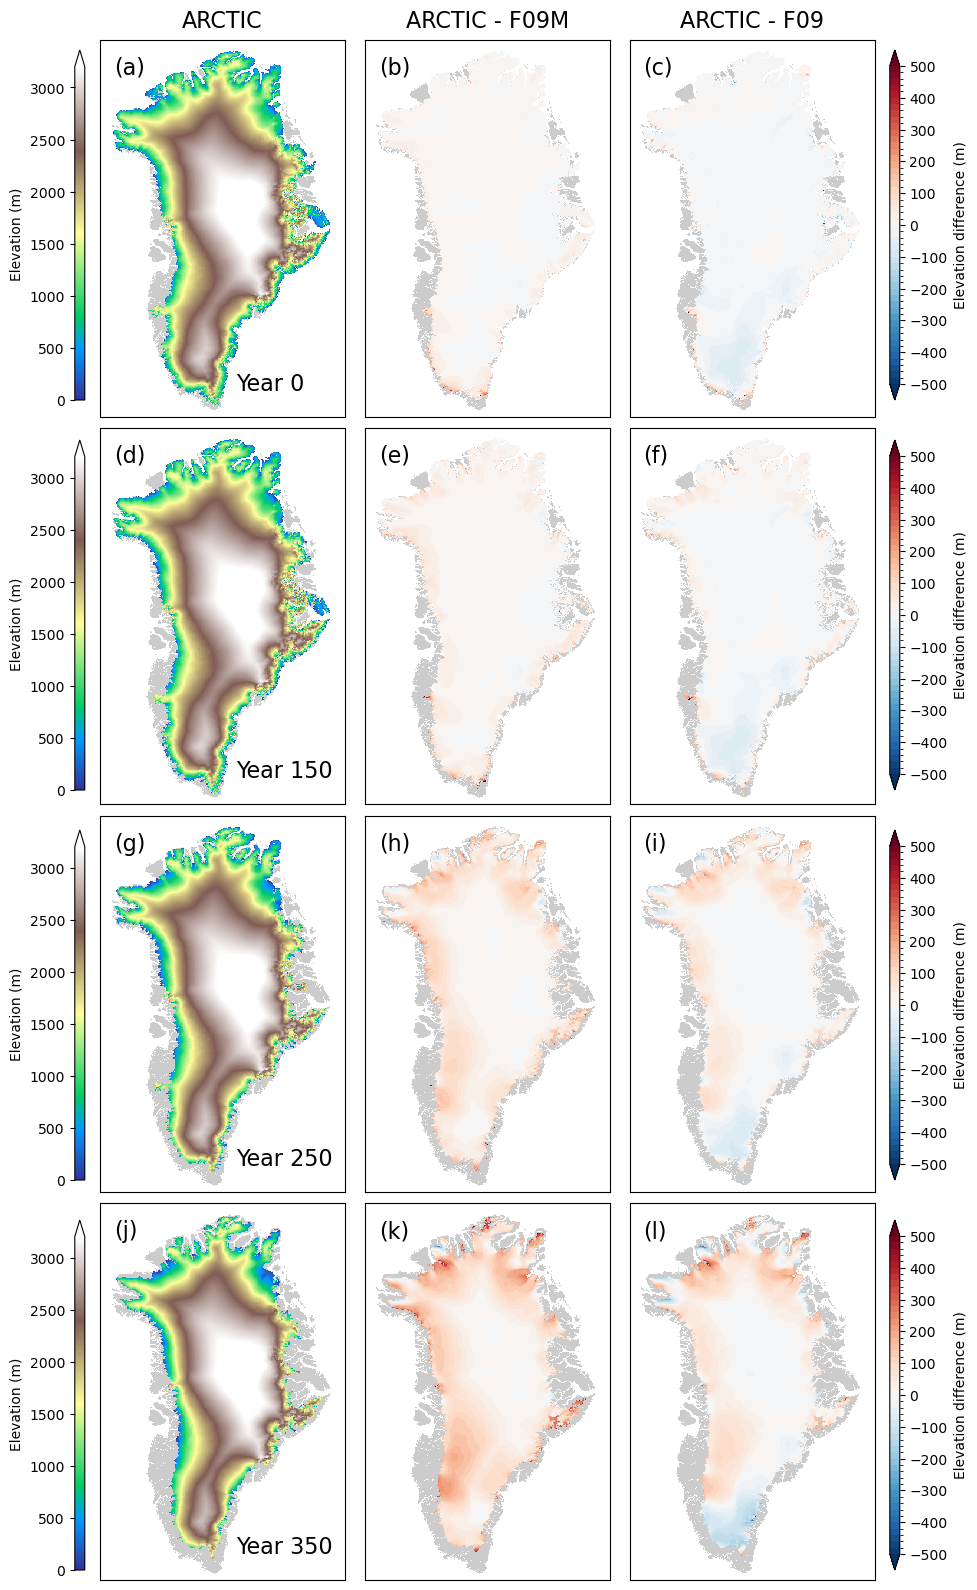

In [12]:
# year 0, 150, 250, and 350
fig = plt.figure(figsize = (10,20))
gs=GridSpec(4,3)
plt.rcParams['axes.titlepad'] =14

size_label = 10
size_title = 16

cmap1 = plt.cm.terrain

cmap2 = plt.cm.RdBu_r
bounds2 = np.arange(-500.,500.1,20.)
bounds2min = [-1000]
bounds2max = [1000]
norm2 = mpl.colors.BoundaryNorm(bounds2, cmap2.N, extend='both')
ticks2 = np.arange(-500.,500.1,100.)

#--------------------------------------------- year 0 ----------------------------------------------------
ax1 = plt.subplot(gs[0])
im1 = ax1.pcolormesh(cism_x1, cism_y1, ARCTIC_piControl_p4_topg_yearly[-1].where(ARCTIC_piControl_p4_topg_yearly[-1]>0).where(ARCTIC_piControl_p4_topg_yearly[-1]<0, other=1), cmap='Pastel2_r')
im1 = ax1.pcolormesh(cism_x1, cism_y1, ARCTIC_piControl_stopg_yr0_masked, cmap=cmap1, vmin=0, vmax=3200)
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax1.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax1.set_title('ARCTIC', pad=9, fontsize=size_title)#, fontweight='bold')
ax1.text(-620000, -840000, '(a)', fontsize=size_title)
ax1.text(210000, -3200000, 'Year 0', fontsize=size_title)

# colorbar
cbar_ax1 = fig.add_axes([0.1, 0.7, 0.01, 0.175])
cb1 = fig.colorbar(im1, cax=cbar_ax1, orientation='vertical', extend='max')
cb1.set_label(label='Elevation (m)', size=size_label)
cb1.ax.tick_params(labelsize=size_label)
cb1.ax.yaxis.set_ticks_position('left')
cb1.ax.yaxis.set_label_position('left')

ax2 = plt.subplot(gs[1])
im2 = ax2.pcolormesh(cism_x1, cism_y1, ARCTIC_piControl_p4_topg_yearly[-1].where(ARCTIC_piControl_p4_topg_yearly[-1]>0).where(ARCTIC_piControl_p4_topg_yearly[-1]<0, other=1), cmap='Pastel2_r')
im2 = ax2.pcolormesh(cism_x1, cism_y1, ARCTICF09M_piControl_stopg_yr0_masked, cmap=cmap2, norm=norm2)
ax2.set_title('ARCTIC - F09M', pad=9, fontsize=size_title)
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax2.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax2.text(-620000, -840000, '(b)', fontsize=size_title)

ax3 = plt.subplot(gs[2])
#im3 = ax3.contourf(cism_x1, cism_y1, F09_piControl_topg_yearly[-1].where(F09_piControl_topg_yearly[-1]>0).where(F09_piControl_topg_yearly[-1]<0, other=1), cmap='gray_r')
im3 = ax3.pcolormesh(cism_x1, cism_y1, ARCTIC_piControl_p4_topg_yearly[-1].where(ARCTIC_piControl_p4_topg_yearly[-1]>0).where(ARCTIC_piControl_p4_topg_yearly[-1]<0, other=1), cmap='Pastel2_r')
im3 = ax3.pcolormesh(cism_x1, cism_y1, ARCTICF09_piControl_stopg_yr0_masked, cmap=cmap2, norm=norm2)
ax3.set_title('ARCTIC - F09', pad=9, fontsize=size_title)
ax3.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax3.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax3.text(-620000, -840000, '(c)', fontsize=size_title)

# colorbar
cbar_ax3 = fig.add_axes([0.915, 0.7, 0.01, 0.175])
cb3 = fig.colorbar(im3, cax=cbar_ax3, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb3.set_label(label='Elevation difference (m)', size=size_label)
cb3.ax.tick_params(labelsize=size_label)

#--------------------------------------------- year 150 ----------------------------------------------------
ax4 = plt.subplot(gs[3])
im4 = ax4.pcolormesh(cism_x1, cism_y1, ARCTIC_1pctCO2_4xext_topg_yearly[149].where(ARCTIC_1pctCO2_4xext_topg_yearly[149]>0).where(ARCTIC_1pctCO2_4xext_topg_yearly[149]<0, other=1), cmap='Pastel2_r')
im4 = ax4.pcolormesh(cism_x1, cism_y1, ARCTIC_1pctCO2_4xext_stopg_yr150_masked, cmap=cmap1, vmin=0, vmax=3200)
ax4.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax4.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax4.text(-620000, -840000, '(d)', fontsize=size_title)
ax4.text(210000, -3200000, 'Year 150', fontsize=size_title)

# colorbar
cbar_ax4 = fig.add_axes([0.1, 0.505, 0.01, 0.175])
cb4 = fig.colorbar(im4, cax=cbar_ax4, orientation='vertical', extend='max')
cb4.set_label(label='Elevation (m)', size=size_label)
cb4.ax.tick_params(labelsize=size_label)
cb4.ax.yaxis.set_ticks_position('left')
cb4.ax.yaxis.set_label_position('left')

ax5 = plt.subplot(gs[4])
im5 = ax5.pcolormesh(cism_x1, cism_y1, ARCTIC_1pctCO2_4xext_topg_yearly[149].where(ARCTIC_1pctCO2_4xext_topg_yearly[149]>0).where(ARCTIC_1pctCO2_4xext_topg_yearly[149]<0, other=1), cmap='Pastel2_r')
im5 = ax5.pcolormesh(cism_x1, cism_y1, ARCTICF09M_1pctCO2_4xext_stopg_yr150_masked, cmap=cmap2, norm=norm2)
ax5.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax5.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax5.text(-620000, -840000, '(e)', fontsize=size_title)

ax6 = plt.subplot(gs[5])
im6 = ax6.pcolormesh(cism_x1, cism_y1, ARCTIC_1pctCO2_4xext_topg_yearly[149].where(ARCTIC_1pctCO2_4xext_topg_yearly[149]>0).where(ARCTIC_1pctCO2_4xext_topg_yearly[149]<0, other=1), cmap='Pastel2_r')
im6 = ax6.pcolormesh(cism_x1, cism_y1, ARCTICF09_1pctCO2_4xext_stopg_yr150_masked, cmap=cmap2, norm=norm2)
ax6.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax6.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax6.text(-620000, -840000, '(f)', fontsize=size_title)

# colorbar
cbar_ax6 = fig.add_axes([0.915, 0.505, 0.01, 0.175])
cb6 = fig.colorbar(im6, cax=cbar_ax6, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb6.set_label(label='Elevation difference (m)', size=size_label)
cb6.ax.tick_params(labelsize=size_label)

#--------------------------------------------- year 250 ----------------------------------------------------
ax7 = plt.subplot(gs[6])
im7 = ax7.pcolormesh(cism_x1, cism_y1, ARCTIC_1pctCO2_4xext_topg_yearly[249].where(ARCTIC_1pctCO2_4xext_topg_yearly[249]>0).where(ARCTIC_1pctCO2_4xext_topg_yearly[249]<0, other=1), cmap='Pastel2_r')
im7 = ax7.pcolormesh(cism_x1, cism_y1, ARCTIC_1pctCO2_4xext_stopg_yr250_masked, cmap=cmap1, vmin=0, vmax=3200)
ax7.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax7.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax7.text(-620000, -840000, '(g)', fontsize=size_title)
ax7.text(210000, -3200000, 'Year 250', fontsize=size_title)

# colorbar
cbar_ax7 = fig.add_axes([0.1, 0.31, 0.01, 0.175])
cb7 = fig.colorbar(im7, cax=cbar_ax7, orientation='vertical', extend='max')
cb7.set_label(label='Elevation (m)', size=size_label)
cb7.ax.tick_params(labelsize=size_label)
cb7.ax.yaxis.set_ticks_position('left')
cb7.ax.yaxis.set_label_position('left')

ax8 = plt.subplot(gs[7])
im8 = ax8.pcolormesh(cism_x1, cism_y1, ARCTIC_1pctCO2_4xext_topg_yearly[249].where(ARCTIC_1pctCO2_4xext_topg_yearly[249]>0).where(ARCTIC_1pctCO2_4xext_topg_yearly[249]<0, other=1), cmap='Pastel2_r')
im8 = ax8.pcolormesh(cism_x1, cism_y1, ARCTICF09M_1pctCO2_4xext_stopg_yr250_masked, cmap=cmap2, norm=norm2)
ax8.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax8.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax8.text(-620000, -840000, '(h)', fontsize=size_title)

ax9 = plt.subplot(gs[8])
im9 = ax9.pcolormesh(cism_x1, cism_y1, ARCTIC_1pctCO2_4xext_topg_yearly[249].where(ARCTIC_1pctCO2_4xext_topg_yearly[249]>0).where(ARCTIC_1pctCO2_4xext_topg_yearly[249]<0, other=1), cmap='Pastel2_r')
im9 = ax9.pcolormesh(cism_x1, cism_y1, ARCTICF09_1pctCO2_4xext_stopg_yr250_masked, cmap=cmap2, norm=norm2)
ax9.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax9.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax9.text(-620000, -840000, '(i)', fontsize=size_title)

# colorbar
cbar_ax9 = fig.add_axes([0.915, 0.31, 0.01, 0.175])
cb9 = fig.colorbar(im9, cax=cbar_ax9, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb9.set_label(label='Elevation difference (m)', size=size_label)
cb9.ax.tick_params(labelsize=size_label)

#--------------------------------------------- year 350 ----------------------------------------------------
ax10 = plt.subplot(gs[9])
im10 = ax10.pcolormesh(cism_x1, cism_y1, ARCTIC_1pctCO2_4xext_topg_yearly[-1].where(ARCTIC_1pctCO2_4xext_topg_yearly[-1]>0).where(ARCTIC_1pctCO2_4xext_topg_yearly[-1]<0, other=1), cmap='Pastel2_r')
im10 = ax10.pcolormesh(cism_x1, cism_y1, ARCTIC_1pctCO2_4xext_stopg_yr350_masked, cmap=cmap1, vmin=0, vmax=3200)
ax10.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax10.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax10.text(-620000, -840000, '(j)', fontsize=size_title)
ax10.text(210000, -3200000, 'Year 350', fontsize=size_title)

# colorbar
cbar_ax10 = fig.add_axes([0.1, 0.115, 0.01, 0.175])
cb10 = fig.colorbar(im10, cax=cbar_ax10, orientation='vertical', extend='max')
cb10.set_label(label='Elevation (m)', size=size_label)
cb10.ax.tick_params(labelsize=size_label)
cb10.ax.yaxis.set_ticks_position('left')
cb10.ax.yaxis.set_label_position('left')

ax11 = plt.subplot(gs[10])
im11 = ax11.pcolormesh(cism_x1, cism_y1, ARCTIC_1pctCO2_4xext_topg_yearly[-1].where(ARCTIC_1pctCO2_4xext_topg_yearly[-1]>0).where(ARCTIC_1pctCO2_4xext_topg_yearly[-1]<0, other=1), cmap='Pastel2_r')
im11 = ax11.pcolormesh(cism_x1, cism_y1, ARCTICF09M_1pctCO2_4xext_stopg_yr350_masked, cmap=cmap2, norm=norm2)
ax11.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax11.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax11.text(-620000, -840000, '(k)', fontsize=size_title)

ax12 = plt.subplot(gs[11])
im12 = ax12.pcolormesh(cism_x1, cism_y1, ARCTIC_1pctCO2_4xext_topg_yearly[-1].where(ARCTIC_1pctCO2_4xext_topg_yearly[-1]>0).where(ARCTIC_1pctCO2_4xext_topg_yearly[-1]<0, other=1), cmap='Pastel2_r')
im12 = ax12.pcolormesh(cism_x1, cism_y1, ARCTICF09_1pctCO2_4xext_stopg_yr350_masked, cmap=cmap2, norm=norm2)
ax12.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax12.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax12.text(-620000, -840000, '(l)', fontsize=size_title)

# colorbar
cbar_ax12 = fig.add_axes([0.915, 0.115, 0.01, 0.175])
cb12 = fig.colorbar(im12, cax=cbar_ax12, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb12.set_label(label='Elevation difference (m)', size=size_label)
cb12.ax.tick_params(labelsize=size_label)

plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.08,
                    hspace=0.03)

plt.savefig(home_dir+'dynamic_GrIS/github/plot/Map_elev_elev_diff_CISM2.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

## 2. CAM topography <a class="anchor" id="second-bullet"></a>

### Get data

In [3]:
## BG iteration 7
BG7_PHIS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_PHIS_JJA_yearly.nc')['PHIS'] #surface geopotential [m2/s2]
BG7_TREFHT_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_TREFHT_JJA_yearly.nc')['TREFHT'] #TREFHT (2m air temperature)[K]
f09_lon = BG7_PHIS_JJA_yearly.lon
f09_lat = BG7_PHIS_JJA_yearly.lat

In [4]:
## f09muntjewerf
# 1pctCO2
f09_1pctCO2_PHIS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PHIS_1pctCO2_JJA_yearly.nc')['PHIS'][:140,:,:]
f09_1pctCO2_TREFHT_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_TREFHT_1pctCO2_JJA_yearly.nc')['TREFHT'][:140,:,:]

# 4xext
f09_4xext_PHIS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PHIS_4xext_JJA_yearly.nc')['PHIS']
f09_4xext_TREFHT_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_TREFHT_4xext_JJA_yearly.nc')['TREFHT']

In [5]:
## f09nohacks
# piControl
f09_nohacks_piControl_PHIS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PHIS_piControl_JJA_yearly.nc')['PHIS']
f09_nohacks_piControl_TREFHT_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_TREFHT_piControl_JJA_yearly.nc')['TREFHT']

# 1pctCO2
f09_nohacks_1pctCO2_PHIS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PHIS_1pctCO2_JJA_yearly.nc')['PHIS']
f09_nohacks_1pctCO2_TREFHT_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_TREFHT_1pctCO2_JJA_yearly.nc')['TREFHT']

# 4xext
f09_nohacks_4xext_PHIS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PHIS_4xext_JJA_yearly.nc')['PHIS']
f09_nohacks_4xext_TREFHT_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_TREFHT_4xext_JJA_yearly.nc')['TREFHT']

In [6]:
## Arctic grid
# piControl
ARCTIC_piControl_p4_PHIS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PHIS_piControl_p4_JJA_yearly.nc')['PHIS']
ARCTIC_piControl_p4_TREFHT_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_TREFHT_piControl_p4_JJA_yearly.nc')['TREFHT']

# 1pctCO2
ARCTIC_1pctCO2_PHIS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PHIS_1pctCO2_JJA_yearly.nc')['PHIS']
ARCTIC_1pctCO2_TREFHT_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_TREFHT_1pctCO2_JJA_yearly.nc')['TREFHT']

# 4xext
ARCTIC_4xext_PHIS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PHIS_4xext_JJA_yearly.nc')['PHIS']
ARCTIC_4xext_TREFHT_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_TREFHT_4xext_JJA_yearly.nc')['TREFHT']

In [7]:
# Scrip files (contains grid information)
# From github page and more in /glade/work/aherring/grids/SCRIP_files/
#scrip_fname_f09 = home_dir + 'data/gridfile/fv0.9x1.25_scrip_141008.nc'
scrip_fname_ARCTIC = home_dir + 'data/gridfile/ne0ARCTICne30x4_scrip_191212.nc'

#f09_scrip = xr.open_dataset(scrip_fname_f09)
ARCTIC_scrip = xr.open_dataset(scrip_fname_ARCTIC)

#### Mask

In [8]:
## Mask
# f09
# Generate Greenland mask
#f09_mask_file1 = '/glade/work/aherring/grids/uniform-res/f09/clm_surfdata_5_0/surfdata_f09_hist_78pfts_CMIP6_simyr1979_c200430.nc'
#f09_mask_file1 = '/glade/work/aherring/grids/uniform-res/f09/clm_surfdata_5_0/surfdata_0.9x1.25_hist_78pfts_CMIP5_simyr1850_c200226.nc'
f09_mask_file1 = '/glade/work/aherring/grids/uniform-res/f09/clm_surfdata_5_0/surfdata_f09_hist_78pfts_CMIP6_simyr1850_c200429.nc'
f09_GrIS_mask0 = xr.open_dataset(f09_mask_file1)['GLACIER_REGION']
f09_GrIS_mask0 = xr.where(f09_GrIS_mask0==2, 1, np.nan)
# Glacier fraction of land area
f09_glacier_frac_piControl = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PCT_LANDUNIT_piControl_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_mask_file2 = '/glade/campaign/cgd/amp/aherring/archive/cam6_2_022.se_FHIST_f09_f09_mg17_1800pes_200507_mg3-Nx5yrs/lnd/hist/cam6_2_022.se_FHIST_f09_f09_mg17_1800pes_200507_mg3-Nx5yrs.clm2.h0.1979-01.nc'
f09_glacier_frac_const = xr.open_dataset(f09_mask_file2)['PCT_LANDUNIT'][0,3,:,:] #ltype_landice_multiple_elevation_classes
f09_glacier_frac_1pctCO2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PCT_LANDUNIT_1pctCO2_yearly.nc')['PCT_LANDUNIT'][:140,3,:,:]
f09_glacier_frac_4xext = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PCT_LANDUNIT_4xext_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_glacier_frac = xr.concat([f09_glacier_frac_1pctCO2[:140], f09_glacier_frac_4xext], dim='time')
# Land fraction of grid cell
#f09_mask_file3 = '/glade/p/cesmdata/cseg/inputdata/share/domains/domain.lnd.fv0.9x1.25_gx1v7.151020.nc'
f09_mask_file3 = '/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001/lnd/proc/tseries/month_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.clm2.h0.RAIN.000101-005012.nc'
f09_land_frac = xr.open_dataset(f09_mask_file3)['landfrac'] #fraction of grid cell that is active
f09_GrIS_mask_piControl = f09_GrIS_mask0.values * f09_glacier_frac_piControl.values * f09_land_frac.values / 100
f09_GrIS_mask_const = f09_GrIS_mask0.values * f09_glacier_frac_const.values * f09_land_frac.values / 100
f09_GrIS_mask = f09_GrIS_mask0.values * f09_glacier_frac.values * f09_land_frac.values / 100

# f09nohacks
f09_nohacks_glacier_frac_piControl = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PCT_LANDUNIT_piControl_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_nohacks_GrIS_mask_piControl = f09_GrIS_mask0.values * f09_nohacks_glacier_frac_piControl.values * f09_land_frac.values / 100
f09_nohacks_glacier_frac_1pctCO2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PCT_LANDUNIT_1pctCO2_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_nohacks_glacier_frac_4xext = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PCT_LANDUNIT_4xext_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_nohacks_glacier_frac = xr.concat([f09_nohacks_glacier_frac_1pctCO2, f09_nohacks_glacier_frac_4xext], dim='time')
f09_nohacks_GrIS_mask = f09_GrIS_mask0.values * f09_nohacks_glacier_frac.values * f09_land_frac.values / 100

# BG7
BG7_glacier_frac = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_PCT_LANDUNIT_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
BG7_GrIS_mask = f09_GrIS_mask0.values * BG7_glacier_frac.values * f09_land_frac.values / 100

# ARCTIC
# Generate Greenland mask
#ARCTIC_mask_file1 = '/glade/work/aherring/grids/var-res/ne0np4.ARCTIC.ne30x4/clm_surfdata_5_0/surfdata_ne0np4.ARCTIC.ne30x4_hist_78pfts_CMIP6_simyr2000_c200426.nc' #get same result
ARCTIC_mask_file1 = '/glade/work/aherring/grids/var-res/ne0np4.ARCTIC.ne30x4/clm_surfdata_5_0/surfdata_ne0np4.ARCTIC.ne30x4_hist_78pfts_CMIP6_simyr1850_c200426.nc'
ARCTIC_GrIS_mask0 = xr.open_dataset(ARCTIC_mask_file1)['GLACIER_REGION']
ARCTIC_GrIS_mask0 = xr.where(ARCTIC_GrIS_mask0==2, 1, np.nan)
# Glacier fraction of land area
ARCTIC_glacier_frac_piControl_p1 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p1_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl_p2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p2_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl_p3 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p3_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl_p4 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p4_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl = xr.concat([ARCTIC_glacier_frac_piControl_p1, ARCTIC_glacier_frac_piControl_p2, ARCTIC_glacier_frac_piControl_p3, ARCTIC_glacier_frac_piControl_p4], dim='time')
ARCTIC_mask_file2 = '/glade/campaign/cgd/amp/aherring/archive/cam6_2_022.se_FHIST_ne0np4.ARCTIC.ne30x4_mt12_7680pes_200507_mg3-Nx2yrs/lnd/hist/cam6_2_022.se_FHIST_ne0np4.ARCTIC.ne30x4_mt12_7680pes_200507_mg3-Nx2yrs.clm2.h0.1979-01.nc'
ARCTIC_glacier_frac_const = xr.open_dataset(ARCTIC_mask_file2)['PCT_LANDUNIT'][0,3,:]
ARCTIC_glacier_frac_1pctCO2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_1pctCO2_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_4xext = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_4xext_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac = xr.concat([ARCTIC_glacier_frac_1pctCO2, ARCTIC_glacier_frac_4xext], dim='time')
# Land fraction of grid cell
#ARCTIC_mask_file3 = '/glade/p/cesmdata/cseg/inputdata/share/domains/domain.lnd.ne0np4.ARCTIC.ne30x4_tx0.1v2.200626.nc' #Wrong domain, it is for B case
#ARCTIC_mask_file3 = '/glade/work/aherring/grids/var-res/ne0np4.ARCTIC.ne30x4/domains/domain.lnd.ne0np4.ARCTIC.ne30x4_gx1v7.200817.nc' #domain file with ['frac']
ARCTIC_mask_file3 = '/glade/campaign/cesm/development/amwg/aherring/cesm2_2_alpha06d.poparctic_B1850G1PCT_ne0ARCTICne30x4_g17_8192pes_220705_Nx2yrs.001/lnd/hist/cesm2_2_alpha06d.poparctic_B1850G1PCT_ne0ARCTICne30x4_g17_8192pes_220705_Nx2yrs.001.clm2.h0.0001-01.nc' #directly from clm2.h0 files
ARCTIC_land_frac = xr.open_dataset(ARCTIC_mask_file3)['landfrac']
ARCTIC_GrIS_mask_piControl = ARCTIC_GrIS_mask0.values * ARCTIC_glacier_frac_piControl.values * ARCTIC_land_frac.values / 100
ARCTIC_GrIS_mask_const = ARCTIC_GrIS_mask0.values * ARCTIC_glacier_frac_const.values * ARCTIC_land_frac.values / 100
ARCTIC_GrIS_mask = ARCTIC_GrIS_mask0.values * ARCTIC_glacier_frac.values * ARCTIC_land_frac.values / 100
#ARCTIC_GrIS_mask_v2 = ARCTIC_GrIS_mask0.values * ARCTIC_glacier_frac.values / 100

f09_mask_file3 = '/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001/lnd/proc/tseries/month_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.clm2.h0.RAIN.000101-005012.nc'
f09_land_frac = xr.open_dataset(f09_mask_file3)['landfrac'] #fraction of grid cell that is active

### Calculate

In [9]:
# Concat 1pctCO2 and 4xext periods
f09_1pctCO2_4xext_PHIS_JJA_yearly = xr.concat([f09_1pctCO2_PHIS_JJA_yearly, f09_4xext_PHIS_JJA_yearly], dim='time')
f09_1pctCO2_4xext_TREFHT_JJA_yearly = xr.concat([f09_1pctCO2_TREFHT_JJA_yearly, f09_4xext_TREFHT_JJA_yearly], dim='time')

f09_nohacks_1pctCO2_4xext_PHIS_JJA_yearly = xr.concat([f09_nohacks_1pctCO2_PHIS_JJA_yearly, f09_nohacks_4xext_PHIS_JJA_yearly], dim='time')
f09_nohacks_1pctCO2_4xext_TREFHT_JJA_yearly = xr.concat([f09_nohacks_1pctCO2_TREFHT_JJA_yearly, f09_nohacks_4xext_TREFHT_JJA_yearly], dim='time')

ARCTIC_1pctCO2_4xext_PHIS_JJA_yearly = xr.concat([ARCTIC_1pctCO2_PHIS_JJA_yearly, ARCTIC_4xext_PHIS_JJA_yearly], dim='time')
ARCTIC_1pctCO2_4xext_TREFHT_JJA_yearly = xr.concat([ARCTIC_1pctCO2_TREFHT_JJA_yearly, ARCTIC_4xext_TREFHT_JJA_yearly], dim='time')

#### Version 1: single year

In [16]:
## Select (JJA mean is the same to annual mean)
# end of PI (year 0)
f09_PHIS_yr0 = BG7_PHIS_JJA_yearly[148,:,:]

f09_nohacks_PHIS_yr0 = f09_nohacks_piControl_PHIS_JJA_yearly[-1,:,:]

ARCTIC_PHIS_yr0 = ARCTIC_piControl_p4_PHIS_JJA_yearly[-1,:]

# CO2 stabilization (year 150)
f09_PHIS_yr150 = f09_1pctCO2_4xext_PHIS_JJA_yearly[149,:,:]

f09_nohacks_PHIS_yr150 = f09_nohacks_1pctCO2_4xext_PHIS_JJA_yearly[149,:,:]

ARCTIC_PHIS_yr150 = ARCTIC_1pctCO2_4xext_PHIS_JJA_yearly[149,:]

# year 250
f09_PHIS_yr250 = f09_1pctCO2_4xext_PHIS_JJA_yearly[249,:,:]

f09_nohacks_PHIS_yr250 = f09_nohacks_1pctCO2_4xext_PHIS_JJA_yearly[249,:,:]

ARCTIC_PHIS_yr250 = ARCTIC_1pctCO2_4xext_PHIS_JJA_yearly[249,:]

# end of simulation (year 350)
f09_PHIS_yr350 = f09_4xext_PHIS_JJA_yearly[-1,:,:]

f09_nohacks_PHIS_yr350 = f09_nohacks_4xext_PHIS_JJA_yearly[-1,:,:]

ARCTIC_PHIS_yr350 = ARCTIC_4xext_PHIS_JJA_yearly[-1,:]

In [18]:
## Select
# end of PI (year 0)
f09_GrIS_mask_yr0 = BG7_GrIS_mask[148,:,:]

f09_nohacks_GrIS_mask_yr0 = f09_nohacks_GrIS_mask_piControl[-1,:,:]

ARCTIC_GrIS_mask_yr0 = ARCTIC_GrIS_mask_piControl[-1,:]

# CO2 stabilization (year 150)
f09_GrIS_mask_yr150 = f09_GrIS_mask[149,:,:]

f09_nohacks_GrIS_mask_yr150 = f09_nohacks_GrIS_mask[149,:,:]

ARCTIC_GrIS_mask_yr150 = ARCTIC_GrIS_mask[149,:]

# year 250
f09_GrIS_mask_yr250 = f09_GrIS_mask[249,:,:]

f09_nohacks_GrIS_mask_yr250 = f09_nohacks_GrIS_mask[249,:,:]

ARCTIC_GrIS_mask_yr250 = ARCTIC_GrIS_mask[249,:]

# end of simulation (year 350)
f09_GrIS_mask_yr350 = f09_GrIS_mask[-1,:,:]

f09_nohacks_GrIS_mask_yr350 = f09_nohacks_GrIS_mask[-1,:,:]

ARCTIC_GrIS_mask_yr350 = ARCTIC_GrIS_mask[-1,:]

In [12]:
## Select (JJA mean is the same to annual mean)
# end of PI (year 0)
f09_TREFHT_yr0 = BG7_TREFHT_JJA_yearly[148,:,:]

f09_nohacks_TREFHT_yr0 = f09_nohacks_piControl_TREFHT_JJA_yearly[-1,:,:]

ARCTIC_TREFHT_yr0 = ARCTIC_piControl_p4_TREFHT_JJA_yearly[-1,:]

# CO2 stabilization (year 150)
f09_TREFHT_yr150 = f09_1pctCO2_4xext_TREFHT_JJA_yearly[149,:,:]

f09_nohacks_TREFHT_yr150 = f09_nohacks_1pctCO2_4xext_TREFHT_JJA_yearly[149,:,:]

ARCTIC_TREFHT_yr150 = ARCTIC_1pctCO2_4xext_TREFHT_JJA_yearly[149,:]

# year 250
f09_TREFHT_yr250 = f09_1pctCO2_4xext_TREFHT_JJA_yearly[249,:,:]

f09_nohacks_TREFHT_yr250 = f09_nohacks_1pctCO2_4xext_TREFHT_JJA_yearly[249,:,:]

ARCTIC_TREFHT_yr250 = ARCTIC_1pctCO2_4xext_TREFHT_JJA_yearly[249,:]

# end of simulation (year 350)
f09_TREFHT_yr350 = f09_4xext_TREFHT_JJA_yearly[-1,:,:]

f09_nohacks_TREFHT_yr350 = f09_nohacks_4xext_TREFHT_JJA_yearly[-1,:,:]

ARCTIC_TREFHT_yr350 = ARCTIC_4xext_TREFHT_JJA_yearly[-1,:]

#### Version 2: 20-year period

In [10]:
## Select (JJA mean is the same to annual mean)
# end of PI (year 0)
f09_PHIS_yr0 = BG7_PHIS_JJA_yearly[129:149,:,:].mean(dim='time')

f09_nohacks_PHIS_yr0 = f09_nohacks_piControl_PHIS_JJA_yearly[-20:,:,:].mean(dim='time')

ARCTIC_PHIS_yr0 = ARCTIC_piControl_p4_PHIS_JJA_yearly[-20:,:].mean(dim='time')

# CO2 stabilization (year 150)
f09_PHIS_yr150 = f09_1pctCO2_4xext_PHIS_JJA_yearly[130:150,:,:].mean(dim='time')

f09_nohacks_PHIS_yr150 = f09_nohacks_1pctCO2_4xext_PHIS_JJA_yearly[130:150,:,:].mean(dim='time')

ARCTIC_PHIS_yr150 = ARCTIC_1pctCO2_4xext_PHIS_JJA_yearly[130:150,:].mean(dim='time')

# year 250
f09_PHIS_yr250 = f09_1pctCO2_4xext_PHIS_JJA_yearly[230:250,:,:].mean(dim='time')

f09_nohacks_PHIS_yr250 = f09_nohacks_1pctCO2_4xext_PHIS_JJA_yearly[230:250,:,:].mean(dim='time')

ARCTIC_PHIS_yr250 = ARCTIC_1pctCO2_4xext_PHIS_JJA_yearly[230:250,:].mean(dim='time')

# end of simulation (year 350)
f09_PHIS_yr350 = f09_4xext_PHIS_JJA_yearly[-20:,:,:].mean(dim='time')

f09_nohacks_PHIS_yr350 = f09_nohacks_4xext_PHIS_JJA_yearly[-20:,:,:].mean(dim='time')

ARCTIC_PHIS_yr350 = ARCTIC_4xext_PHIS_JJA_yearly[-20:,:].mean(dim='time')

In [11]:
## Select (this is not used)
# end of PI (year 0)
f09_GrIS_mask_yr0 = np.mean(BG7_GrIS_mask[129:149,:,:], axis=0)

f09_nohacks_GrIS_mask_yr0 = np.mean(f09_nohacks_GrIS_mask_piControl[-20:,:,:], axis=0)

ARCTIC_GrIS_mask_yr0 = np.mean(ARCTIC_GrIS_mask_piControl[-20:,:], axis=0)

# CO2 stabilization (year 150)
f09_GrIS_mask_yr150 = np.mean(f09_GrIS_mask[130:150,:,:], axis=0)

f09_nohacks_GrIS_mask_yr150 = np.mean(f09_nohacks_GrIS_mask[130:150,:,:], axis=0)

ARCTIC_GrIS_mask_yr150 = np.mean(ARCTIC_GrIS_mask[130:150,:], axis=0)

# year 250
f09_GrIS_mask_yr250 = np.mean(f09_GrIS_mask[230:250,:,:], axis=0)

f09_nohacks_GrIS_mask_yr250 = np.mean(f09_nohacks_GrIS_mask[230:250,:,:], axis=0)

ARCTIC_GrIS_mask_yr250 = np.mean(ARCTIC_GrIS_mask[230:250,:], axis=0)

# end of simulation (year 350)
f09_GrIS_mask_yr350 = np.mean(f09_GrIS_mask[-20:,:,:], axis=0)

f09_nohacks_GrIS_mask_yr350 = np.mean(f09_nohacks_GrIS_mask[-20:,:,:], axis=0)

ARCTIC_GrIS_mask_yr350 = np.mean(ARCTIC_GrIS_mask[-20:,:], axis=0)

In [12]:
## Select (JJA mean is the same to annual mean)
# end of PI (year 0)
f09_TREFHT_yr0 = BG7_TREFHT_JJA_yearly[129:149,:,:].mean(dim='time')

f09_nohacks_TREFHT_yr0 = f09_nohacks_piControl_TREFHT_JJA_yearly[-20:,:,:].mean(dim='time')

ARCTIC_TREFHT_yr0 = ARCTIC_piControl_p4_TREFHT_JJA_yearly[-20:,:].mean(dim='time')

# CO2 stabilization (year 150)
f09_TREFHT_yr150 = f09_1pctCO2_4xext_TREFHT_JJA_yearly[130:150,:,:].mean(dim='time')

f09_nohacks_TREFHT_yr150 = f09_nohacks_1pctCO2_4xext_TREFHT_JJA_yearly[130:150,:,:].mean(dim='time')

ARCTIC_TREFHT_yr150 = ARCTIC_1pctCO2_4xext_TREFHT_JJA_yearly[130:150,:].mean(dim='time')

# year 250
f09_TREFHT_yr250 = f09_1pctCO2_4xext_TREFHT_JJA_yearly[230:250,:,:].mean(dim='time')

f09_nohacks_TREFHT_yr250 = f09_nohacks_1pctCO2_4xext_TREFHT_JJA_yearly[230:250,:,:].mean(dim='time')

ARCTIC_TREFHT_yr250 = ARCTIC_1pctCO2_4xext_TREFHT_JJA_yearly[230:250,:].mean(dim='time')

# end of simulation (year 350)
f09_TREFHT_yr350 = f09_4xext_TREFHT_JJA_yearly[-20:,:,:].mean(dim='time')

f09_nohacks_TREFHT_yr350 = f09_nohacks_4xext_TREFHT_JJA_yearly[-20:,:,:].mean(dim='time')

ARCTIC_TREFHT_yr350 = ARCTIC_4xext_TREFHT_JJA_yearly[-20:,:].mean(dim='time')

### Prepare for plotting SE grids

In [13]:
# Modified from the Plot_2D() function with link below
def get_var_verts(scrip_fname, var_in):

    # Read scrip file in case of SE model output
    ds_scrip = xr.open_dataset(scrip_fname)
    corner_lon = np.copy(ds_scrip.grid_corner_lon.values)
    corner_lat = np.copy(ds_scrip.grid_corner_lat.values)
    center_lon = np.copy(ds_scrip.grid_center_lon.values)
    center_lat = np.copy(ds_scrip.grid_center_lat.values)

    var0 = var_in # [ ]
    var = np.copy(var0.values)
    lon_range = [-180, 180]

    if ((np.min(lon_range) < 0) & (np.max(corner_lon) > 180)):
        corner_lon[corner_lon > 180.] -= 360.
        
    # set vertices for SE model output
    lons_corners = np.copy(corner_lon.reshape(corner_lon.shape[0], corner_lon.shape[1],1))
    lats_corners = np.copy(corner_lat.reshape(corner_lat.shape[0], corner_lat.shape[1],1))
    lons_corners[lons_corners > 180.] -= 360
    center_lon[center_lon > 180.] -= 360

    lons_corners_add = []
    lats_corners_add = []
    var_add = []
    # For longitudes -180, 180
    for i, cenlon in enumerate(center_lon):
        lon_maxmin = np.max(lons_corners[i,:,:]) - \
                     np.min(lons_corners[i,:,:])
        if (lon_maxmin > 180):
            if np.mean(lons_corners[i,:,:]) <= 0:
                inds2 = np.where(lons_corners[i,:,:] < 0)[0]
                tmp_lons_corners = np.copy(lons_corners[i,:])
                tmp_lons_corners[inds2] = 180.
                lons_corners_add.append(tmp_lons_corners)
                lats_corners_add.append(lats_corners[i,:])

                inds = np.where(lons_corners[i,:,:] > 0)[0]
                lons_corners[i,inds] = -180.

                var_add.append(var[i])

            elif np.mean(lons_corners[i,:,:]) > 0:
                inds2 = np.where(lons_corners[i,:,:] > 0)[0]
                tmp_lons_corners = np.copy(lons_corners[i,:])
                tmp_lons_corners[inds2] = -180.
                lons_corners_add.append(tmp_lons_corners)
                lats_corners_add.append(lats_corners[i,:])

                inds = np.where(lons_corners[i,:,:] < 0)[0]
                lons_corners[i,inds] = 180.

                var_add.append(var[i])

    lons_corners = np.concatenate((lons_corners, np.array(lons_corners_add)), axis=0)
    lats_corners = np.concatenate((lats_corners, np.array(lats_corners_add)), axis=0)
    var = np.concatenate((var, np.array(var_add)), axis=0)

    verts = np.concatenate((lons_corners, lats_corners), axis=2)
    
    return var, verts

In [14]:
ARCTIC_PHIS_yr0_var = get_var_verts(scrip_fname_ARCTIC, ARCTIC_PHIS_yr0)[0]
ARCTIC_PHIS_yr0_verts = get_var_verts(scrip_fname_ARCTIC, ARCTIC_PHIS_yr0)[1]
ARCTIC_PHIS_yr150_var = get_var_verts(scrip_fname_ARCTIC, ARCTIC_PHIS_yr150)[0]
ARCTIC_PHIS_yr150_verts = get_var_verts(scrip_fname_ARCTIC, ARCTIC_PHIS_yr150)[1]
ARCTIC_PHIS_yr250_var = get_var_verts(scrip_fname_ARCTIC, ARCTIC_PHIS_yr250)[0]
ARCTIC_PHIS_yr250_verts = get_var_verts(scrip_fname_ARCTIC, ARCTIC_PHIS_yr250)[1]
ARCTIC_PHIS_yr350_var = get_var_verts(scrip_fname_ARCTIC, ARCTIC_PHIS_yr350)[0]
ARCTIC_PHIS_yr350_verts = get_var_verts(scrip_fname_ARCTIC, ARCTIC_PHIS_yr350)[1]

In [15]:
# Dictionary declaration for keywords in external function call
kwd_polycollection = {}
kwd_polycollection['edgecolor'] = 'face'
#kwd_polycollection['norm'] = \
#                    matplotlib.colors.SymLogNorm( linthresh=self.linthresh,
#                                                  linscale=self.linscale,
#                                                  vmin=self.cmin, vmax=self.cmax )

### Regrid ARCTIC to f09

In [16]:
# Scrip files (contains grid information)
# From github page and more in /glade/work/aherring/grids/SCRIP_files/
scrip_fname_f09 = home_dir + 'data/gridfile/fv0.9x1.25_scrip_141008.nc'
scrip_fname_ARCTIC = home_dir + 'data/gridfile/ne0ARCTICne30x4_scrip_191212.nc'

f09_scrip = xr.open_dataset(scrip_fname_f09)
ARCTIC_scrip = xr.open_dataset(scrip_fname_ARCTIC)

In [17]:
# f09
#f09_lons = np.tile(f09_lon, (192, 1)).T
#f09_lats = np.tile(f09_lat, (288, 1))
f09_lon_centers = np.array(f09_scrip.grid_center_lon).reshape((192, 288)).T
f09_lat_centers = np.array(f09_scrip.grid_center_lat).reshape((192, 288)).T
f09_centers = np.stack((f09_lon_centers, f09_lat_centers))

f09_lon_corner = np.copy(f09_scrip.grid_corner_lon[:288,0])
f09_lon_corner = np.append(f09_lon_corner, f09_scrip.grid_corner_lon[-1,2])
f09_lon_corners = np.tile(f09_lon_corner, (193, 1)).T #(289, 193)
f09_lat_corner = np.copy(f09_scrip.grid_corner_lat[::288,0])
f09_lat_corner = np.append(f09_lat_corner, f09_scrip.grid_corner_lat[-1,2])
f09_lat_corners = np.tile(f09_lat_corner, (289, 1)) #(289, 193)
f09_corners = np.stack((f09_lon_corners, f09_lat_corners))

In [18]:
ESMF.Manager(debug=True);

In [19]:
def regrid_con_mesh_to_grid(filenm_meshin, precip_meshin, centers_gridout, corners_gridout): 

    # Set up directories
    DATADIR1 = home_dir + 'data/gridfile/'
    filenm_gridout = 'f19_PRECC_yearmonmean_shifttime.nc'

    meshin = ESMF.Mesh(filename=os.path.join(DATADIR1, filenm_meshin), filetype=ESMF.FileFormat.SCRIP)
    srcfield = ESMF.Field(meshin, meshloc=ESMF.MeshLoc.ELEMENT)
    srcfield.data[:] = precip_meshin.T #kg m-2 s-1

    # Output grid
    gridout = ESMF.Grid(np.array(centers_gridout[0,:,:].shape), staggerloc=[ESMF.StaggerLoc.CENTER, ESMF.StaggerLoc.CORNER], coord_sys=ESMF.CoordSys.SPH_DEG)
    gridout_lon = gridout.get_coords(0, staggerloc=ESMF.StaggerLoc.CENTER)
    gridout_lat = gridout.get_coords(1, staggerloc=ESMF.StaggerLoc.CENTER)
    gridout_lon[...] = centers_gridout[0]
    gridout_lat[...] = centers_gridout[1]
    gridout_lon_cor = gridout.get_coords(0, staggerloc=ESMF.StaggerLoc.CORNER)
    gridout_lat_cor = gridout.get_coords(1, staggerloc=ESMF.StaggerLoc.CORNER)
    gridout_lon_cor[...] = corners_gridout[0]
    gridout_lat_cor[...] = corners_gridout[1]
    dstfield = ESMF.Field(gridout)
    dstfield.data[:] = 1e20

    # Compute the weight matrix for regridding
    regrid = ESMF.Regrid(srcfield, dstfield,
                          regrid_method=ESMF.RegridMethod.CONSERVE,
                          unmapped_action=ESMF.UnmappedAction.IGNORE)

    # Calculate the regridding from source to destination field
    outfield = regrid(srcfield, dstfield)
    outfield_data = outfield.data.T

    return outfield_data

In [20]:
ARCTIC2f09_PHIS_yr0 = f09_PHIS_yr0 * 0
ARCTIC2f09_PHIS_yr150 = f09_PHIS_yr150 * 0
ARCTIC2f09_PHIS_yr250 = f09_PHIS_yr250 * 0
ARCTIC2f09_PHIS_yr350 = f09_PHIS_yr350 * 0

ARCTIC2f09_PHIS_yr0[:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_PHIS_yr0, f09_centers, f09_corners)
ARCTIC2f09_PHIS_yr150[:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_PHIS_yr150, f09_centers, f09_corners)
ARCTIC2f09_PHIS_yr250[:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_PHIS_yr250, f09_centers, f09_corners)
ARCTIC2f09_PHIS_yr350[:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_PHIS_yr350, f09_centers, f09_corners)

In [21]:
ARCTIC2f09_TREFHT_yr0 = f09_TREFHT_yr0 * 0
ARCTIC2f09_TREFHT_yr150 = f09_TREFHT_yr150 * 0
ARCTIC2f09_TREFHT_yr250 = f09_TREFHT_yr250 * 0
ARCTIC2f09_TREFHT_yr350 = f09_TREFHT_yr350 * 0

ARCTIC2f09_TREFHT_yr0[:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_TREFHT_yr0, f09_centers, f09_corners)
ARCTIC2f09_TREFHT_yr150[:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_TREFHT_yr150, f09_centers, f09_corners)
ARCTIC2f09_TREFHT_yr250[:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_TREFHT_yr250, f09_centers, f09_corners)
ARCTIC2f09_TREFHT_yr350[:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_TREFHT_yr350, f09_centers, f09_corners)

In [22]:
## Calculate difference
ARCTIC_f09_PHIS_diff_yr0 = ARCTIC2f09_PHIS_yr0 - f09_PHIS_yr0
ARCTIC_f09_nohacks_PHIS_diff_yr0 = ARCTIC2f09_PHIS_yr0 - f09_nohacks_PHIS_yr0

ARCTIC_f09_PHIS_diff_yr150 = ARCTIC2f09_PHIS_yr150 - f09_PHIS_yr150
ARCTIC_f09_nohacks_PHIS_diff_yr150 = ARCTIC2f09_PHIS_yr150 - f09_nohacks_PHIS_yr150

ARCTIC_f09_PHIS_diff_yr250 = ARCTIC2f09_PHIS_yr250 - f09_PHIS_yr250
ARCTIC_f09_nohacks_PHIS_diff_yr250 = ARCTIC2f09_PHIS_yr250 - f09_nohacks_PHIS_yr250

ARCTIC_f09_PHIS_diff_yr350 = ARCTIC2f09_PHIS_yr350 - f09_PHIS_yr350
ARCTIC_f09_nohacks_PHIS_diff_yr350 = ARCTIC2f09_PHIS_yr350 - f09_nohacks_PHIS_yr350

In [23]:
## Calculate difference
ARCTIC_f09_TREFHT_diff_yr0 = ARCTIC2f09_TREFHT_yr0 - f09_TREFHT_yr0
ARCTIC_f09_nohacks_TREFHT_diff_yr0 = ARCTIC2f09_TREFHT_yr0 - f09_nohacks_TREFHT_yr0

ARCTIC_f09_TREFHT_diff_yr150 = ARCTIC2f09_TREFHT_yr150 - f09_TREFHT_yr150
ARCTIC_f09_nohacks_TREFHT_diff_yr150 = ARCTIC2f09_TREFHT_yr150 - f09_nohacks_TREFHT_yr150

ARCTIC_f09_TREFHT_diff_yr250 = ARCTIC2f09_TREFHT_yr250 - f09_TREFHT_yr250
ARCTIC_f09_nohacks_TREFHT_diff_yr250 = ARCTIC2f09_TREFHT_yr250 - f09_nohacks_TREFHT_yr250

ARCTIC_f09_TREFHT_diff_yr350 = ARCTIC2f09_TREFHT_yr350 - f09_TREFHT_yr350
ARCTIC_f09_nohacks_TREFHT_diff_yr350 = ARCTIC2f09_TREFHT_yr350 - f09_nohacks_TREFHT_yr350

In [24]:
print(ARCTIC_f09_PHIS_diff_yr0.sel(lat=slice(58,84)).sel(lon=slice(-56+360,-30+360)).max().values/g)
print(ARCTIC_f09_PHIS_diff_yr0.sel(lat=slice(58,84)).sel(lon=slice(-56+360,-30+360)).min().values/g)
print('')

print(ARCTIC_f09_nohacks_PHIS_diff_yr0.sel(lat=slice(58,84)).sel(lon=slice(-56+360,-30+360)).max().values/g)
print(ARCTIC_f09_nohacks_PHIS_diff_yr0.sel(lat=slice(58,84)).sel(lon=slice(-56+360,-30+360)).min().values/g)
print('')

print(ARCTIC_f09_PHIS_diff_yr150.sel(lat=slice(58,84)).sel(lon=slice(-56+360,-30+360)).max().values/g)
print(ARCTIC_f09_PHIS_diff_yr150.sel(lat=slice(58,84)).sel(lon=slice(-56+360,-30+360)).min().values/g)
print('')

print(ARCTIC_f09_nohacks_PHIS_diff_yr150.sel(lat=slice(58,84)).sel(lon=slice(-56+360,-30+360)).max().values/g)
print(ARCTIC_f09_nohacks_PHIS_diff_yr150.sel(lat=slice(58,84)).sel(lon=slice(-56+360,-30+360)).min().values/g)
print('')

print(ARCTIC_f09_PHIS_diff_yr250.sel(lat=slice(58,84)).sel(lon=slice(-56+360,-30+360)).max().values/g)
print(ARCTIC_f09_PHIS_diff_yr250.sel(lat=slice(58,84)).sel(lon=slice(-56+360,-30+360)).min().values/g)
print('')

print(ARCTIC_f09_nohacks_PHIS_diff_yr250.sel(lat=slice(58,84)).sel(lon=slice(-56+360,-30+360)).max().values/g)
print(ARCTIC_f09_nohacks_PHIS_diff_yr250.sel(lat=slice(58,84)).sel(lon=slice(-56+360,-30+360)).min().values/g)
print('')

print(ARCTIC_f09_PHIS_diff_yr350.sel(lat=slice(58,84)).sel(lon=slice(-56+360,-30+360)).max().values/g)
print(ARCTIC_f09_PHIS_diff_yr350.sel(lat=slice(58,84)).sel(lon=slice(-56+360,-30+360)).min().values/g)
print('')

print(ARCTIC_f09_nohacks_PHIS_diff_yr350.sel(lat=slice(58,84)).sel(lon=slice(-56+360,-30+360)).max().values/g)
print(ARCTIC_f09_nohacks_PHIS_diff_yr350.sel(lat=slice(58,84)).sel(lon=slice(-56+360,-30+360)).min().values/g)
print('')

748.5236400512534
-529.8994020404011

729.6113409198912
-544.338568180613

762.8123307823857
-519.099330803291

736.3274637447278
-536.829237789053

789.6104973812379
-501.3403445194143

751.6560381433711
-522.8972663930122

813.5788100923297
-479.3397641762933

758.6101730315435
-507.6070328497597



### $\Delta$ T2m / $\Delta$ z

In [26]:
ARCTIC_f09_elev_diff_yr0 = ARCTIC_f09_PHIS_diff_yr0.where(f09_GrIS_mask_yr0>0)/g
ARCTIC_f09_nohacks_elev_diff_yr0 = ARCTIC_f09_nohacks_PHIS_diff_yr0.where(f09_nohacks_GrIS_mask_yr0>0)/g

ARCTIC_f09_elev_diff_yr150 = ARCTIC_f09_PHIS_diff_yr150.where(f09_GrIS_mask_yr150>0)/g
ARCTIC_f09_nohacks_elev_diff_yr150 = ARCTIC_f09_nohacks_PHIS_diff_yr150.where(f09_nohacks_GrIS_mask_yr150>0)/g

ARCTIC_f09_elev_diff_yr250 = ARCTIC_f09_PHIS_diff_yr250.where(f09_GrIS_mask_yr250>0)/g
ARCTIC_f09_nohacks_elev_diff_yr250 = ARCTIC_f09_nohacks_PHIS_diff_yr250.where(f09_nohacks_GrIS_mask_yr250>0)/g

ARCTIC_f09_elev_diff_yr350 = ARCTIC_f09_PHIS_diff_yr350.where(f09_GrIS_mask_yr350>0)/g
ARCTIC_f09_nohacks_elev_diff_yr350 = ARCTIC_f09_nohacks_PHIS_diff_yr350.where(f09_nohacks_GrIS_mask_yr350>0)/g

In [27]:
ARCTIC_f09_T2m_diff_yr0 = ARCTIC_f09_TREFHT_diff_yr0.where(f09_GrIS_mask_yr0>0)
ARCTIC_f09_nohacks_T2m_diff_yr0 = ARCTIC_f09_nohacks_TREFHT_diff_yr0.where(f09_nohacks_GrIS_mask_yr0>0)

ARCTIC_f09_T2m_diff_yr150 = ARCTIC_f09_TREFHT_diff_yr150.where(f09_GrIS_mask_yr150>0)
ARCTIC_f09_nohacks_T2m_diff_yr150 = ARCTIC_f09_nohacks_TREFHT_diff_yr150.where(f09_nohacks_GrIS_mask_yr150>0)

ARCTIC_f09_T2m_diff_yr250 = ARCTIC_f09_TREFHT_diff_yr250.where(f09_GrIS_mask_yr250>0)
ARCTIC_f09_nohacks_T2m_diff_yr250 = ARCTIC_f09_nohacks_TREFHT_diff_yr250.where(f09_nohacks_GrIS_mask_yr250>0)

ARCTIC_f09_T2m_diff_yr350 = ARCTIC_f09_TREFHT_diff_yr350.where(f09_GrIS_mask_yr350>0)
ARCTIC_f09_nohacks_T2m_diff_yr350 = ARCTIC_f09_nohacks_TREFHT_diff_yr350.where(f09_nohacks_GrIS_mask_yr350>0)

In [28]:
ARCTIC_f09_elev_diff_yr0_flatten = ARCTIC_f09_elev_diff_yr0.stack(points=("lon", "lat")).dropna("points")
ARCTIC_f09_nohacks_elev_diff_yr0_flatten = ARCTIC_f09_nohacks_elev_diff_yr0.stack(points=("lon", "lat")).dropna("points")

ARCTIC_f09_elev_diff_yr150_flatten = ARCTIC_f09_elev_diff_yr150.stack(points=("lon", "lat")).dropna("points")
ARCTIC_f09_nohacks_elev_diff_yr150_flatten = ARCTIC_f09_nohacks_elev_diff_yr150.stack(points=("lon", "lat")).dropna("points")

ARCTIC_f09_elev_diff_yr250_flatten = ARCTIC_f09_elev_diff_yr250.stack(points=("lon", "lat")).dropna("points")
ARCTIC_f09_nohacks_elev_diff_yr250_flatten = ARCTIC_f09_nohacks_elev_diff_yr250.stack(points=("lon", "lat")).dropna("points")

ARCTIC_f09_elev_diff_yr350_flatten = ARCTIC_f09_elev_diff_yr350.stack(points=("lon", "lat")).dropna("points")
ARCTIC_f09_nohacks_elev_diff_yr350_flatten = ARCTIC_f09_nohacks_elev_diff_yr350.stack(points=("lon", "lat")).dropna("points")

In [29]:
ARCTIC_f09_T2m_diff_yr0_flatten = ARCTIC_f09_T2m_diff_yr0.stack(points=("lon", "lat")).dropna("points")
ARCTIC_f09_nohacks_T2m_diff_yr0_flatten = ARCTIC_f09_nohacks_T2m_diff_yr0.stack(points=("lon", "lat")).dropna("points")

ARCTIC_f09_T2m_diff_yr150_flatten = ARCTIC_f09_T2m_diff_yr150.stack(points=("lon", "lat")).dropna("points")
ARCTIC_f09_nohacks_T2m_diff_yr150_flatten = ARCTIC_f09_nohacks_T2m_diff_yr150.stack(points=("lon", "lat")).dropna("points")

ARCTIC_f09_T2m_diff_yr250_flatten = ARCTIC_f09_T2m_diff_yr250.stack(points=("lon", "lat")).dropna("points")
ARCTIC_f09_nohacks_T2m_diff_yr250_flatten = ARCTIC_f09_nohacks_T2m_diff_yr250.stack(points=("lon", "lat")).dropna("points")

ARCTIC_f09_T2m_diff_yr350_flatten = ARCTIC_f09_T2m_diff_yr350.stack(points=("lon", "lat")).dropna("points")
ARCTIC_f09_nohacks_T2m_diff_yr350_flatten = ARCTIC_f09_nohacks_T2m_diff_yr350.stack(points=("lon", "lat")).dropna("points")

In [30]:
slope_yr0m, intercept_yr0m, r_value_yr0m, p_value_yr0m, std_err_yr0m = stats.linregress(ARCTIC_f09_elev_diff_yr0_flatten/1e3, ARCTIC_f09_T2m_diff_yr0_flatten)
slope_yr0, intercept_yr0, r_value_yr0, p_value_yr0, std_err_yr0 = stats.linregress(ARCTIC_f09_nohacks_elev_diff_yr0_flatten/1e3, ARCTIC_f09_nohacks_T2m_diff_yr0_flatten)

slope_yr150m, intercept_yr150m, r_value_yr150m, p_value_yr150m, std_err_yr150m = stats.linregress(ARCTIC_f09_elev_diff_yr150_flatten/1e3, ARCTIC_f09_T2m_diff_yr150_flatten)
slope_yr150, intercept_yr150, r_value_yr150, p_value_yr150, std_err_yr150 = stats.linregress(ARCTIC_f09_nohacks_elev_diff_yr150_flatten/1e3, ARCTIC_f09_nohacks_T2m_diff_yr150_flatten)

slope_yr250m, intercept_yr250m, r_value_yr250m, p_value_yr250m, std_err_yr250m = stats.linregress(ARCTIC_f09_elev_diff_yr250_flatten/1e3, ARCTIC_f09_T2m_diff_yr250_flatten)
slope_yr250, intercept_yr250, r_value_yr250, p_value_yr250, std_err_yr250 = stats.linregress(ARCTIC_f09_nohacks_elev_diff_yr250_flatten/1e3, ARCTIC_f09_nohacks_T2m_diff_yr250_flatten)

slope_yr350m, intercept_yr350m, r_value_yr350m, p_value_yr350m, std_err_yr350m = stats.linregress(ARCTIC_f09_elev_diff_yr350_flatten/1e3, ARCTIC_f09_T2m_diff_yr350_flatten)
slope_yr350, intercept_yr350, r_value_yr350, p_value_yr350, std_err_yr350 = stats.linregress(ARCTIC_f09_nohacks_elev_diff_yr350_flatten/1e3, ARCTIC_f09_nohacks_T2m_diff_yr350_flatten)

In [31]:
print('ARCTIC-F09M:')
print('p=', p_value_yr0m)
print('p=', p_value_yr150m)
print('p=', p_value_yr250m)
print('p=', p_value_yr350m)
print('')
print('ARCTIC-F09:')
print('p=', p_value_yr0)
print('p=', p_value_yr150)
print('p=', p_value_yr250)
print('p=', p_value_yr350)

ARCTIC-F09M:
p= 1.273524810432054e-32
p= 2.384249775959192e-14
p= 1.2834273513127962e-19
p= 6.3903909768573694e-24

ARCTIC-F09:
p= 1.4354908392396154e-24
p= 0.044074134644594795
p= 1.2801141999711218e-10
p= 1.3057018007557201e-08


### Plot

#### Elevation difference

In [25]:
# Set Polar Sterographic Projection definition
polar_stereographic = ccrs.Stereographic(
    central_latitude=90.0,
    central_longitude=-45.0,
    false_easting=0.0,
    false_northing=0.0,
    true_scale_latitude=70.0,
    globe=ccrs.Globe('WGS84')
)

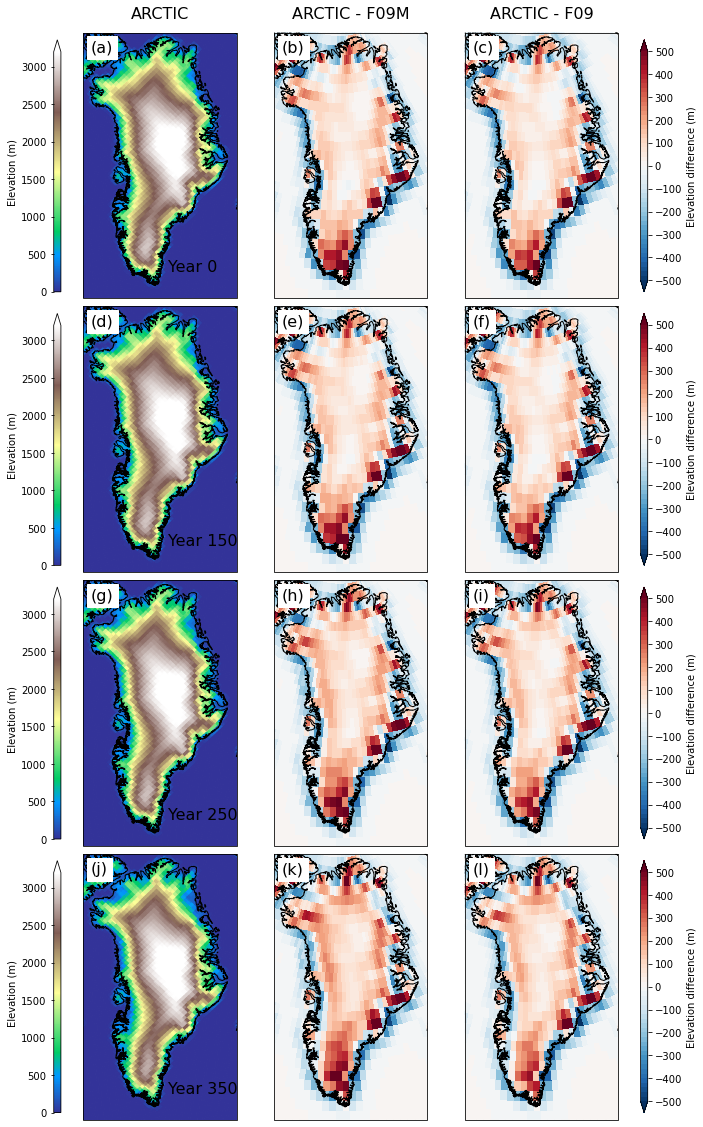

In [27]:
fig = plt.figure(figsize = (10,20))
gs=GridSpec(4,3)
plt.rcParams['axes.titlepad'] =14

size_label = 10
size_title = 16

# Modify values here
cmap1 = plt.cm.terrain

cmap2 = plt.cm.RdBu_r
bounds2 = np.arange(-500.,500.1,20.)
bounds2min = [-1000]
bounds2max = [1000]
norm2 = mpl.colors.BoundaryNorm(bounds2, cmap2.N, extend='both')
ticks2 = np.arange(-500.,500.1,100.)

#---------------------------------------------yr0----------------------------------------------------
ax0 = plt.subplot(gs[0], projection=polar_stereographic)
ax0.set_extent([-56.4, -29.6, 58, 84]) # Map bounds, [west, east, south, north]
ax0.coastlines(resolution='10m', zorder=7)
im0 = PolyCollection(ARCTIC_PHIS_yr0_verts, cmap=cmap1, transform=crs_ll,
                     **kwd_polycollection)
im0.set_array(ARCTIC_PHIS_yr0_var/g)
im0.set_clim(vmin=0, vmax=3200)
ax0.add_collection(im0)
plt.title('ARCTIC', fontsize=size_title, loc='center')
ax0.text(-620000, -840000, '(a)', fontsize=size_title, backgroundcolor='white', zorder=8)
ax0.text(210000, -3200000, 'Year 0', fontsize=size_title)

# colorbar
cbar_ax0 = fig.add_axes([0.1, 0.7, 0.01, 0.175])
cb0 = fig.colorbar(im0, cax=cbar_ax0, orientation='vertical', extend='max')
cb0.set_label(label='Elevation (m)', size=size_label)
cb0.ax.tick_params(labelsize=size_label)
cb0.ax.yaxis.set_ticks_position('left')
cb0.ax.yaxis.set_label_position('left')

ax1 = plt.subplot(gs[1], projection=polar_stereographic)
ax1.set_extent([-56.4, -29.6, 58, 84]) # Map bounds, [west, east, south, north]
ax1.coastlines(resolution='10m', zorder=7)
im1 = ax1.pcolormesh(f09_lon, f09_lat, ARCTIC_f09_PHIS_diff_yr0/g, transform=crs_ll, cmap=cmap2, norm=norm2)
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax1.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('ARCTIC - F09M', fontsize=size_title, loc='center')
ax1.text(-620000, -840000, '(b)', fontsize=size_title, backgroundcolor='white', zorder=8)

ax2 = plt.subplot(gs[2], projection=polar_stereographic)
ax2.set_extent([-56.4, -29.6, 58, 84]) # Map bounds, [west, east, south, north]
ax2.coastlines(resolution='10m', zorder=7)
im2 = ax2.pcolormesh(f09_lon, f09_lat, ARCTIC_f09_nohacks_PHIS_diff_yr0/g, transform=crs_ll, cmap=cmap2, norm=norm2)
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax2.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('ARCTIC - F09', fontsize=size_title, loc='center')
ax2.text(-620000, -840000, '(c)', fontsize=size_title, backgroundcolor='white', zorder=8)

# colorbar
cbar_ax2 = fig.add_axes([0.915, 0.7, 0.01, 0.175])
cb2 = fig.colorbar(im2, cax=cbar_ax2, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb2.set_label(label='Elevation difference (m)', size=size_label)
cb2.ax.tick_params(labelsize=10)

#---------------------------------------------yr150----------------------------------------------------
ax3 = plt.subplot(gs[3], projection=polar_stereographic)
ax3.set_extent([-56.4, -29.6, 58, 84]) # Map bounds, [west, east, south, north]
ax3.coastlines(resolution='10m', zorder=7)
im3 = PolyCollection(ARCTIC_PHIS_yr150_verts, cmap=cmap1, transform=crs_ll,
                     **kwd_polycollection)
im3.set_array(ARCTIC_PHIS_yr150_var/g)
im3.set_clim(vmin=0, vmax=3200)
ax3.add_collection(im3)
ax3.text(-620000, -840000, '(d)', fontsize=size_title, backgroundcolor='white', zorder=8)
ax3.text(210000, -3200000, 'Year 150', fontsize=size_title)

# colorbar
cbar_ax3 = fig.add_axes([0.1, 0.51, 0.01, 0.175])
cb3 = fig.colorbar(im3, cax=cbar_ax3, orientation='vertical', extend='max')
cb3.set_label(label='Elevation (m)', size=size_label)
cb3.ax.tick_params(labelsize=size_label)
cb3.ax.yaxis.set_ticks_position('left')
cb3.ax.yaxis.set_label_position('left')

ax4 = plt.subplot(gs[4], projection=polar_stereographic)
ax4.set_extent([-56.4, -29.6, 58, 84]) # Map bounds, [west, east, south, north]
ax4.coastlines(resolution='10m', zorder=7)
im4 = ax4.pcolormesh(f09_lon, f09_lat, ARCTIC_f09_PHIS_diff_yr150/g, transform=crs_ll, cmap=cmap2, norm=norm2)
ax4.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax4.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax4.text(-620000, -840000, '(e)', fontsize=size_title, backgroundcolor='white', zorder=8)

ax5 = plt.subplot(gs[5], projection=polar_stereographic)
ax5.set_extent([-56.4, -29.6, 58, 84]) # Map bounds, [west, east, south, north]
ax5.coastlines(resolution='10m', zorder=7)
im5 = ax5.pcolormesh(f09_lon, f09_lat, ARCTIC_f09_nohacks_PHIS_diff_yr150/g, transform=crs_ll, cmap=cmap2, norm=norm2)
ax5.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax5.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax5.text(-620000, -840000, '(f)', fontsize=size_title, backgroundcolor='white', zorder=8)

# colorbar
cbar_ax5 = fig.add_axes([0.915, 0.51, 0.01, 0.175])
cb5 = fig.colorbar(im5, cax=cbar_ax5, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb5.set_label(label='Elevation difference (m)', size=size_label)
cb5.ax.tick_params(labelsize=10)

#---------------------------------------------yr250----------------------------------------------------
ax6 = plt.subplot(gs[6], projection=polar_stereographic)
ax6.set_extent([-56.4, -29.6, 58, 84]) # Map bounds, [west, east, south, north]
ax6.coastlines(resolution='10m', zorder=7)
im6 = PolyCollection(ARCTIC_PHIS_yr250_verts, cmap=cmap1, transform=crs_ll,
                     **kwd_polycollection)
im6.set_array(ARCTIC_PHIS_yr250_var/g)
im6.set_clim(vmin=0, vmax=3200)
ax6.add_collection(im6)
ax6.text(-620000, -840000, '(g)', fontsize=size_title, backgroundcolor='white', zorder=8)
ax6.text(210000, -3200000, 'Year 250', fontsize=size_title)

# colorbar
cbar_ax6 = fig.add_axes([0.1, 0.32, 0.01, 0.175])
cb6 = fig.colorbar(im6, cax=cbar_ax6, orientation='vertical', extend='max')
cb6.set_label(label='Elevation (m)', size=size_label)
cb6.ax.tick_params(labelsize=size_label)
cb6.ax.yaxis.set_ticks_position('left')
cb6.ax.yaxis.set_label_position('left')

ax7 = plt.subplot(gs[7], projection=polar_stereographic)
ax7.set_extent([-56.4, -29.6, 58, 84]) # Map bounds, [west, east, south, north]
ax7.coastlines(resolution='10m', zorder=7)
im7 = ax7.pcolormesh(f09_lon, f09_lat, ARCTIC_f09_PHIS_diff_yr250/g, transform=crs_ll, cmap=cmap2, norm=norm2)
ax7.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax7.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax7.text(-620000, -840000, '(h)', fontsize=size_title, backgroundcolor='white', zorder=8)

ax8 = plt.subplot(gs[8], projection=polar_stereographic)
ax8.set_extent([-56.4, -29.6, 58, 84]) # Map bounds, [west, east, south, north]
ax8.coastlines(resolution='10m', zorder=7)
im8 = ax8.pcolormesh(f09_lon, f09_lat, ARCTIC_f09_nohacks_PHIS_diff_yr250/g, transform=crs_ll, cmap=cmap2, norm=norm2)
ax8.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax8.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax8.text(-620000, -840000, '(i)', fontsize=size_title, backgroundcolor='white', zorder=8)

# colorbar
cbar_ax8 = fig.add_axes([0.915, 0.32, 0.01, 0.175])
cb8 = fig.colorbar(im8, cax=cbar_ax8, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb8.set_label(label='Elevation difference (m)', size=size_label)
cb8.ax.tick_params(labelsize=10)

#---------------------------------------------yr350----------------------------------------------------
ax9 = plt.subplot(gs[9], projection=polar_stereographic)
ax9.set_extent([-56.4, -29.6, 58, 84]) # Map bounds, [west, east, south, north]
ax9.coastlines(resolution='10m', zorder=7)
im9 = PolyCollection(ARCTIC_PHIS_yr350_verts, cmap=cmap1, transform=crs_ll,
                     **kwd_polycollection)
im9.set_array(ARCTIC_PHIS_yr350_var/g)
im9.set_clim(vmin=0, vmax=3200)
ax9.add_collection(im9)
ax9.text(-620000, -840000, '(j)', fontsize=size_title, backgroundcolor='white', zorder=8)
ax9.text(210000, -3200000, 'Year 350', fontsize=size_title)

# colorbar
cbar_ax9 = fig.add_axes([0.1, 0.13, 0.01, 0.175])
cb9 = fig.colorbar(im9, cax=cbar_ax9, orientation='vertical', extend='max')
cb9.set_label(label='Elevation (m)', size=size_label)
cb9.ax.tick_params(labelsize=size_label)
cb9.ax.yaxis.set_ticks_position('left')
cb9.ax.yaxis.set_label_position('left')

ax10 = plt.subplot(gs[10], projection=polar_stereographic)
ax10.set_extent([-56.4, -29.6, 58, 84]) # Map bounds, [west, east, south, north]
ax10.coastlines(resolution='10m', zorder=7)
im10 = ax10.pcolormesh(f09_lon, f09_lat, ARCTIC_f09_PHIS_diff_yr350/g, transform=crs_ll, cmap=cmap2, norm=norm2)
ax10.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax10.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax10.text(-620000, -840000, '(k)', fontsize=size_title, backgroundcolor='white', zorder=8)

ax11 = plt.subplot(gs[11], projection=polar_stereographic)
ax11.set_extent([-56.4, -29.6, 58, 84]) # Map bounds, [west, east, south, north]
ax11.coastlines(resolution='10m', zorder=7)
im11 = ax11.pcolormesh(f09_lon, f09_lat, ARCTIC_f09_nohacks_PHIS_diff_yr350/g, transform=crs_ll, cmap=cmap2, norm=norm2)
ax11.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax11.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax11.text(-620000, -840000, '(l)', fontsize=size_title, backgroundcolor='white', zorder=8)

# colorbar
cbar_ax11 = fig.add_axes([0.915, 0.13, 0.01, 0.175])
cb11 = fig.colorbar(im11, cax=cbar_ax11, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb11.set_label(label='Elevation difference (m)', size=size_label)
cb11.ax.tick_params(labelsize=size_label)


plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.08,
                    hspace=0.03)

plt.savefig(home_dir+'dynamic_GrIS/github/plot/Map_elev_elev_diff_CAM.png', dpi = 300, bbox_inches = 'tight', facecolor='w', transparent = False)

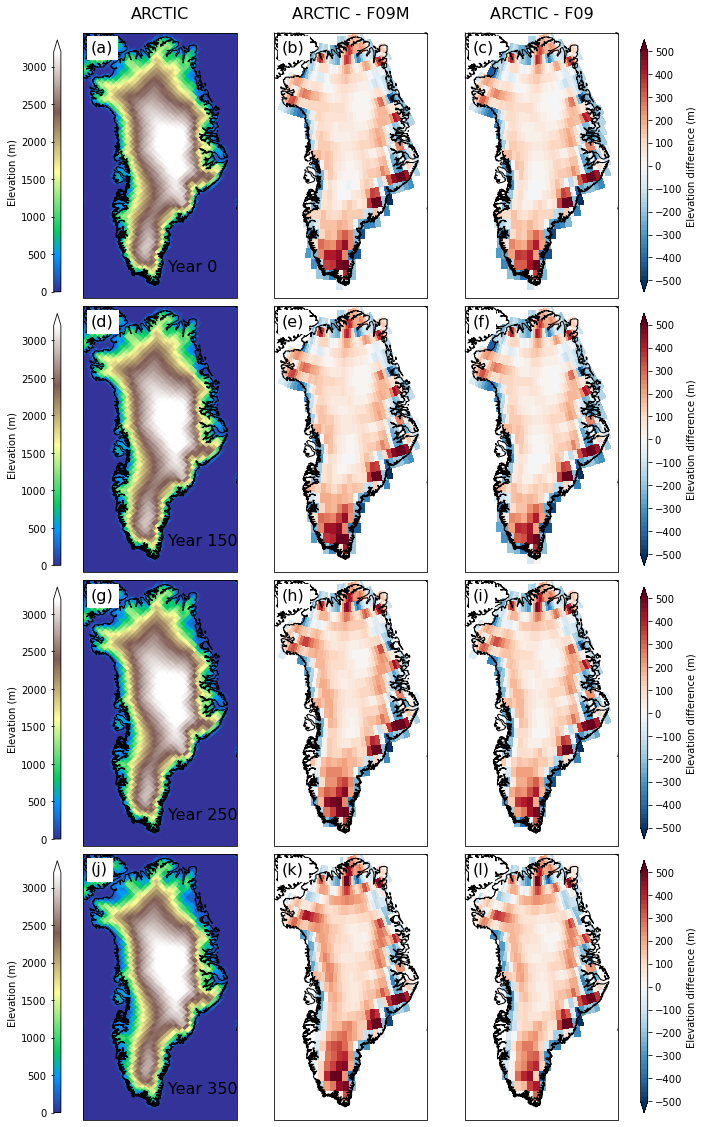

In [34]:
# With mask
fig = plt.figure(figsize = (10,20))
gs=GridSpec(4,3)
plt.rcParams['axes.titlepad'] =14

size_label = 10
size_title = 16

# Modify values here
cmap1 = plt.cm.terrain

cmap2 = plt.cm.RdBu_r
bounds2 = np.arange(-500.,500.1,20.)
bounds2min = [-1000]
bounds2max = [1000]
norm2 = mpl.colors.BoundaryNorm(bounds2, cmap2.N, extend='both')
ticks2 = np.arange(-500.,500.1,100.)

#---------------------------------------------yr0----------------------------------------------------
ax0 = plt.subplot(gs[0], projection=polar_stereographic)
ax0.set_extent([-56.4, -29.6, 58, 84]) # Map bounds, [west, east, south, north]
ax0.coastlines(resolution='10m', zorder=7)
im0 = PolyCollection(ARCTIC_PHIS_yr0_verts, cmap=cmap1, transform=crs_ll,
                     **kwd_polycollection)
im0.set_array(ARCTIC_PHIS_yr0_var/g)
im0.set_clim(vmin=0, vmax=3200)
ax0.add_collection(im0)
plt.title('ARCTIC', fontsize=size_title, loc='center')
ax0.text(-620000, -840000, '(a)', fontsize=size_title, backgroundcolor='white', zorder=8)
ax0.text(210000, -3200000, 'Year 0', fontsize=size_title)

# colorbar
cbar_ax0 = fig.add_axes([0.1, 0.7, 0.01, 0.175])
cb0 = fig.colorbar(im0, cax=cbar_ax0, orientation='vertical', extend='max')
cb0.set_label(label='Elevation (m)', size=size_label)
cb0.ax.tick_params(labelsize=size_label)
cb0.ax.yaxis.set_ticks_position('left')
cb0.ax.yaxis.set_label_position('left')

ax1 = plt.subplot(gs[1], projection=polar_stereographic)
ax1.set_extent([-56.4, -29.6, 58, 84]) # Map bounds, [west, east, south, north]
ax1.coastlines(resolution='10m', zorder=7)
im1 = ax1.pcolormesh(f09_lon, f09_lat, ARCTIC_f09_PHIS_diff_yr0.where(f09_GrIS_mask_yr0>0)/g, transform=crs_ll, cmap=cmap2, norm=norm2)
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax1.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('ARCTIC - F09M', fontsize=size_title, loc='center')
ax1.text(-620000, -840000, '(b)', fontsize=size_title, backgroundcolor='white', zorder=8)

ax2 = plt.subplot(gs[2], projection=polar_stereographic)
ax2.set_extent([-56.4, -29.6, 58, 84]) # Map bounds, [west, east, south, north]
ax2.coastlines(resolution='10m', zorder=7)
im2 = ax2.pcolormesh(f09_lon, f09_lat, ARCTIC_f09_nohacks_PHIS_diff_yr0.where(f09_nohacks_GrIS_mask_yr0>0)/g, transform=crs_ll, cmap=cmap2, norm=norm2)
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax2.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('ARCTIC - F09', fontsize=size_title, loc='center')
ax2.text(-620000, -840000, '(c)', fontsize=size_title, backgroundcolor='white', zorder=8)

# colorbar
cbar_ax2 = fig.add_axes([0.915, 0.7, 0.01, 0.175])
cb2 = fig.colorbar(im2, cax=cbar_ax2, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb2.set_label(label='Elevation difference (m)', size=size_label)
cb2.ax.tick_params(labelsize=10)

#---------------------------------------------yr150----------------------------------------------------
ax3 = plt.subplot(gs[3], projection=polar_stereographic)
ax3.set_extent([-56.4, -29.6, 58, 84]) # Map bounds, [west, east, south, north]
ax3.coastlines(resolution='10m', zorder=7)
im3 = PolyCollection(ARCTIC_PHIS_yr150_verts, cmap=cmap1, transform=crs_ll,
                     **kwd_polycollection)
im3.set_array(ARCTIC_PHIS_yr150_var/g)
im3.set_clim(vmin=0, vmax=3200)
ax3.add_collection(im3)
ax3.text(-620000, -840000, '(d)', fontsize=size_title, backgroundcolor='white', zorder=8)
ax3.text(210000, -3200000, 'Year 150', fontsize=size_title)

# colorbar
cbar_ax3 = fig.add_axes([0.1, 0.51, 0.01, 0.175])
cb3 = fig.colorbar(im3, cax=cbar_ax3, orientation='vertical', extend='max')
cb3.set_label(label='Elevation (m)', size=size_label)
cb3.ax.tick_params(labelsize=size_label)
cb3.ax.yaxis.set_ticks_position('left')
cb3.ax.yaxis.set_label_position('left')

ax4 = plt.subplot(gs[4], projection=polar_stereographic)
ax4.set_extent([-56.4, -29.6, 58, 84]) # Map bounds, [west, east, south, north]
ax4.coastlines(resolution='10m', zorder=7)
im4 = ax4.pcolormesh(f09_lon, f09_lat, ARCTIC_f09_PHIS_diff_yr150.where(f09_GrIS_mask_yr150>0)/g, transform=crs_ll, cmap=cmap2, norm=norm2)
ax4.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax4.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax4.text(-620000, -840000, '(e)', fontsize=size_title, backgroundcolor='white', zorder=8)

ax5 = plt.subplot(gs[5], projection=polar_stereographic)
ax5.set_extent([-56.4, -29.6, 58, 84]) # Map bounds, [west, east, south, north]
ax5.coastlines(resolution='10m', zorder=7)
im5 = ax5.pcolormesh(f09_lon, f09_lat, ARCTIC_f09_nohacks_PHIS_diff_yr150.where(f09_nohacks_GrIS_mask_yr150>0)/g, transform=crs_ll, cmap=cmap2, norm=norm2)
ax5.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax5.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax5.text(-620000, -840000, '(f)', fontsize=size_title, backgroundcolor='white', zorder=8)

# colorbar
cbar_ax5 = fig.add_axes([0.915, 0.51, 0.01, 0.175])
cb5 = fig.colorbar(im5, cax=cbar_ax5, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb5.set_label(label='Elevation difference (m)', size=size_label)
cb5.ax.tick_params(labelsize=10)

#---------------------------------------------yr250----------------------------------------------------
ax6 = plt.subplot(gs[6], projection=polar_stereographic)
ax6.set_extent([-56.4, -29.6, 58, 84]) # Map bounds, [west, east, south, north]
ax6.coastlines(resolution='10m', zorder=7)
im6 = PolyCollection(ARCTIC_PHIS_yr250_verts, cmap=cmap1, transform=crs_ll,
                     **kwd_polycollection)
im6.set_array(ARCTIC_PHIS_yr250_var/g)
im6.set_clim(vmin=0, vmax=3200)
ax6.add_collection(im6)
ax6.text(-620000, -840000, '(g)', fontsize=size_title, backgroundcolor='white', zorder=8)
ax6.text(210000, -3200000, 'Year 250', fontsize=size_title)

# colorbar
cbar_ax6 = fig.add_axes([0.1, 0.32, 0.01, 0.175])
cb6 = fig.colorbar(im6, cax=cbar_ax6, orientation='vertical', extend='max')
cb6.set_label(label='Elevation (m)', size=size_label)
cb6.ax.tick_params(labelsize=size_label)
cb6.ax.yaxis.set_ticks_position('left')
cb6.ax.yaxis.set_label_position('left')

ax7 = plt.subplot(gs[7], projection=polar_stereographic)
ax7.set_extent([-56.4, -29.6, 58, 84]) # Map bounds, [west, east, south, north]
ax7.coastlines(resolution='10m', zorder=7)
im7 = ax7.pcolormesh(f09_lon, f09_lat, ARCTIC_f09_PHIS_diff_yr250.where(f09_GrIS_mask_yr250>0)/g, transform=crs_ll, cmap=cmap2, norm=norm2)
ax7.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax7.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax7.text(-620000, -840000, '(h)', fontsize=size_title, backgroundcolor='white', zorder=8)

ax8 = plt.subplot(gs[8], projection=polar_stereographic)
ax8.set_extent([-56.4, -29.6, 58, 84]) # Map bounds, [west, east, south, north]
ax8.coastlines(resolution='10m', zorder=7)
im8 = ax8.pcolormesh(f09_lon, f09_lat, ARCTIC_f09_nohacks_PHIS_diff_yr250.where(f09_nohacks_GrIS_mask_yr250>0)/g, transform=crs_ll, cmap=cmap2, norm=norm2)
ax8.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax8.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax8.text(-620000, -840000, '(i)', fontsize=size_title, backgroundcolor='white', zorder=8)

# colorbar
cbar_ax8 = fig.add_axes([0.915, 0.32, 0.01, 0.175])
cb8 = fig.colorbar(im8, cax=cbar_ax8, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb8.set_label(label='Elevation difference (m)', size=size_label)
cb8.ax.tick_params(labelsize=10)

#---------------------------------------------yr350----------------------------------------------------
ax9 = plt.subplot(gs[9], projection=polar_stereographic)
ax9.set_extent([-56.4, -29.6, 58, 84]) # Map bounds, [west, east, south, north]
ax9.coastlines(resolution='10m', zorder=7)
im9 = PolyCollection(ARCTIC_PHIS_yr350_verts, cmap=cmap1, transform=crs_ll,
                     **kwd_polycollection)
im9.set_array(ARCTIC_PHIS_yr350_var/g)
im9.set_clim(vmin=0, vmax=3200)
ax9.add_collection(im9)
ax9.text(-620000, -840000, '(j)', fontsize=size_title, backgroundcolor='white', zorder=8)
ax9.text(210000, -3200000, 'Year 350', fontsize=size_title)

# colorbar
cbar_ax9 = fig.add_axes([0.1, 0.13, 0.01, 0.175])
cb9 = fig.colorbar(im9, cax=cbar_ax9, orientation='vertical', extend='max')
cb9.set_label(label='Elevation (m)', size=size_label)
cb9.ax.tick_params(labelsize=size_label)
cb9.ax.yaxis.set_ticks_position('left')
cb9.ax.yaxis.set_label_position('left')

ax10 = plt.subplot(gs[10], projection=polar_stereographic)
ax10.set_extent([-56.4, -29.6, 58, 84]) # Map bounds, [west, east, south, north]
ax10.coastlines(resolution='10m', zorder=7)
im10 = ax10.pcolormesh(f09_lon, f09_lat, ARCTIC_f09_PHIS_diff_yr350.where(f09_GrIS_mask_yr350>0)/g, transform=crs_ll, cmap=cmap2, norm=norm2)
ax10.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax10.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax10.text(-620000, -840000, '(k)', fontsize=size_title, backgroundcolor='white', zorder=8)

ax11 = plt.subplot(gs[11], projection=polar_stereographic)
ax11.set_extent([-56.4, -29.6, 58, 84]) # Map bounds, [west, east, south, north]
ax11.coastlines(resolution='10m', zorder=7)
im11 = ax11.pcolormesh(f09_lon, f09_lat, ARCTIC_f09_nohacks_PHIS_diff_yr350.where(f09_nohacks_GrIS_mask_yr350>0)/g, transform=crs_ll, cmap=cmap2, norm=norm2)
ax11.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax11.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax11.text(-620000, -840000, '(l)', fontsize=size_title, backgroundcolor='white', zorder=8)

# colorbar
cbar_ax11 = fig.add_axes([0.915, 0.13, 0.01, 0.175])
cb11 = fig.colorbar(im11, cax=cbar_ax11, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb11.set_label(label='Elevation difference (m)', size=size_label)
cb11.ax.tick_params(labelsize=size_label)


plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.08,
                    hspace=0.03)

plt.savefig(home_dir+'dynamic_GrIS/github/plot/Map_elev_elev_diff_CAM_masked.png', dpi = 300, bbox_inches = 'tight', facecolor='w', transparent = False)

#### $\Delta$ T2m / $\Delta$ z

##### Version 1: single year

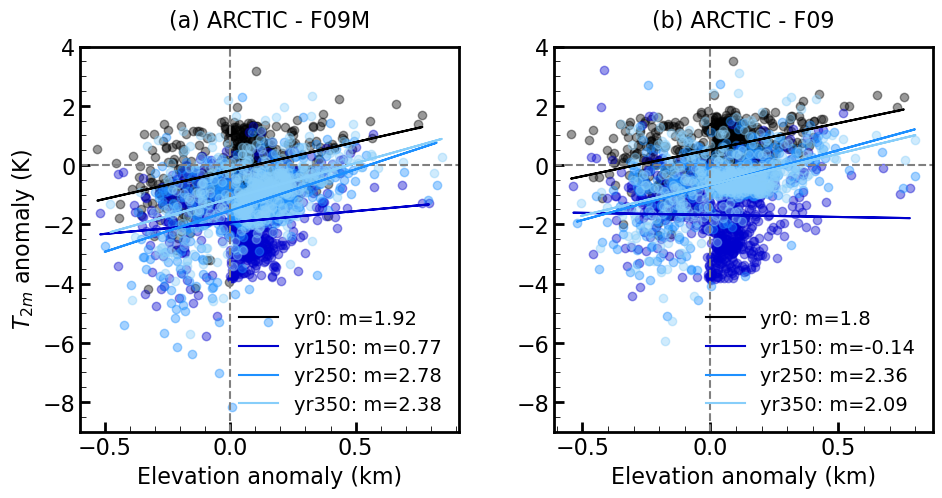

In [45]:
fig = plt.figure(figsize = (11,5))
gs=GridSpec(5,11)
plt.rcParams['axes.titlepad'] =14
plt.rcParams["axes.linewidth"] = 2  # set the value globally

size_tick = 16
size_label = 16
size_text = 16
size_legend = 14

# Ablation zone
ax1 = plt.subplot(gs[0:5,0:5])

plt.scatter(ARCTIC_f09_elev_diff_yr0_flatten/1e3, ARCTIC_f09_T2m_diff_yr0_flatten, color='black', alpha=0.4)
plt.scatter(ARCTIC_f09_elev_diff_yr150_flatten/1e3, ARCTIC_f09_T2m_diff_yr150_flatten, color='mediumblue', alpha=0.4)
plt.scatter(ARCTIC_f09_elev_diff_yr250_flatten/1e3, ARCTIC_f09_T2m_diff_yr250_flatten, color='dodgerblue', alpha=0.4)
plt.scatter(ARCTIC_f09_elev_diff_yr350_flatten/1e3, ARCTIC_f09_T2m_diff_yr350_flatten, color='lightskyblue', alpha=0.4)
plt.axvline(x=0., color='gray', linestyle='--')
plt.axhline(y=0., color='gray', linestyle='--')
plt.plot(ARCTIC_f09_elev_diff_yr0_flatten/1e3, ARCTIC_f09_elev_diff_yr0_flatten/1e3*slope_yr0m+intercept_yr0m, color='black', label='yr0: m='+str(round(slope_yr0m,2)))
plt.plot(ARCTIC_f09_elev_diff_yr150_flatten/1e3, ARCTIC_f09_elev_diff_yr150_flatten/1e3*slope_yr150m+intercept_yr150m, color='mediumblue', label='yr150: m='+str(round(slope_yr150m,2)))
plt.plot(ARCTIC_f09_elev_diff_yr250_flatten/1e3, ARCTIC_f09_elev_diff_yr250_flatten/1e3*slope_yr250m+intercept_yr250m, color='dodgerblue', label='yr250: m='+str(round(slope_yr250m,2)))
plt.plot(ARCTIC_f09_elev_diff_yr350_flatten/1e3, ARCTIC_f09_elev_diff_yr350_flatten/1e3*slope_yr350m+intercept_yr350m, color='lightskyblue', label='yr350: m='+str(round(slope_yr350m,2)))
plt.title('(a) ARCTIC - F09M', fontsize=size_text)

ax1.legend(loc = 'best', frameon = False, prop={'size':size_legend}, ncol=1)

ax1.set_ylim([-9, 4])
ax1.set_xlabel("Elevation anomaly (km)", fontsize=size_label)
ax1.set_ylabel("$T_{2m}$ anomaly (K)", fontsize=size_label)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which="major", length=7, width=2, direction="in")
ax1.tick_params(which="minor", length=4, direction="in")
ax1.tick_params(labelsize=size_tick)

# Accumulation zone
ax2 = plt.subplot(gs[0:5,6:11])

plt.scatter(ARCTIC_f09_nohacks_elev_diff_yr0_flatten/1e3, ARCTIC_f09_nohacks_T2m_diff_yr0_flatten, color='black', alpha=0.4)
plt.scatter(ARCTIC_f09_nohacks_elev_diff_yr150_flatten/1e3, ARCTIC_f09_nohacks_T2m_diff_yr150_flatten, color='mediumblue', alpha=0.4)
plt.scatter(ARCTIC_f09_nohacks_elev_diff_yr250_flatten/1e3, ARCTIC_f09_nohacks_T2m_diff_yr250_flatten, color='dodgerblue', alpha=0.4)
plt.scatter(ARCTIC_f09_nohacks_elev_diff_yr350_flatten/1e3, ARCTIC_f09_nohacks_T2m_diff_yr350_flatten, color='lightskyblue', alpha=0.4)
plt.axvline(x=0., color='gray', linestyle='--')
plt.axhline(y=0., color='gray', linestyle='--')
plt.plot(ARCTIC_f09_nohacks_elev_diff_yr0_flatten/1e3, ARCTIC_f09_nohacks_elev_diff_yr0_flatten/1e3*slope_yr0+intercept_yr0, color='black', label='yr0: m='+str(round(slope_yr0,2)))
plt.plot(ARCTIC_f09_nohacks_elev_diff_yr150_flatten/1e3, ARCTIC_f09_nohacks_elev_diff_yr150_flatten/1e3*slope_yr150+intercept_yr150, color='mediumblue', label='yr150: m='+str(round(slope_yr150,2)))
plt.plot(ARCTIC_f09_nohacks_elev_diff_yr250_flatten/1e3, ARCTIC_f09_nohacks_elev_diff_yr250_flatten/1e3*slope_yr250+intercept_yr250, color='dodgerblue', label='yr250: m='+str(round(slope_yr250,2)))
plt.plot(ARCTIC_f09_nohacks_elev_diff_yr350_flatten/1e3, ARCTIC_f09_nohacks_elev_diff_yr350_flatten/1e3*slope_yr350+intercept_yr350, color='lightskyblue', label='yr350: m='+str(round(slope_yr350,2)))
plt.title('(b) ARCTIC - F09', fontsize=size_text)

ax2.legend(loc = 'best', frameon = False, prop={'size':size_legend}, ncol=1)

ax2.set_ylim([-9, 4])
ax2.set_xlabel("Elevation anomaly (km)", fontsize=size_label)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(which="major", length=7, width=2, direction="in")
ax2.tick_params(which="minor", length=4, direction="in")
ax2.tick_params(labelsize=size_tick)

plt.subplots_adjust(wspace=0.25)
plt.savefig(
    home_dir + "2022-VR-dynamic-GrIS/github/plot/Scatter_dT2m_delev.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="w",
    transparent=False,
)  #

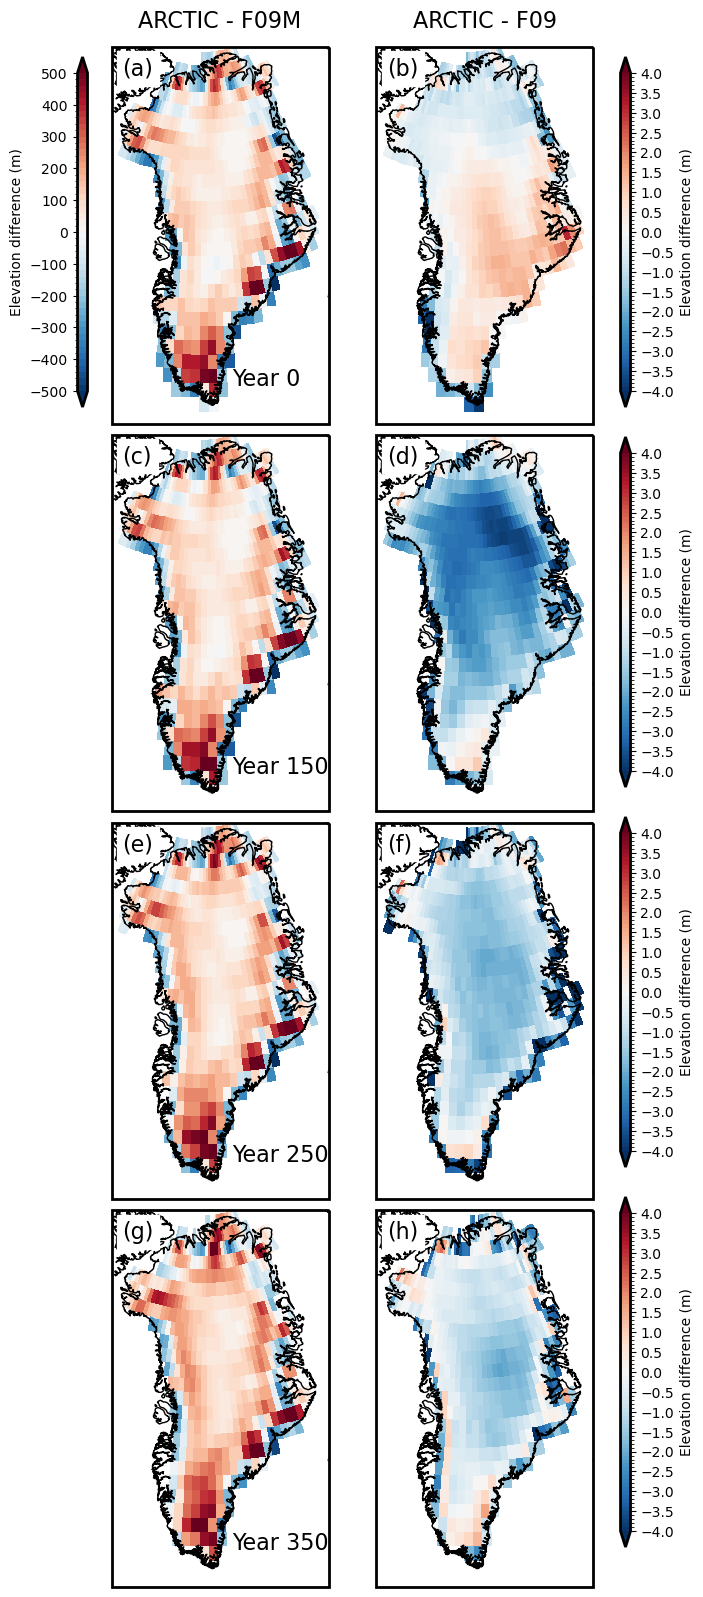

In [55]:
# With mask
fig = plt.figure(figsize = (10,20))
gs=GridSpec(4,3)
plt.rcParams['axes.titlepad'] =14

size_label = 10
size_title = 16

# Modify values here
cmap1 = plt.cm.RdBu_r
bounds1 = np.arange(-500.,500.1,20.)
bounds1min = [-1000]
bounds1max = [1000]
norm1 = mpl.colors.BoundaryNorm(bounds1, cmap1.N, extend='both')
ticks1 = np.arange(-500.,500.1,100.)

cmap2 = plt.cm.RdBu_r
bounds2 = np.arange(-4.,4.1,0.1)
bounds2min = [-100]
bounds2max = [100]
norm2 = mpl.colors.BoundaryNorm(bounds2, cmap2.N, extend='both')
ticks2 = np.arange(-4.,4.1,0.5)

#---------------------------------------------yr0----------------------------------------------------
ax1 = plt.subplot(gs[1], projection=polar_stereographic)
ax1.set_extent([-56.4, -29.6, 58, 84]) # Map bounds, [west, east, south, north]
ax1.coastlines(resolution='10m', zorder=7)
im1 = ax1.pcolormesh(f09_lon, f09_lat, ARCTIC_f09_elev_diff_yr0, transform=crs_ll, cmap=cmap1, norm=norm1)
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax1.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('ARCTIC - F09M', fontsize=size_title, loc='center')
ax1.text(-620000, -840000, '(a)', fontsize=size_title, backgroundcolor='white', zorder=8)
ax1.text(210000, -3200000, 'Year 0', fontsize=size_title)

# colorbar
cbar_ax1 = fig.add_axes([0.37, 0.7, 0.01, 0.175])
cb1 = fig.colorbar(im1, cax=cbar_ax1, orientation='vertical', boundaries=bounds1min+bounds1+bounds1max, ticks=ticks1)
cb1.set_label(label='Elevation difference (m)', size=size_label)
cb1.ax.tick_params(labelsize=size_label)
cb1.ax.yaxis.set_ticks_position('left')
cb1.ax.yaxis.set_label_position('left')

ax2 = plt.subplot(gs[2], projection=polar_stereographic)
ax2.set_extent([-56.4, -29.6, 58, 84]) # Map bounds, [west, east, south, north]
ax2.coastlines(resolution='10m', zorder=7)
im2 = ax2.pcolormesh(f09_lon, f09_lat, ARCTIC_f09_T2m_diff_yr0, transform=crs_ll, cmap=cmap2, norm=norm2)
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax2.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('ARCTIC - F09', fontsize=size_title, loc='center')
ax2.text(-620000, -840000, '(b)', fontsize=size_title, backgroundcolor='white', zorder=8)

# colorbar
cbar_ax2 = fig.add_axes([0.913, 0.7, 0.01, 0.175])
cb2 = fig.colorbar(im2, cax=cbar_ax2, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb2.set_label(label='Elevation difference (m)', size=size_label)
cb2.ax.tick_params(labelsize=size_label)

#---------------------------------------------yr150----------------------------------------------------
ax4 = plt.subplot(gs[4], projection=polar_stereographic)
ax4.set_extent([-56.4, -29.6, 58, 84]) # Map bounds, [west, east, south, north]
ax4.coastlines(resolution='10m', zorder=7)
im4 = ax4.pcolormesh(f09_lon, f09_lat, ARCTIC_f09_elev_diff_yr150, transform=crs_ll, cmap=cmap1, norm=norm1)
ax4.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax4.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax4.text(-620000, -840000, '(c)', fontsize=size_title, backgroundcolor='white', zorder=8)
ax4.text(210000, -3200000, 'Year 150', fontsize=size_title)

ax5 = plt.subplot(gs[5], projection=polar_stereographic)
ax5.set_extent([-56.4, -29.6, 58, 84]) # Map bounds, [west, east, south, north]
ax5.coastlines(resolution='10m', zorder=7)
im5 = ax5.pcolormesh(f09_lon, f09_lat, ARCTIC_f09_T2m_diff_yr150, transform=crs_ll, cmap=cmap2, norm=norm2)
ax5.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax5.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax5.text(-620000, -840000, '(d)', fontsize=size_title, backgroundcolor='white', zorder=8)

# colorbar
cbar_ax5 = fig.add_axes([0.913, 0.51, 0.01, 0.175])
cb5 = fig.colorbar(im5, cax=cbar_ax5, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb5.set_label(label='Elevation difference (m)', size=size_label)
cb5.ax.tick_params(labelsize=10)

#---------------------------------------------yr250----------------------------------------------------
ax7 = plt.subplot(gs[7], projection=polar_stereographic)
ax7.set_extent([-56.4, -29.6, 58, 84]) # Map bounds, [west, east, south, north]
ax7.coastlines(resolution='10m', zorder=7)
im7 = ax7.pcolormesh(f09_lon, f09_lat, ARCTIC_f09_elev_diff_yr250, transform=crs_ll, cmap=cmap1, norm=norm1)
ax7.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax7.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax7.text(-620000, -840000, '(e)', fontsize=size_title, backgroundcolor='white', zorder=8)
ax7.text(210000, -3200000, 'Year 250', fontsize=size_title)

ax8 = plt.subplot(gs[8], projection=polar_stereographic)
ax8.set_extent([-56.4, -29.6, 58, 84]) # Map bounds, [west, east, south, north]
ax8.coastlines(resolution='10m', zorder=7)
im8 = ax8.pcolormesh(f09_lon, f09_lat, ARCTIC_f09_T2m_diff_yr250, transform=crs_ll, cmap=cmap2, norm=norm2)
ax8.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax8.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax8.text(-620000, -840000, '(f)', fontsize=size_title, backgroundcolor='white', zorder=8)

# colorbar
cbar_ax8 = fig.add_axes([0.913, 0.32, 0.01, 0.175])
cb8 = fig.colorbar(im8, cax=cbar_ax8, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb8.set_label(label='Elevation difference (m)', size=size_label)
cb8.ax.tick_params(labelsize=10)

#---------------------------------------------yr350----------------------------------------------------
ax10 = plt.subplot(gs[10], projection=polar_stereographic)
ax10.set_extent([-56.4, -29.6, 58, 84]) # Map bounds, [west, east, south, north]
ax10.coastlines(resolution='10m', zorder=7)
im10 = ax10.pcolormesh(f09_lon, f09_lat, ARCTIC_f09_elev_diff_yr350, transform=crs_ll, cmap=cmap1, norm=norm1)
ax10.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax10.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax10.text(-620000, -840000, '(g)', fontsize=size_title, backgroundcolor='white', zorder=8)
ax10.text(210000, -3200000, 'Year 350', fontsize=size_title)

ax11 = plt.subplot(gs[11], projection=polar_stereographic)
ax11.set_extent([-56.4, -29.6, 58, 84]) # Map bounds, [west, east, south, north]
ax11.coastlines(resolution='10m', zorder=7)
im11 = ax11.pcolormesh(f09_lon, f09_lat, ARCTIC_f09_T2m_diff_yr350, transform=crs_ll, cmap=cmap2, norm=norm2)
ax11.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax11.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax11.text(-620000, -840000, '(h)', fontsize=size_title, backgroundcolor='white', zorder=8)

# colorbar
cbar_ax11 = fig.add_axes([0.913, 0.13, 0.01, 0.175])
cb11 = fig.colorbar(im11, cax=cbar_ax11, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb11.set_label(label='Elevation difference (m)', size=size_label)
cb11.ax.tick_params(labelsize=size_label)


plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.08,
                    hspace=0.03)

#plt.savefig(home_dir+'dynamic_GrIS/github/plot/Map_elev_elev_diff_CAM_masked.png', dpi = 300, bbox_inches = 'tight', facecolor='w', transparent = False)

##### Version 2: 20-year period

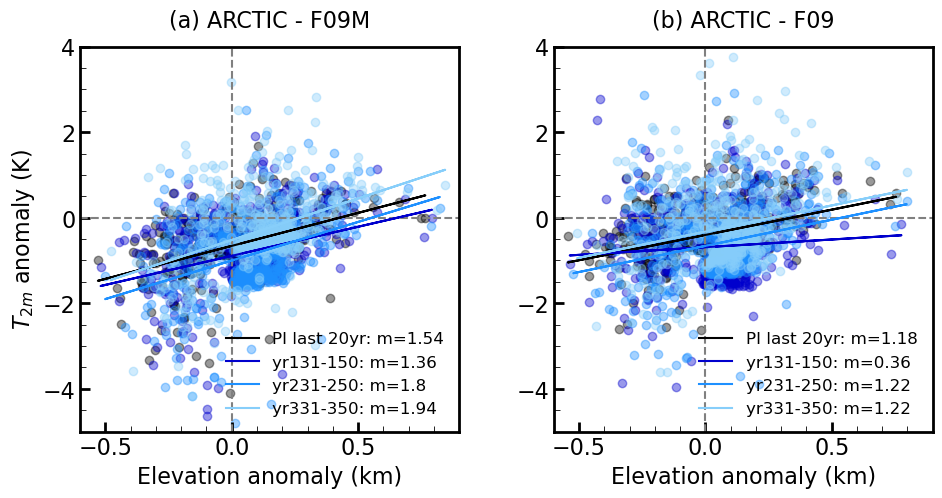

In [54]:
fig = plt.figure(figsize = (11,5))
gs=GridSpec(5,11)
plt.rcParams['axes.titlepad'] =14
plt.rcParams["axes.linewidth"] = 2  # set the value globally

size_tick = 16
size_label = 16
size_text = 16
size_legend = 12

# Ablation zone
ax1 = plt.subplot(gs[0:5,0:5])

plt.scatter(ARCTIC_f09_elev_diff_yr0_flatten/1e3, ARCTIC_f09_T2m_diff_yr0_flatten, color='black', alpha=0.4)
plt.scatter(ARCTIC_f09_elev_diff_yr150_flatten/1e3, ARCTIC_f09_T2m_diff_yr150_flatten, color='mediumblue', alpha=0.4)
plt.scatter(ARCTIC_f09_elev_diff_yr250_flatten/1e3, ARCTIC_f09_T2m_diff_yr250_flatten, color='dodgerblue', alpha=0.4)
plt.scatter(ARCTIC_f09_elev_diff_yr350_flatten/1e3, ARCTIC_f09_T2m_diff_yr350_flatten, color='lightskyblue', alpha=0.4)
plt.axvline(x=0., color='gray', linestyle='--')
plt.axhline(y=0., color='gray', linestyle='--')
plt.plot(ARCTIC_f09_elev_diff_yr0_flatten/1e3, ARCTIC_f09_elev_diff_yr0_flatten/1e3*slope_yr0m+intercept_yr0m, color='black', label='PI last 20yr: m='+str(round(slope_yr0m,2)))
plt.plot(ARCTIC_f09_elev_diff_yr150_flatten/1e3, ARCTIC_f09_elev_diff_yr150_flatten/1e3*slope_yr150m+intercept_yr150m, color='mediumblue', label='yr131-150: m='+str(round(slope_yr150m,2)))
plt.plot(ARCTIC_f09_elev_diff_yr250_flatten/1e3, ARCTIC_f09_elev_diff_yr250_flatten/1e3*slope_yr250m+intercept_yr250m, color='dodgerblue', label='yr231-250: m='+str(round(slope_yr250m,2)))
plt.plot(ARCTIC_f09_elev_diff_yr350_flatten/1e3, ARCTIC_f09_elev_diff_yr350_flatten/1e3*slope_yr350m+intercept_yr350m, color='lightskyblue', label='yr331-350: m='+str(round(slope_yr350m,2)))
plt.title('(a) ARCTIC - F09M', fontsize=size_text)

ax1.legend(loc = 'lower right', frameon = False, prop={'size':size_legend}, ncol=1)

ax1.set_xlim([-0.6, 0.9])
ax1.set_ylim([-5, 4])
ax1.set_xlabel("Elevation anomaly (km)", fontsize=size_label)
ax1.set_ylabel("$T_{2m}$ anomaly (K)", fontsize=size_label)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which="major", length=7, width=2, direction="in")
ax1.tick_params(which="minor", length=4, direction="in")
ax1.tick_params(labelsize=size_tick)

# Accumulation zone
ax2 = plt.subplot(gs[0:5,6:11])

plt.scatter(ARCTIC_f09_nohacks_elev_diff_yr0_flatten/1e3, ARCTIC_f09_nohacks_T2m_diff_yr0_flatten, color='black', alpha=0.4)
plt.scatter(ARCTIC_f09_nohacks_elev_diff_yr150_flatten/1e3, ARCTIC_f09_nohacks_T2m_diff_yr150_flatten, color='mediumblue', alpha=0.4)
plt.scatter(ARCTIC_f09_nohacks_elev_diff_yr250_flatten/1e3, ARCTIC_f09_nohacks_T2m_diff_yr250_flatten, color='dodgerblue', alpha=0.4)
plt.scatter(ARCTIC_f09_nohacks_elev_diff_yr350_flatten/1e3, ARCTIC_f09_nohacks_T2m_diff_yr350_flatten, color='lightskyblue', alpha=0.4)
plt.axvline(x=0., color='gray', linestyle='--')
plt.axhline(y=0., color='gray', linestyle='--')
plt.plot(ARCTIC_f09_nohacks_elev_diff_yr0_flatten/1e3, ARCTIC_f09_nohacks_elev_diff_yr0_flatten/1e3*slope_yr0+intercept_yr0, color='black', label='PI last 20yr: m='+str(round(slope_yr0,2)))
plt.plot(ARCTIC_f09_nohacks_elev_diff_yr150_flatten/1e3, ARCTIC_f09_nohacks_elev_diff_yr150_flatten/1e3*slope_yr150+intercept_yr150, color='mediumblue', label='yr131-150: m='+str(round(slope_yr150,2)))
plt.plot(ARCTIC_f09_nohacks_elev_diff_yr250_flatten/1e3, ARCTIC_f09_nohacks_elev_diff_yr250_flatten/1e3*slope_yr250+intercept_yr250, color='dodgerblue', label='yr231-250: m='+str(round(slope_yr250,2)))
plt.plot(ARCTIC_f09_nohacks_elev_diff_yr350_flatten/1e3, ARCTIC_f09_nohacks_elev_diff_yr350_flatten/1e3*slope_yr350+intercept_yr350, color='lightskyblue', label='yr331-350: m='+str(round(slope_yr350,2)))
plt.title('(b) ARCTIC - F09', fontsize=size_text)

ax2.legend(loc = 'lower right', frameon = False, prop={'size':size_legend}, ncol=1)

ax2.set_xlim([-0.6, 0.9])
ax2.set_ylim([-5, 4])
ax2.set_xlabel("Elevation anomaly (km)", fontsize=size_label)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(which="major", length=7, width=2, direction="in")
ax2.tick_params(which="minor", length=4, direction="in")
ax2.tick_params(labelsize=size_tick)

plt.subplots_adjust(wspace=0.25)
plt.savefig(
    home_dir + "2022-VR-dynamic-GrIS/github/plot/Scatter_dT2m_delev_20yrmean.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="w",
    transparent=False,
)  #

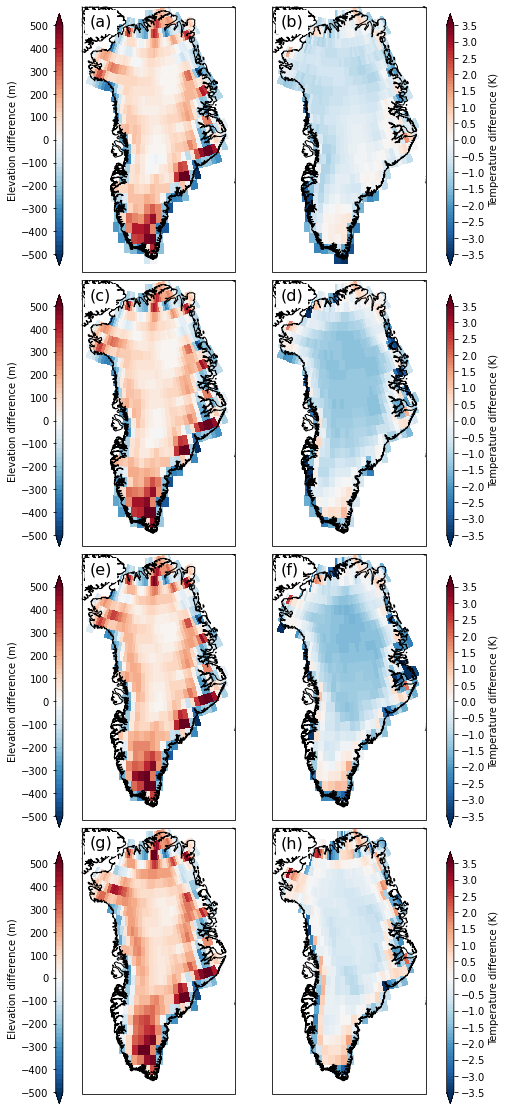

In [32]:
# Elevation and T2m difference fields between ARCTIC and F09M
fig = plt.figure(figsize = (10,20))
gs=GridSpec(4,3)
plt.rcParams['axes.titlepad'] =14

size_label = 10
size_title = 16

# Modify values here
cmap1 = plt.cm.RdBu_r
bounds1 = np.arange(-500.,500.1,20.)
bounds1min = [-1000]
bounds1max = [1000]
norm1 = mpl.colors.BoundaryNorm(bounds1, cmap1.N, extend='both')
ticks1 = np.arange(-500.,500.1,100.)

cmap2 = plt.cm.RdBu_r
bounds2 = np.arange(-3.5,3.51,0.1)
bounds2min = [-100]
bounds2max = [100]
norm2 = mpl.colors.BoundaryNorm(bounds2, cmap2.N, extend='both')
ticks2 = np.arange(-3.5,3.51,0.5)

#---------------------------------------------yr0----------------------------------------------------
ax1 = plt.subplot(gs[1], projection=polar_stereographic)
ax1.set_extent([-56.4, -29.6, 58, 84]) # Map bounds, [west, east, south, north]
ax1.coastlines(resolution='10m', zorder=7)
im1 = ax1.pcolormesh(f09_lon, f09_lat, ARCTIC_f09_elev_diff_yr0, transform=crs_ll, cmap=cmap1, norm=norm1)
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax1.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax1.text(-620000, -840000, '(a)', fontsize=size_title, backgroundcolor='white', zorder=8)
#ax1.text(210000, -3200000, 'Year 0', fontsize=size_title)

# colorbar
cbar_ax1 = fig.add_axes([0.37, 0.7, 0.01, 0.175])
cb1 = fig.colorbar(im1, cax=cbar_ax1, orientation='vertical', boundaries=bounds1min+bounds1+bounds1max, ticks=ticks1)
cb1.set_label(label='Elevation difference (m)', size=size_label)
cb1.ax.tick_params(labelsize=size_label)
cb1.ax.yaxis.set_ticks_position('left')
cb1.ax.yaxis.set_label_position('left')

ax2 = plt.subplot(gs[2], projection=polar_stereographic)
ax2.set_extent([-56.4, -29.6, 58, 84]) # Map bounds, [west, east, south, north]
ax2.coastlines(resolution='10m', zorder=7)
im2 = ax2.pcolormesh(f09_lon, f09_lat, ARCTIC_f09_T2m_diff_yr0, transform=crs_ll, cmap=cmap2, norm=norm2)
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax2.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax2.text(-620000, -840000, '(b)', fontsize=size_title, backgroundcolor='white', zorder=8)

# colorbar
cbar_ax2 = fig.add_axes([0.913, 0.7, 0.01, 0.175])
cb2 = fig.colorbar(im2, cax=cbar_ax2, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb2.set_label(label='Temperature difference (K)', size=size_label)
cb2.ax.tick_params(labelsize=size_label)

#---------------------------------------------yr150----------------------------------------------------
ax4 = plt.subplot(gs[4], projection=polar_stereographic)
ax4.set_extent([-56.4, -29.6, 58, 84]) # Map bounds, [west, east, south, north]
ax4.coastlines(resolution='10m', zorder=7)
im4 = ax4.pcolormesh(f09_lon, f09_lat, ARCTIC_f09_elev_diff_yr150, transform=crs_ll, cmap=cmap1, norm=norm1)
ax4.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax4.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax4.text(-620000, -840000, '(c)', fontsize=size_title, backgroundcolor='white', zorder=8)
#ax4.text(210000, -3200000, 'Year 150', fontsize=size_title)

# colorbar
cbar_ax4 = fig.add_axes([0.37, 0.505, 0.01, 0.175])
cb4 = fig.colorbar(im4, cax=cbar_ax4, orientation='vertical', boundaries=bounds1min+bounds1+bounds1max, ticks=ticks1)
cb4.set_label(label='Elevation difference (m)', size=size_label)
cb4.ax.tick_params(labelsize=size_label)
cb4.ax.yaxis.set_ticks_position('left')
cb4.ax.yaxis.set_label_position('left')

ax5 = plt.subplot(gs[5], projection=polar_stereographic)
ax5.set_extent([-56.4, -29.6, 58, 84]) # Map bounds, [west, east, south, north]
ax5.coastlines(resolution='10m', zorder=7)
im5 = ax5.pcolormesh(f09_lon, f09_lat, ARCTIC_f09_T2m_diff_yr150, transform=crs_ll, cmap=cmap2, norm=norm2)
ax5.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax5.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax5.text(-620000, -840000, '(d)', fontsize=size_title, backgroundcolor='white', zorder=8)

# colorbar
cbar_ax5 = fig.add_axes([0.913, 0.505, 0.01, 0.175])
cb5 = fig.colorbar(im5, cax=cbar_ax5, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb5.set_label(label='Temperature difference (K)', size=size_label)
cb5.ax.tick_params(labelsize=10)

#---------------------------------------------yr250----------------------------------------------------
ax7 = plt.subplot(gs[7], projection=polar_stereographic)
ax7.set_extent([-56.4, -29.6, 58, 84]) # Map bounds, [west, east, south, north]
ax7.coastlines(resolution='10m', zorder=7)
im7 = ax7.pcolormesh(f09_lon, f09_lat, ARCTIC_f09_elev_diff_yr250, transform=crs_ll, cmap=cmap1, norm=norm1)
ax7.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax7.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax7.text(-620000, -840000, '(e)', fontsize=size_title, backgroundcolor='white', zorder=8)
#ax7.text(210000, -3200000, 'Year 250', fontsize=size_title)

# colorbar
cbar_ax7 = fig.add_axes([0.37, 0.31, 0.01, 0.175])
cb7 = fig.colorbar(im7, cax=cbar_ax7, orientation='vertical', boundaries=bounds1min+bounds1+bounds1max, ticks=ticks1)
cb7.set_label(label='Elevation difference (m)', size=size_label)
cb7.ax.tick_params(labelsize=size_label)
cb7.ax.yaxis.set_ticks_position('left')
cb7.ax.yaxis.set_label_position('left')

ax8 = plt.subplot(gs[8], projection=polar_stereographic)
ax8.set_extent([-56.4, -29.6, 58, 84]) # Map bounds, [west, east, south, north]
ax8.coastlines(resolution='10m', zorder=7)
im8 = ax8.pcolormesh(f09_lon, f09_lat, ARCTIC_f09_T2m_diff_yr250, transform=crs_ll, cmap=cmap2, norm=norm2)
ax8.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax8.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax8.text(-620000, -840000, '(f)', fontsize=size_title, backgroundcolor='white', zorder=8)

# colorbar
cbar_ax8 = fig.add_axes([0.913, 0.31, 0.01, 0.175])
cb8 = fig.colorbar(im8, cax=cbar_ax8, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb8.set_label(label='Temperature difference (K)', size=size_label)
cb8.ax.tick_params(labelsize=10)

#---------------------------------------------yr350----------------------------------------------------
ax10 = plt.subplot(gs[10], projection=polar_stereographic)
ax10.set_extent([-56.4, -29.6, 58, 84]) # Map bounds, [west, east, south, north]
ax10.coastlines(resolution='10m', zorder=7)
im10 = ax10.pcolormesh(f09_lon, f09_lat, ARCTIC_f09_elev_diff_yr350, transform=crs_ll, cmap=cmap1, norm=norm1)
ax10.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax10.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax10.text(-620000, -840000, '(g)', fontsize=size_title, backgroundcolor='white', zorder=8)
#ax10.text(210000, -3200000, 'Year 350', fontsize=size_title)

# colorbar
cbar_ax10 = fig.add_axes([0.37, 0.118, 0.01, 0.175])
cb10 = fig.colorbar(im10, cax=cbar_ax10, orientation='vertical', boundaries=bounds1min+bounds1+bounds1max, ticks=ticks1)
cb10.set_label(label='Elevation difference (m)', size=size_label)
cb10.ax.tick_params(labelsize=size_label)
cb10.ax.yaxis.set_ticks_position('left')
cb10.ax.yaxis.set_label_position('left')

ax11 = plt.subplot(gs[11], projection=polar_stereographic)
ax11.set_extent([-56.4, -29.6, 58, 84]) # Map bounds, [west, east, south, north]
ax11.coastlines(resolution='10m', zorder=7)
im11 = ax11.pcolormesh(f09_lon, f09_lat, ARCTIC_f09_T2m_diff_yr350, transform=crs_ll, cmap=cmap2, norm=norm2)
ax11.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax11.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax11.text(-620000, -840000, '(h)', fontsize=size_title, backgroundcolor='white', zorder=8)

# colorbar
cbar_ax11 = fig.add_axes([0.913, 0.118, 0.01, 0.175])
cb11 = fig.colorbar(im11, cax=cbar_ax11, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb11.set_label(label='Temperature difference (K)', size=size_label)
cb11.ax.tick_params(labelsize=size_label)


plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.08,
                    hspace=0.03)

plt.savefig(home_dir+'2022-VR-dynamic-GrIS/github/plot/Map_elev_diff_T2m_diff_20yrmean.png', dpi = 300, bbox_inches = 'tight', facecolor='w', transparent = False)

## 3. CISM topography remapped to CAM grid <a class="anchor" id="third-bullet"></a>

### Get data

In [9]:
F09M_yr0_stopg = BG7_topg_yearly[148] + BG7_thk_yearly[148]
F09_yr0_stopg = F09_piControl_topg_yearly[-1] + F09_piControl_thk_yearly[-1]
ARCTIC_yr0_stopg = ARCTIC_piControl_p4_topg_yearly[-1] + ARCTIC_piControl_p4_thk_yearly[-1]

In [11]:
F09M_1pctCO2_4xext_stopg = F09M_1pctCO2_4xext_topg_yearly + F09M_1pctCO2_4xext_thk_yearly
F09_1pctCO2_4xext_stopg = F09_1pctCO2_4xext_topg_yearly + F09_1pctCO2_4xext_thk_yearly
ARCTIC_1pctCO2_4xext_stopg = ARCTIC_1pctCO2_4xext_topg_yearly + ARCTIC_1pctCO2_4xext_thk_yearly

In [12]:
F09M_yr0_stopg_masked = BG7_ice_sheet_mask_yearly[148].where(BG7_ice_sheet_mask_yearly[148] > 0) * F09M_yr0_stopg
F09_yr0_stopg_masked = F09_piControl_ice_sheet_mask_yearly[-1].where(F09_piControl_ice_sheet_mask_yearly[-1] > 0) * F09_yr0_stopg
ARCTIC_yr0_stopg_masked = ARCTIC_piControl_p4_ice_sheet_mask_yearly[-1].where(ARCTIC_piControl_p4_ice_sheet_mask_yearly[-1] > 0) * ARCTIC_yr0_stopg

In [13]:
F09M_1pctCO2_4xext_stopg_masked = F09M_1pctCO2_4xext_ice_sheet_mask_yearly.where(F09M_1pctCO2_4xext_ice_sheet_mask_yearly > 0) * F09M_1pctCO2_4xext_stopg
F09_1pctCO2_4xext_stopg_masked = F09_1pctCO2_4xext_ice_sheet_mask_yearly.where(F09_1pctCO2_4xext_ice_sheet_mask_yearly > 0) * F09_1pctCO2_4xext_stopg
ARCTIC_1pctCO2_4xext_stopg_masked = ARCTIC_1pctCO2_4xext_ice_sheet_mask_yearly.where(ARCTIC_1pctCO2_4xext_ice_sheet_mask_yearly > 0) * ARCTIC_1pctCO2_4xext_stopg

### Regrid

#### Area

In [14]:
Re = 6371.22 * 1e3 #[m]

f09_mask_file3 = '/glade/p/cesmdata/cseg/inputdata/share/domains/domain.lnd.fv0.9x1.25_gx1v7.151020.nc'
f09_area = xr.open_dataset(f09_mask_file3)['area'] #[Radian2]
f09_area_Arctic = f09_area.where(f09_area.yc > 60).values * Re**2
f09_area = f09_area.values * Re**2

ARCTIC_mask_file3 = '/glade/p/cesmdata/cseg/inputdata/share/domains/domain.lnd.ne0np4.ARCTIC.ne30x4_tx0.1v2.200626.nc'
ARCTIC_area = xr.open_dataset(ARCTIC_mask_file3)['area'] #[Radian2]
ARCTIC_area_Arctic = ARCTIC_area.where(ARCTIC_area.yc > 60).values * Re**2
ARCTIC_area = ARCTIC_area.values * Re**2

ARCTIC_lat = xr.open_dataset(ARCTIC_mask_file3).yc[0,:].values

#### Scrip file

In [15]:
# Scrip files (contains grid information)
scrip_fname_ARCTIC = home_dir + 'data/gridfile/ne0ARCTICne30x4_scrip_191212.nc'
ARCTIC_scrip = xr.open_dataset(scrip_fname_ARCTIC)

scrip_fname_f09 = home_dir + 'data/gridfile/fv0.9x1.25_scrip_141008.nc'
f09_scrip = xr.open_dataset(scrip_fname_f09)

scrip_fname_CISM = '/glade/campaign/cesm/cesmdata/cseg/inputdata/glc/cism/griddata/SCRIPgrid_greenland_4km_epsg3413_c170414.nc'
CISM_scrip = xr.open_dataset(scrip_fname_CISM)

#### Use weight file

In [22]:
# From xESMF (https://github.com/JiaweiZhuang/xESMF/blob/master/xesmf/smm.py)
def read_weights(filename, n_in, n_out):
    '''
    Read regridding weights into a scipy sparse COO matrix.
    Parameters
    ----------
    filename : str
        Offline weight file generated by ESMPy.
    N_in, N_out : integers
        ``(N_out, N_in)`` will be the shape of the returning sparse matrix.
        They are the total number of grid boxes in input and output grids::
              N_in = Nx_in * Ny_in
              N_out = Nx_out * Ny_out
        We need them because the shape cannot always be infered from the
        largest column and row indices, due to unmapped grid boxes.
    Returns
    -------
    A : scipy sparse COO matrix.
    '''
    ds_w = xr.open_dataset(filename)

    col = ds_w['col'].values - 1  # Python starts with 0
    row = ds_w['row'].values - 1
    S = ds_w['S'].values

    weights = sps.coo_matrix((S, (row, col)), shape=[n_out, n_in])
    return weights


def apply_weights(weights, indata, shape_in, shape_out):
    '''
    Apply regridding weights to data.
    Parameters
    ----------
    A : scipy sparse COO matrix
    indata : numpy array of shape ``(..., n_lat, n_lon)`` or ``(..., n_y, n_x)``.
        Should be C-ordered. Will be then tranposed to F-ordered.
    shape_in, shape_out : tuple of two integers
        Input/output data shape for unflatten operation.
        For rectilinear grid, it is just ``(n_lat, n_lon)``.
    Returns
    -------
    outdata : numpy array of shape ``(..., shape_out[0], shape_out[1])``.
        Extra dimensions are the same as `indata`.
        If input data is C-ordered, output will also be C-ordered.
    '''

    # COO matrix is fast with F-ordered array but slow with C-array, so we
    # take in a C-ordered and then transpose)
    # (CSR or CRS matrix is fast with C-ordered array but slow with F-array)
    #if not indata.flags['C_CONTIGUOUS']:
    #    warnings.warn("Input array is not C_CONTIGUOUS. "
    #                  "Will affect performance.")

    # get input shape information
    shape_horiz = indata.shape[-2:]
    extra_shape = indata.shape[0:-2]

    assert shape_horiz == shape_in, (
        'The horizontal shape of input data is {}, different from that of'
        'the regridder {}!'.format(shape_horiz, shape_in)
        )

    if len(shape_in) == 1:
        assert shape_in[0] == weights.shape[1], ( # since we have unstructured grid
            "ny_in should equal to weights.shape[1]")
    elif len(shape_in) == 2:
        assert shape_in[0] * shape_in[1] == weights.shape[1], (
            "ny_in * nx_in should equal to weights.shape[1]")

    if len(shape_out) == 1:
        assert shape_out[0] == weights.shape[0], (
            "ny_out should equal to weights.shape[0]")
    elif len(shape_out) == 2:
        assert shape_out[0] * shape_out[1] == weights.shape[0], (
            "ny_out * nx_out should equal to weights.shape[0]")

    # use flattened array for dot operation
    if len(shape_in) == 1:
        indata_flat = indata.reshape(-1, shape_in[0]) # since we have unstructured grid
    elif len(shape_in) == 2:
        indata_flat = indata.reshape(-1, shape_in[0]*shape_in[1])
    outdata_flat = weights.dot(indata_flat.T).T

    # unflattened output array
    if len(shape_out) == 1:
        outdata = outdata_flat.reshape(
            [*extra_shape, shape_out[0]])
    elif len(shape_out) == 2:
        outdata = outdata_flat.reshape(
            [*extra_shape, shape_out[0], shape_out[1]])
    return outdata

##### To f09

In [17]:
# Weight file generated using ESMF command line weight generator
weights_TOf09 = read_weights('/glade/work/ziqiyin/data/gridfile/CISM_TO_f09-bilinear.nc', 704*416, 192*288)

In [23]:
# Regrid
BG7_stopg_yr0_masked_TOf09 = apply_weights(weights_TOf09, BG7_stopg_yr0_masked.values, (704,416), (192,288))
F09M_1pctCO2_4xext_stopg_yr150_masked_TOf09 = apply_weights(weights_TOf09, F09M_1pctCO2_4xext_stopg_yr150_masked.values, (704,416), (192,288))
F09M_1pctCO2_4xext_stopg_yr250_masked_TOf09 = apply_weights(weights_TOf09, F09M_1pctCO2_4xext_stopg_yr250_masked.values, (704,416), (192,288))
F09M_1pctCO2_4xext_stopg_yr350_masked_TOf09 = apply_weights(weights_TOf09, F09M_1pctCO2_4xext_stopg_yr350_masked.values, (704,416), (192,288))

# Regrid
F09_piControl_stopg_yr0_masked_TOf09 = apply_weights(weights_TOf09, F09_piControl_stopg_yr0_masked.values, (704,416), (192,288))
F09_1pctCO2_4xext_stopg_yr150_masked_TOf09 = apply_weights(weights_TOf09, F09_1pctCO2_4xext_stopg_yr150_masked.values, (704,416), (192,288))
F09_1pctCO2_4xext_stopg_yr250_masked_TOf09 = apply_weights(weights_TOf09, F09_1pctCO2_4xext_stopg_yr250_masked.values, (704,416), (192,288))
F09_1pctCO2_4xext_stopg_yr350_masked_TOf09 = apply_weights(weights_TOf09, F09_1pctCO2_4xext_stopg_yr350_masked.values, (704,416), (192,288))

In [24]:
F09M_1pctCO2_4xext_stopg_masked_TOf09 = np.zeros((350,192,288))
F09_1pctCO2_4xext_stopg_masked_TOf09 = np.zeros((350,192,288))

for i in range(350):
    F09M_1pctCO2_4xext_stopg_masked_TOf09[i,:,:] = apply_weights(weights_TOf09, F09M_1pctCO2_4xext_stopg_masked[i,:,:].values, (704,416), (192,288))
    F09_1pctCO2_4xext_stopg_masked_TOf09[i,:,:] = apply_weights(weights_TOf09, F09_1pctCO2_4xext_stopg_masked[i,:,:].values, (704,416), (192,288))

##### To ARCTIC

In [25]:
# Weight file generated using ESMF command line weight generator
weights_TOarctic = read_weights('/glade/work/ziqiyin/data/gridfile/CISM_TO_ARCTIC-bilinear.nc', 704*416, 117398)

In [26]:
ARCTIC_piControl_stopg_yr0_masked_TOarctic = apply_weights(weights_TOarctic, ARCTIC_piControl_stopg_yr0_masked.values, (704,416), (117398,))
ARCTIC_1pctCO2_4xext_stopg_yr150_masked_TOarctic = apply_weights(weights_TOarctic, ARCTIC_1pctCO2_4xext_stopg_yr150_masked.values, (704,416), (117398,))
ARCTIC_1pctCO2_4xext_stopg_yr250_masked_TOarctic = apply_weights(weights_TOarctic, ARCTIC_1pctCO2_4xext_stopg_yr250_masked.values, (704,416), (117398,))
ARCTIC_1pctCO2_4xext_stopg_yr350_masked_TOarctic = apply_weights(weights_TOarctic, ARCTIC_1pctCO2_4xext_stopg_yr350_masked.values, (704,416), (117398,))

In [27]:
ARCTIC_1pctCO2_4xext_stopg_masked_TOarctic = np.zeros((350,117398))

for i in range(350):
    ARCTIC_1pctCO2_4xext_stopg_masked_TOarctic[i,:] = apply_weights(weights_TOarctic, ARCTIC_1pctCO2_4xext_stopg_masked[i,:].values, (704,416), (117398,))    

##### Difference

In [39]:
# Calculate difference
F09M_stopg_diff_yr0_masked_TOf09 = f09_PHIS_yr0/g - np.where(BG7_stopg_yr0_masked_TOf09==0, np.nan, BG7_stopg_yr0_masked_TOf09)
F09M_stopg_diff_yr150_masked_TOf09 = f09_PHIS_yr150/g - np.where(F09M_1pctCO2_4xext_stopg_yr150_masked_TOf09==0, np.nan, F09M_1pctCO2_4xext_stopg_yr150_masked_TOf09)
F09M_stopg_diff_yr250_masked_TOf09 = f09_PHIS_yr250/g - np.where(F09M_1pctCO2_4xext_stopg_yr250_masked_TOf09==0, np.nan, F09M_1pctCO2_4xext_stopg_yr250_masked_TOf09)
F09M_stopg_diff_yr350_masked_TOf09 = f09_PHIS_yr350/g - np.where(F09M_1pctCO2_4xext_stopg_yr350_masked_TOf09==0, np.nan, F09M_1pctCO2_4xext_stopg_yr350_masked_TOf09)

F09_stopg_diff_yr0_masked_TOf09 = f09_nohacks_PHIS_yr0/g - np.where(F09_piControl_stopg_yr0_masked_TOf09==0, np.nan, F09_piControl_stopg_yr0_masked_TOf09)
F09_stopg_diff_yr150_masked_TOf09 = f09_nohacks_PHIS_yr150/g - np.where(F09_1pctCO2_4xext_stopg_yr150_masked_TOf09==0, np.nan, F09_1pctCO2_4xext_stopg_yr150_masked_TOf09)
F09_stopg_diff_yr250_masked_TOf09 = f09_nohacks_PHIS_yr250/g - np.where(F09_1pctCO2_4xext_stopg_yr250_masked_TOf09==0, np.nan, F09_1pctCO2_4xext_stopg_yr250_masked_TOf09)
F09_stopg_diff_yr350_masked_TOf09 = f09_nohacks_PHIS_yr350/g - np.where(F09_1pctCO2_4xext_stopg_yr350_masked_TOf09==0, np.nan, F09_1pctCO2_4xext_stopg_yr350_masked_TOf09)

ARCTIC_stopg_diff_yr0_masked_TOarctic = ARCTIC_PHIS_yr0/g - np.where(ARCTIC_piControl_stopg_yr0_masked_TOarctic==0, np.nan, ARCTIC_piControl_stopg_yr0_masked_TOarctic)
ARCTIC_stopg_diff_yr150_masked_TOarctic = ARCTIC_PHIS_yr150/g - np.where(ARCTIC_1pctCO2_4xext_stopg_yr150_masked_TOarctic==0, np.nan, ARCTIC_1pctCO2_4xext_stopg_yr150_masked_TOarctic)
ARCTIC_stopg_diff_yr250_masked_TOarctic = ARCTIC_PHIS_yr250/g - np.where(ARCTIC_1pctCO2_4xext_stopg_yr250_masked_TOarctic==0, np.nan, ARCTIC_1pctCO2_4xext_stopg_yr250_masked_TOarctic)
ARCTIC_stopg_diff_yr350_masked_TOarctic = ARCTIC_PHIS_yr350/g - np.where(ARCTIC_1pctCO2_4xext_stopg_yr350_masked_TOarctic==0, np.nan, ARCTIC_1pctCO2_4xext_stopg_yr350_masked_TOarctic)

In [40]:
F09M_stopg_diff_masked_TOf09 = f09_1pctCO2_4xext_PHIS_JJA_yearly/g - np.where(F09M_1pctCO2_4xext_stopg_masked_TOf09==0, np.nan, F09M_1pctCO2_4xext_stopg_masked_TOf09)
F09_stopg_diff_masked_TOf09 = f09_nohacks_1pctCO2_4xext_PHIS_JJA_yearly/g - np.where(F09_1pctCO2_4xext_stopg_masked_TOf09==0, np.nan, F09_1pctCO2_4xext_stopg_masked_TOf09)
ARCTIC_stopg_diff_masked_TOarctic = ARCTIC_1pctCO2_4xext_PHIS_JJA_yearly/g - np.where(ARCTIC_1pctCO2_4xext_stopg_masked_TOarctic==0, np.nan, ARCTIC_1pctCO2_4xext_stopg_masked_TOarctic)

##### CISM elevation change from yr0

In [41]:
F09M_stopg_change_masked = F09M_1pctCO2_4xext_stopg_masked - F09M_yr0_stopg_masked
F09_stopg_change_masked = F09_1pctCO2_4xext_stopg_masked - F09_yr0_stopg_masked
ARCTIC_stopg_change_masked = ARCTIC_1pctCO2_4xext_stopg_masked - ARCTIC_yr0_stopg_masked

### Calculate RMSE

In [42]:
def calculate_RMSE(differences, area):
    squared_differences = differences ** 2
    mean_squared_error = np.nansum(squared_differences * area) / np.nansum(np.where(~np.isnan(squared_differences), area, np.nan))
    rmse = np.sqrt(mean_squared_error)
    return rmse

In [43]:
F09M_stopg_diff_masked_RMSE = np.zeros(350)
F09_stopg_diff_masked_RMSE = np.zeros(350)
ARCTIC_stopg_diff_masked_RMSE = np.zeros(350)

for i in range(350):
    F09M_stopg_diff_masked_RMSE[i] = calculate_RMSE(F09M_stopg_diff_masked_TOf09[i].values, f09_area)
    F09_stopg_diff_masked_RMSE[i] = calculate_RMSE(F09_stopg_diff_masked_TOf09[i].values, f09_area)
    ARCTIC_stopg_diff_masked_RMSE[i] = calculate_RMSE(ARCTIC_stopg_diff_masked_TOarctic[i].values, ARCTIC_area)

In [44]:
def calculate_RMSE2(differences):
    squared_differences = differences ** 2
    mean_squared_error = np.nansum(squared_differences) / np.nansum(np.where(~np.isnan(squared_differences), 1, np.nan))
    rmse = np.sqrt(mean_squared_error)
    return rmse

In [45]:
F09M_stopg_change_masked_RMSE = np.zeros(350)
F09_stopg_change_masked_RMSE = np.zeros(350)
ARCTIC_stopg_change_masked_RMSE = np.zeros(350)

for i in range(350):
    F09M_stopg_change_masked_RMSE[i] = calculate_RMSE2(F09M_stopg_change_masked[i].values)
    F09_stopg_change_masked_RMSE[i] = calculate_RMSE2(F09_stopg_change_masked[i].values)
    ARCTIC_stopg_change_masked_RMSE[i] = calculate_RMSE2(ARCTIC_stopg_change_masked[i].values)

In [48]:
## Save as netcdf file
# Combine the DataArrays into a Dataset
dataset1 = xr.Dataset({"F09M_change_RMSE": F09M_stopg_change_masked_RMSE,
                      "F09_change_RMSE": F09_stopg_change_masked_RMSE,
                      "ARCTIC_change_RMSE": ARCTIC_stopg_change_masked_RMSE,
                      "F09M_diff_RMSE": F09M_stopg_diff_masked_RMSE,
                      "F09_diff_RMSE": F09_stopg_diff_masked_RMSE,
                      "ARCTIC_diff_RMSE": ARCTIC_stopg_diff_masked_RMSE,
                     })

# Save the Dataset to a NetCDF file
dataset1.to_netcdf(home_dir+"2022-VR-dynamic-GrIS/github/data/processed/RMSE_stopg.nc")

### Prepare for plotting SE grids

In [36]:
# Modified from the Plot_2D() function with link below
def get_var_verts(scrip_fname, var_in):

    # Read scrip file in case of SE model output
    ds_scrip = xr.open_dataset(scrip_fname)
    corner_lon = np.copy(ds_scrip.grid_corner_lon.values)
    corner_lat = np.copy(ds_scrip.grid_corner_lat.values)
    center_lon = np.copy(ds_scrip.grid_center_lon.values)
    center_lat = np.copy(ds_scrip.grid_center_lat.values)

    var0 = var_in # [ ]
    var = np.copy(var0.values)
    lon_range = [-180, 180]

    if ((np.min(lon_range) < 0) & (np.max(corner_lon) > 180)):
        corner_lon[corner_lon > 180.] -= 360.
        
    # set vertices for SE model output
    lons_corners = np.copy(corner_lon.reshape(corner_lon.shape[0], corner_lon.shape[1],1))
    lats_corners = np.copy(corner_lat.reshape(corner_lat.shape[0], corner_lat.shape[1],1))
    lons_corners[lons_corners > 180.] -= 360
    center_lon[center_lon > 180.] -= 360

    lons_corners_add = []
    lats_corners_add = []
    var_add = []
    # For longitudes -180, 180
    for i, cenlon in enumerate(center_lon):
        lon_maxmin = np.max(lons_corners[i,:,:]) - \
                     np.min(lons_corners[i,:,:])
        if (lon_maxmin > 180):
            if np.mean(lons_corners[i,:,:]) <= 0:
                inds2 = np.where(lons_corners[i,:,:] < 0)[0]
                tmp_lons_corners = np.copy(lons_corners[i,:])
                tmp_lons_corners[inds2] = 180.
                lons_corners_add.append(tmp_lons_corners)
                lats_corners_add.append(lats_corners[i,:])

                inds = np.where(lons_corners[i,:,:] > 0)[0]
                lons_corners[i,inds] = -180.

                var_add.append(var[i])

            elif np.mean(lons_corners[i,:,:]) > 0:
                inds2 = np.where(lons_corners[i,:,:] > 0)[0]
                tmp_lons_corners = np.copy(lons_corners[i,:])
                tmp_lons_corners[inds2] = -180.
                lons_corners_add.append(tmp_lons_corners)
                lats_corners_add.append(lats_corners[i,:])

                inds = np.where(lons_corners[i,:,:] < 0)[0]
                lons_corners[i,inds] = 180.

                var_add.append(var[i])

    lons_corners = np.concatenate((lons_corners, np.array(lons_corners_add)), axis=0)
    lats_corners = np.concatenate((lats_corners, np.array(lats_corners_add)), axis=0)
    var = np.concatenate((var, np.array(var_add)), axis=0)

    verts = np.concatenate((lons_corners, lats_corners), axis=2)

    return var, verts

In [48]:
ARCTIC_stopg_diff_yr0_var = get_var_verts(scrip_fname_ARCTIC, ARCTIC_stopg_diff_yr0_masked_TOarctic)[0]
ARCTIC_stopg_diff_yr0_verts = get_var_verts(scrip_fname_ARCTIC, ARCTIC_stopg_diff_yr0_masked_TOarctic)[1]
ARCTIC_stopg_diff_yr150_var = get_var_verts(scrip_fname_ARCTIC, ARCTIC_stopg_diff_yr150_masked_TOarctic)[0]
ARCTIC_stopg_diff_yr150_verts = get_var_verts(scrip_fname_ARCTIC, ARCTIC_stopg_diff_yr150_masked_TOarctic)[1]
ARCTIC_stopg_diff_yr250_var = get_var_verts(scrip_fname_ARCTIC, ARCTIC_stopg_diff_yr250_masked_TOarctic)[0]
ARCTIC_stopg_diff_yr250_verts = get_var_verts(scrip_fname_ARCTIC, ARCTIC_stopg_diff_yr250_masked_TOarctic)[1]
ARCTIC_stopg_diff_yr350_var = get_var_verts(scrip_fname_ARCTIC, ARCTIC_stopg_diff_yr350_masked_TOarctic)[0]
ARCTIC_stopg_diff_yr350_verts = get_var_verts(scrip_fname_ARCTIC, ARCTIC_stopg_diff_yr350_masked_TOarctic)[1]

In [49]:
# Dictionary declaration for keywords in external function call
kwd_polycollection = {}
kwd_polycollection['edgecolor'] = 'face'

### Plot

In [46]:
# Set Polar Sterographic Projection definition
polar_stereographic = ccrs.Stereographic(
    central_latitude=90.0,
    central_longitude=-45.0,
    false_easting=0.0,
    false_northing=0.0,
    true_scale_latitude=70.0,
    globe=ccrs.Globe('WGS84')
)

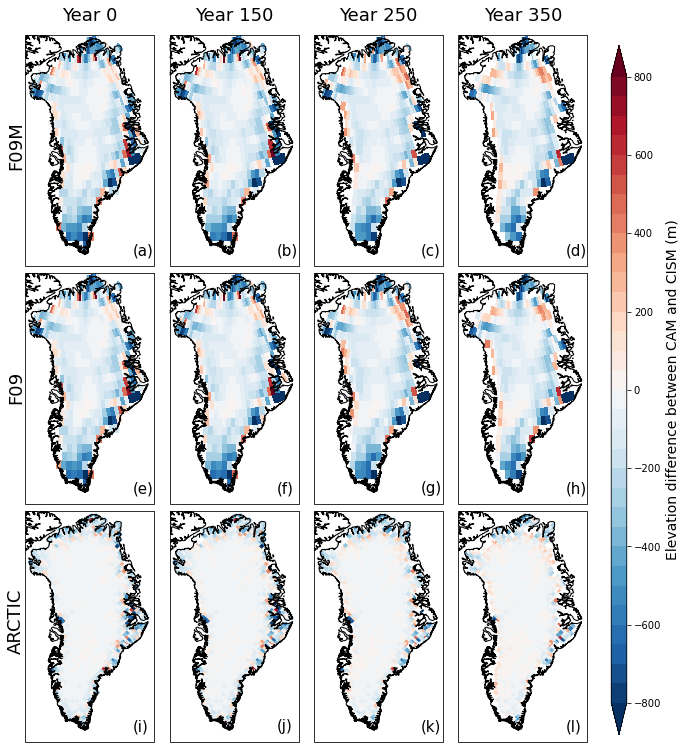

In [52]:
# CISM-CAM elevation differences
fig = plt.figure(figsize = (18,13))
gs=GridSpec(3,7)
plt.rcParams['axes.titlepad'] =14

# Modify values here
cmap1 = plt.cm.RdBu_r
bounds1 = np.arange(-800.,800.1,50.)
bounds1min = [-2000]
bounds1max = [2000]
norm1 = mpl.colors.BoundaryNorm(bounds1, cmap1.N, extend='both')
ticks1 = np.arange(-800.,800.1,200.)

size_title = 18
size_label = 15

#----------------------------line 1----------------------------
#ax1 = plt.subplot(gs[0:1,0:1], projection=polar_stereographic)
#ax1.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
#ax1.coastlines(resolution='10m', zorder=7)
#im1 = ax1.contourf(f09_lon, f09_lat, -f09_ARCTIC_SWd_diff_PI, cmap=cmap4, norm=norm4, levels=bounds4, extend='both', transform=crs_ll)
#im1c = ax1.contour(f09_lon, f09_lat, ARCTIC2f09_PHIS_PI/g, levels=bounds_elev, colors='k', linestyles='--', linewidths=0.3, transform=crs_ll)
#plt.title('', fontsize = size_title)
#plt.text(-900000, -2700000, 'ARCTIC - F09M', rotation=90, fontsize=size_title)

#ax2 = plt.subplot(gs[0:1,1:2], projection=polar_stereographic)
#ax2.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
#ax2.coastlines(resolution='10m', zorder=7)
#im2 = ax2.contourf(f09_lon2, f09_lat, ARCTIC_f09_smb_diff_PI2*3600*24*365, cmap=cmap1, norm=norm1, levels=bounds1, extend='both', transform=crs_ll)
#im2c = ax2.contour(f09_lon, f09_lat, ARCTIC2f09_PHIS_PI30/g, levels=bounds_elev, colors='k', linestyles='--', linewidths=0.3, transform=crs_ll)
#ax2.clabel(im2c, np.arange(0,4000,1000), fontsize=5)
#im2e1 = ax2.contour(f09_lon, f09_lat, ARCTIC2f09_smb_PI30.where(ARCTIC2f09_GrIS_mask_PI30>0), levels=bounds_smb, colors='r', linestyles='-', linewidths=0.5, transform=crs_ll)
#im2e2 = ax2.contour(f09_lon, f09_lat, f09_smb_PI.where(ARCTIC2f09_GrIS_mask_PI30>0), levels=bounds_smb, colors='b', linestyles='-', linewidths=0.5, transform=crs_ll)
#plt.title('SMB', fontsize = size_title)
#plt.text(-900000, -2700000, 'ARCTIC - F09M', rotation=90, fontsize=size_title)

#ax3 = plt.subplot(gs[0:1,2:3], projection=polar_stereographic)
#ax3.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
#ax3.coastlines(resolution='10m', zorder=7)
#im3 = ax3.contourf(f09_lon2, f09_lat, ARCTIC_f09_rain_diff_PI2*3600*24*365, cmap=cmap1, norm=norm1, levels=bounds1, extend='both', transform=crs_ll)
#im3c = ax3.contour(f09_lon, f09_lat, ARCTIC2f09_PHIS_PI30/g, levels=bounds_elev, colors='k', linestyles='--', linewidths=0.3, transform=crs_ll)
#plt.title('Rain', fontsize = size_title)

ax4 = plt.subplot(gs[0:1,3:4], projection=polar_stereographic)
ax4.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax4.coastlines(resolution='10m', zorder=7)
im4 = ax4.pcolormesh(f09_lon, f09_lat, F09M_stopg_diff_yr0_masked_TOf09, transform=crs_ll, cmap=cmap1, norm=norm1)
plt.title('Year 0', fontsize = size_title)
ax4.text(650000, -3360000, '(a)', fontsize=size_label)
plt.text(-900000, -2250000, 'F09M', rotation=90, fontsize=size_title)

ax5 = plt.subplot(gs[0:1,4:5], projection=polar_stereographic)
ax5.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax5.coastlines(resolution='10m', zorder=7)
im5 = ax5.pcolormesh(f09_lon, f09_lat, F09M_stopg_diff_yr150_masked_TOf09, transform=crs_ll, cmap=cmap1, norm=norm1)
ax5.text(650000, -3360000, '(b)', fontsize=size_label)
plt.title('Year 150', fontsize = size_title)

ax6 = plt.subplot(gs[0:1,5:6], projection=polar_stereographic)
ax6.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax6.coastlines(resolution='10m', zorder=7)
im6 = ax6.pcolormesh(f09_lon, f09_lat, F09M_stopg_diff_yr250_masked_TOf09, transform=crs_ll, cmap=cmap1, norm=norm1)
ax6.text(650000, -3360000, '(c)', fontsize=size_label)
plt.title('Year 250', fontsize = size_title)

ax7 = plt.subplot(gs[0:1,6:7], projection=polar_stereographic)
ax7.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax7.coastlines(resolution='10m', zorder=7)
im7 = ax7.pcolormesh(f09_lon, f09_lat, F09M_stopg_diff_yr350_masked_TOf09, transform=crs_ll, cmap=cmap1, norm=norm1)
ax7.text(650000, -3360000, '(d)', fontsize=size_label)
plt.title('Year 350', fontsize = size_title)

#----------------------------line 2----------------------------
#ax8 = plt.subplot(gs[1:2,0:1], projection=polar_stereographic)
#ax8.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
#ax8.coastlines(resolution='10m', zorder=7)
#im8 = ax8.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_smb_diff_PI2, cmap=cmap4, norm=norm4, levels=bounds4, extend='both', transform=crs_ll)
#im8c = ax8.contour(f09_lon, f09_lat, ARCTIC2f09_PHIS_PI/g, levels=bounds_elev, colors='k', linestyles='--', linewidths=0.3, transform=crs_ll)
#plt.text(-900000, -2700000, 'ARCTIC - F09', rotation=90, fontsize=size_title)

#ax9 = plt.subplot(gs[1:2,1:2], projection=polar_stereographic)
#ax9.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
#ax9.coastlines(resolution='10m', zorder=7)
#im9 = ax9.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_smb_diff_PI2*3600*24*365, cmap=cmap1, norm=norm1, levels=bounds1, extend='both', transform=crs_ll)
#im9c = ax9.contour(f09_lon, f09_lat, ARCTIC2f09_PHIS_PI30/g, levels=bounds_elev, colors='k', linestyles='--', linewidths=0.3, transform=crs_ll)
#ax9.clabel(im9c, np.arange(0,4000,1000), fontsize=5)
#im9e1 = ax9.contour(f09_lon, f09_lat, ARCTIC2f09_smb_PI30.where(ARCTIC2f09_GrIS_mask_PI30>0), levels=bounds_smb, colors='r', linestyles='-', linewidths=0.5, transform=crs_ll)
#im9e2 = ax9.contour(f09_lon, f09_lat, f09_nohacks_smb_PI30.where(ARCTIC2f09_GrIS_mask_PI30>0), levels=bounds_smb, colors='b', linestyles='-', linewidths=0.5, transform=crs_ll)
#plt.text(-900000, -2700000, 'ARCTIC - F09', rotation=90, fontsize=size_title)

#ax10 = plt.subplot(gs[1:2,2:3], projection=polar_stereographic)
#ax10.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
#ax10.coastlines(resolution='10m', zorder=7)
#im10 = ax10.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_rain_diff_PI2*3600*24*365, cmap=cmap1, norm=norm1, levels=bounds1, extend='both', transform=crs_ll)
#im10c = ax10.contour(f09_lon, f09_lat, ARCTIC2f09_PHIS_PI30/g, levels=bounds_elev, colors='k', linestyles='--', linewidths=0.3, transform=crs_ll)

ax11 = plt.subplot(gs[1:2,3:4], projection=polar_stereographic)
ax11.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax11.coastlines(resolution='10m', zorder=7)
im11 = ax11.pcolormesh(f09_lon, f09_lat, F09_stopg_diff_yr0_masked_TOf09, transform=crs_ll, cmap=cmap1, norm=norm1)
ax11.text(650000, -3360000, '(e)', fontsize=size_label)
plt.text(-900000, -2200000, 'F09', rotation=90, fontsize=size_title)

ax12 = plt.subplot(gs[1:2,4:5], projection=polar_stereographic)
ax12.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax12.coastlines(resolution='10m', zorder=7)
im12 = ax12.pcolormesh(f09_lon, f09_lat, F09_stopg_diff_yr150_masked_TOf09, transform=crs_ll, cmap=cmap1, norm=norm1)
ax12.text(650000, -3360000, '(f)', fontsize=size_label)

ax13 = plt.subplot(gs[1:2,5:6], projection=polar_stereographic)
ax13.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax13.coastlines(resolution='10m', zorder=7)
im13 = ax13.pcolormesh(f09_lon, f09_lat, F09_stopg_diff_yr250_masked_TOf09, transform=crs_ll, cmap=cmap1, norm=norm1)
ax13.text(650000, -3360000, '(g)', fontsize=size_label)

ax14 = plt.subplot(gs[1:2,6:7], projection=polar_stereographic)
ax14.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax14.coastlines(resolution='10m', zorder=7)
im14 = ax14.pcolormesh(f09_lon, f09_lat, F09_stopg_diff_yr350_masked_TOf09, transform=crs_ll, cmap=cmap1, norm=norm1)
ax14.text(650000, -3360000, '(h)', fontsize=size_label)

# colorbar
cbar_ax13 = fig.add_axes([0.915, 0.133, 0.012, 0.736])
cb13 = fig.colorbar(im13, cax=cbar_ax13, orientation='vertical', boundaries=bounds1min+bounds1+bounds1max, ticks=ticks1)
cb13.set_label(label='Elevation difference between CAM and CISM (m)', size=14)
cb13.ax.tick_params(labelsize=10)

#----------------------------line 3----------------------------
#ax15 = plt.subplot(gs[1:2,0:1], projection=polar_stereographic)
#ax15.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
#ax15.coastlines(resolution='10m', zorder=7)
#im15 = ax15.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_smb_diff_PI2, cmap=cmap4, norm=norm4, levels=bounds4, extend='both', transform=crs_ll)
#im15c = ax15.contour(f09_lon, f09_lat, ARCTIC2f09_PHIS_PI/g, levels=bounds_elev, colors='k', linestyles='--', linewidths=0.3, transform=crs_ll)
#plt.text(-900000, -2700000, 'ARCTIC - F09', rotation=90, fontsize=size_title)

#ax16 = plt.subplot(gs[1:2,1:2], projection=polar_stereographic)
#ax16.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
#ax16.coastlines(resolution='10m', zorder=7)
#im16 = ax16.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_smb_diff_PI2*3600*24*365, cmap=cmap1, norm=norm1, levels=bounds1, extend='both', transform=crs_ll)
#im16c = ax16.contour(f09_lon, f09_lat, ARCTIC2f09_PHIS_PI30/g, levels=bounds_elev, colors='k', linestyles='--', linewidths=0.3, transform=crs_ll)
#ax16.clabel(im9c, np.arange(0,4000,1000), fontsize=5)
#plt.text(-900000, -2700000, 'ARCTIC - F09', rotation=90, fontsize=size_title)

#ax17 = plt.subplot(gs[1:2,2:3], projection=polar_stereographic)
#ax17.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
#ax17.coastlines(resolution='10m', zorder=7)
#im17 = ax17.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_rain_diff_PI2*3600*24*365, cmap=cmap1, norm=norm1, levels=bounds1, extend='both', transform=crs_ll)
#im17c = ax17.contour(f09_lon, f09_lat, ARCTIC2f09_PHIS_PI30/g, levels=bounds_elev, colors='k', linestyles='--', linewidths=0.3, transform=crs_ll)

ax18 = plt.subplot(gs[2:3,3:4], projection=polar_stereographic)
ax18.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax18.coastlines(resolution='10m', zorder=7)
im18 = PolyCollection(ARCTIC_stopg_diff_yr0_verts, cmap=cmap1, transform=crs_ll, norm=norm1,
                     **kwd_polycollection)
im18.set_array(ARCTIC_stopg_diff_yr0_var)
im18.set_clim(vmin=-800, vmax=800)
ax18.add_collection(im18)
ax18.text(650000, -3360000, '(i)', fontsize=size_label)
plt.text(-900000, -2350000, 'ARCTIC', rotation=90, fontsize=size_title)

ax19 = plt.subplot(gs[2:3,4:5], projection=polar_stereographic)
ax19.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax19.coastlines(resolution='10m', zorder=7)
im19 = PolyCollection(ARCTIC_stopg_diff_yr150_verts, cmap=cmap1, transform=crs_ll, norm=norm1,
                     **kwd_polycollection)
im19.set_array(ARCTIC_stopg_diff_yr150_var)
im19.set_clim(vmin=-800, vmax=800)
ax19.add_collection(im19)
ax19.text(650000, -3360000, '(j)', fontsize=size_label)

ax20 = plt.subplot(gs[2:3,5:6], projection=polar_stereographic)
ax20.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax20.coastlines(resolution='10m', zorder=7)
im20 = PolyCollection(ARCTIC_stopg_diff_yr250_verts, cmap=cmap1, transform=crs_ll, norm=norm1,
                     **kwd_polycollection)
im20.set_array(ARCTIC_stopg_diff_yr250_var)
im20.set_clim(vmin=-800, vmax=800)
ax20.add_collection(im20)
ax20.text(650000, -3360000, '(k)', fontsize=size_label)

ax21 = plt.subplot(gs[2:3,6:7], projection=polar_stereographic)
ax21.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax21.coastlines(resolution='10m', zorder=7)
im21 = PolyCollection(ARCTIC_stopg_diff_yr350_verts, cmap=cmap1, transform=crs_ll, norm=norm1,
                     **kwd_polycollection)
im21.set_array(ARCTIC_stopg_diff_yr350_var)
im21.set_clim(vmin=-800, vmax=800)
ax21.add_collection(im21)
ax21.text(650000, -3360000, '(l)', fontsize=size_label)

plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.05,
                    hspace=0.03)

plt.savefig(home_dir+'2022-VR-dynamic-GrIS/github/plot/Map_elev_diff_CAM_CISM.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

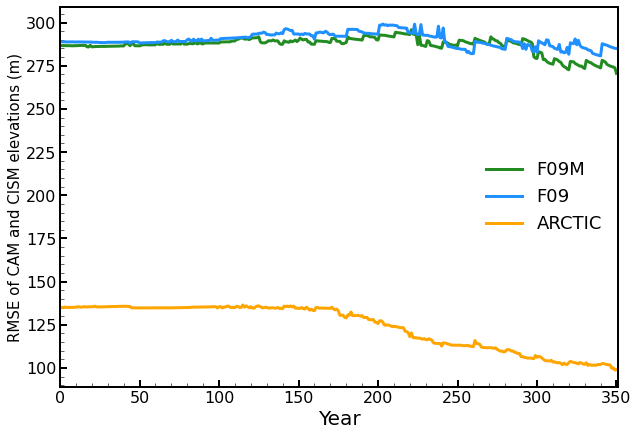

In [88]:
fig = plt.figure(figsize = (10,7))
gs=GridSpec(1,1)
plt.rcParams['axes.linewidth'] = 2 #set the value globally

size_tick = 16
size_label = 20
size_legend = 18

#-------------------------------------------- Z500 --------------------------------------------
ax1 = plt.subplot(gs[0])

ax1.plot(np.arange(1,351), F09M_stopg_diff_masked_RMSE, color = 'forestgreen', linewidth = 3, label='F09M');
ax1.plot(np.arange(1,351), F09_stopg_diff_masked_RMSE, color = 'dodgerblue', linewidth = 3, label='F09');
ax1.plot(np.arange(1,351), ARCTIC_stopg_diff_masked_RMSE, color = 'orange', linewidth = 3, label='ARCTIC');

ax1.set_xlim([0, 351])
ax1.set_xlabel('Year', fontsize=size_label)
ax1.set_ylabel('RMSE of CAM and CISM elevations (m)', fontsize=size_label-5)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='major', length=7, width=2, direction='in')
ax1.tick_params(which='minor', length=4, direction='in')
ax1.tick_params(labelsize=size_tick)

ax1.legend(loc='best', frameon = False, prop={'size':size_legend}, ncol=1)

plt.subplots_adjust(wspace=0.28)
plt.savefig(home_dir+'2022-VR-dynamic-GrIS/github/plot/tseries_RMSE_elev_CAM_CISM.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False) #

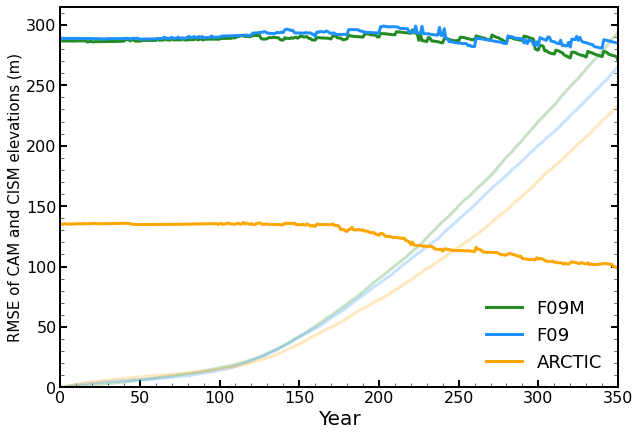

In [74]:
# RMSE
fig = plt.figure(figsize = (10,7))
gs=GridSpec(1,1)
plt.rcParams['axes.linewidth'] = 2 #set the value globally

size_tick = 16
size_label = 20
size_legend = 18

#-------------------------------------------- Z500 --------------------------------------------
ax1 = plt.subplot(gs[0])

ax1.plot(np.arange(1,351), F09M_stopg_change_masked_RMSE, color='forestgreen', linewidth=3, alpha=0.25);
ax1.plot(np.arange(1,351), F09_stopg_change_masked_RMSE, color='dodgerblue', linewidth=3, alpha=0.25);
ax1.plot(np.arange(1,351), ARCTIC_stopg_change_masked_RMSE, color='orange', linewidth=3, alpha=0.25);

ax1.plot(np.arange(1,351), F09M_stopg_diff_masked_RMSE, color='forestgreen', linewidth=3, label='F09M');
ax1.plot(np.arange(1,351), F09_stopg_diff_masked_RMSE, color='dodgerblue', linewidth=3, label='F09');
ax1.plot(np.arange(1,351), ARCTIC_stopg_diff_masked_RMSE, color='orange', linewidth=3, label='ARCTIC');

ax1.set_xlim([0, 350])
ax1.set_ylim([0, 315])
ax1.set_xlabel('Year', fontsize=size_label)
ax1.set_ylabel('RMSE of CAM and CISM elevations (m)', fontsize=size_label-5)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='major', length=7, width=2, direction='in', right=True, labelright=False)
ax1.tick_params(which='minor', length=4, direction='in', right=True, labelright=False)
ax1.tick_params(labelsize=size_tick)

ax1.legend(loc='best', frameon=False, prop={'size':size_legend}, ncol=1)

plt.subplots_adjust(wspace=0.28)
plt.savefig(home_dir+'2022-VR-dynamic-GrIS/github/plot/tseries_RMSE_elev_CAM_CISM_elev_change_CISM.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False) #